## Informed V-JEPA
We investigate how HNN and LNN and VJEPA can learn and represent the physics behind a pendulum.
Steps :
- through openai gym we generate synthetic pendulum images. Each image is labeled by the physical state theta, theta dot. This is the ground truth for the learning and evaluation of physics/
- use utility funvtions to compute and plot the energy and true phase space trajectories of the pendulum, enabling visual checks for consistency and energy conservation.
- train vjepa to predict future image patches, i.e. latent states too, and track loss curves for both jepa objective and physics informed loss we came up with.
- We check the relationship between learned latent representations and true physical variables. We use linear regression to map latents to physical variables with metrics such as R2 and MSE.
- We have plots that show how well the model conserves energy over time and how close its latent space aligns with the true dynamics, ie. try to provide insights how the network encapsulates the underlying physics.

In [1]:
# necessary imports
from hamiltonian_nn.hnn import HNN                  # Sam Greydanus repo file
from hamiltonian_nn.nn_models import MLP     # 3-layer MLP the repo already uses
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
from torch.utils.data import DataLoader
from tqdm import tqdm
import os
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gym
from torchvision import transforms
from PIL import Image, ImageDraw

In [2]:
def compute_energy(theta, omega, m=1.0, l=1.0, g=9.81):
    """
    Compute the total mechanical energy of the pendulum
    E = 0.5 * m * l^2 * omega^2 + m * g * l * (1 - cos(theta))
    """
    kinetic = 0.5 * m * (l**2) * omega**2
    potential = m * g * l * (1 - np.cos(theta))
    return kinetic + potential

In [3]:
# Here we plot the energy of the pendulum system for each episode in the dataset.
# Dataset has each item : input and label. label contains theta omega. The
# episode length is te nr of steps in each episode

def plot_energy_per_episode(dataset, episode_length=100):
    thetas = []
    omegas = []
    energies = []
    num_episodes = len(dataset) // episode_length

    # go through all episodes and each time step of the episode
    for ep in range(num_episodes):
        ep_thetas = []
        ep_omegas = []
        for i in range(episode_length):
            idx = ep * episode_length + i
            _, label = dataset[idx]
            ep_thetas.append(label[0].item())
            ep_omegas.append(label[1].item())
        theta_np = np.array(ep_thetas)
        omega_np = np.array(ep_omegas)
        # calculate energy
        energy = compute_energy(theta_np, omega_np)
        energies.append(energy)

    # Plot each episode separately
    plt.figure(figsize=(12, 4))
    for ep_energy in energies:
        plt.plot(ep_energy, alpha=0.7)
    plt.xlabel("Time Step (within episode)")
    plt.ylabel("Energy (J)")
    plt.title("Pendulum Energy per Episode")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("energy_per_episode.png")
    plt.show()


In [4]:
# plot the true phase space trajectory, i.e. theta vs theta dot
# dataset laid out like above

def plot_true_phase_space(dataset, num_samples=500):
    theta_vals = []
    omega_vals = []
    # loop over the nr of samples
    for i in range(min(num_samples, len(dataset))):
        _, label = dataset[i]
        theta_vals.append(label[0].item())
        omega_vals.append(label[1].item())

    plt.figure(figsize=(6, 5))
    plt.plot(theta_vals, omega_vals, '.', alpha=0.3)
    plt.xlabel("Theta (rad)")
    plt.ylabel("Theta dot (rad/s)")
    plt.title("True Phase Space Trajectory (θ vs θ̇)")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("true_phase_space.png")
    plt.show()

In [5]:
def analyze_vjepa_latent_phase_relation(model, dataset, batch_size=64, num_samples=500):
    """
    Analyze how V-JEPA latent embeddings relate to physical phase space variables (theta, theta_dot).
    This assumes access to the latent features before the prediction head.

    Args:
        model: trained V-JEPA model
        dataset: PendulumDataset object with access to raw images and (theta, omega) tuples
        batch_size: batch size for DataLoader
        num_samples: number of samples to analyze
    """
    model.eval()

    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    latent_features = []
    theta_list = []
    omega_list = []

    count = 0
    # iterate and extract embeddings and ground truth
    for imgs, labels in tqdm(loader, desc="Extracting embeddings"):
        imgs = imgs.to(next(model.parameters()).device)
        thetas, omegas = labels[:, 0], labels[:, 1] # do extractions

        with torch.no_grad(): # forward pass through the patch embedder
            x = model.patch_embed(imgs) + model.pos_embed  # [B, N, D]
            x = model.context_encoder(x)  # [B, N, D]
            pooled = x.mean(dim=1)  # average pooling over patches -> [B, D]
            latent_features.append(pooled.cpu())

        # collect ground truth phase space variables
        theta_list.extend(thetas.numpy())
        omega_list.extend(omegas.numpy())

        count += imgs.size(0)
        if count >= num_samples:
            break

    # concatenate all latent features and truncate
    latent_features = torch.cat(latent_features, dim=0).numpy()[:num_samples]
    theta_array = np.array(theta_list[:num_samples]).reshape(-1, 1)
    omega_array = np.array(omega_list[:num_samples]).reshape(-1, 1)

    # Fit regressors
    reg_theta = LinearRegression().fit(latent_features, theta_array)
    reg_omega = LinearRegression().fit(latent_features, omega_array)

    theta_pred = reg_theta.predict(latent_features)
    omega_pred = reg_omega.predict(latent_features)

    # Metrics
    r2_theta = r2_score(theta_array, theta_pred)
    r2_omega = r2_score(omega_array, omega_pred)
    mse_theta = mean_squared_error(theta_array, theta_pred)
    mse_omega = mean_squared_error(omega_array, omega_pred)

    print(f"\nLatent -> Theta R²: {r2_theta:.4f}, MSE: {mse_theta:.4f}")
    print(f"Latent -> Omega R²: {r2_omega:.4f}, MSE: {mse_omega:.4f}")

    # Scatter plot
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.scatter(theta_array, theta_pred, alpha=0.6)
    plt.xlabel("True θ")
    plt.ylabel("Predicted θ from Latents")
    plt.title("Latent Embedding → Theta")

    plt.subplot(1, 2, 2)
    plt.scatter(omega_array, omega_pred, alpha=0.6)
    plt.xlabel("True θ̇")
    plt.ylabel("Predicted θ̇ from Latents")
    plt.title("Latent Embedding → Theta_dot")

    plt.tight_layout()
    plt.show()


In [6]:
def plot_energy_conservation(dataset, dt=0.05, m=1.0, l=1.0, g=9.81):
    """
    Plot total mechanical energy vs. time (seconds).

    • Works with the original PendulumDataset (attributes .labels)
      *and* with the windowed version that stores .states.

    • dt – time delta between successive frames; Gym's pendulum uses
      0.05 s by default.
    """
    import numpy as np, matplotlib.pyplot as plt

    # -------- pull θ and θ̇ from whichever attr exists -------------
    if hasattr(dataset, "states"):               # windowed version
        data = np.asarray(dataset.states)        # (N,2)
    elif hasattr(dataset, "labels"):             # flat version
        data = np.asarray(dataset.labels)
    else:
        # fallback: iterate through dataset
        data = np.concatenate([dataset[i][1].numpy() for i in range(len(dataset))])

    theta, theta_dot = data[:,0], data[:,1]

    # -------- energy ----------------------------------------------
    kinetic   = 0.5 * m * (l**2) * theta_dot**2          # ½ m (l θ̇)²
    potential = m * g * l * (1 - np.cos(theta))
    E_total   = kinetic + potential

    # -------- time axis in seconds -------------------------------
    t = np.arange(len(E_total)) * dt

    # -------- plot ------------------------------------------------
    plt.figure(figsize=(10,4))
    plt.plot(t, E_total, lw=1.0, label="Total Energy")
    plt.xlabel("time  [s]")
    plt.ylabel("energy  [J]")
    plt.title("Pendulum energy (ground-truth)")
    plt.grid(True); plt.tight_layout(); plt.legend()
    plt.show()

Using device: cpu
Generating synthetic pendulum data...


  0%|          | 0/50 [00:00<?, ?it/s]/Users/panaschristou/miniforge3/envs/sys_dev/lib/python3.12/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|██████████| 50/50 [00:00<00:00, 167.62it/s]


Dataset created with 5000 images
Starting training…


Epoch 1/10:   1%|          | 1/157 [00:01<03:42,  1.42s/batch]

  step 0000  jepa 6.6719  phys 12.3256


Epoch 1/10:   7%|▋         | 11/157 [00:12<02:36,  1.08s/batch]

  step 0010  jepa 4.0869  phys 13.2601


Epoch 1/10:  13%|█▎        | 21/157 [00:22<02:24,  1.06s/batch]

  step 0020  jepa 3.7140  phys 7.4312


Epoch 1/10:  20%|█▉        | 31/157 [00:34<02:18,  1.10s/batch]

  step 0030  jepa 3.2910  phys 13.0277


Epoch 1/10:  26%|██▌       | 41/157 [00:45<02:04,  1.07s/batch]

  step 0040  jepa 2.8998  phys 11.5840


Epoch 1/10:  32%|███▏      | 51/157 [00:56<01:57,  1.11s/batch]

  step 0050  jepa 2.5192  phys 8.9082


Epoch 1/10:  39%|███▉      | 61/157 [01:06<01:39,  1.03s/batch]

  step 0060  jepa 2.1686  phys 10.4867


Epoch 1/10:  45%|████▌     | 71/157 [01:17<01:27,  1.01s/batch]

  step 0070  jepa 1.8858  phys 9.5883


Epoch 1/10:  52%|█████▏    | 81/157 [01:27<01:19,  1.05s/batch]

  step 0080  jepa 1.6900  phys 8.7502


Epoch 1/10:  58%|█████▊    | 91/157 [01:37<01:07,  1.02s/batch]

  step 0090  jepa 1.5372  phys 10.6461


Epoch 1/10:  64%|██████▍   | 101/157 [01:48<00:57,  1.03s/batch]

  step 0100  jepa 1.4463  phys 10.1834


Epoch 1/10:  71%|███████   | 111/157 [01:58<00:49,  1.08s/batch]

  step 0110  jepa 1.3742  phys 12.8607


Epoch 1/10:  77%|███████▋  | 121/157 [02:09<00:39,  1.10s/batch]

  step 0120  jepa 1.3276  phys 7.8986


Epoch 1/10:  83%|████████▎ | 131/157 [02:21<00:31,  1.21s/batch]

  step 0130  jepa 1.2996  phys 11.2996


Epoch 1/10:  90%|████████▉ | 141/157 [02:33<00:18,  1.15s/batch]

  step 0140  jepa 1.2810  phys 12.5883


Epoch 1/10:  96%|█████████▌| 151/157 [02:47<00:09,  1.51s/batch]

  step 0150  jepa 1.2732  phys 9.2862


Epoch 1/10: 100%|██████████| 157/157 [02:54<00:00,  1.11s/batch]


Epoch 1 complete — avg loss 2.2683


Epoch 2/10:   1%|          | 1/157 [00:01<05:07,  1.97s/batch]

  step 0000  jepa 1.2460  phys 9.0716


Epoch 2/10:   7%|▋         | 11/157 [00:16<03:27,  1.42s/batch]

  step 0010  jepa 1.2420  phys 14.0685


Epoch 2/10:  13%|█▎        | 21/157 [00:28<02:38,  1.17s/batch]

  step 0020  jepa 1.2274  phys 13.9475


Epoch 2/10:  20%|█▉        | 31/157 [00:38<02:16,  1.08s/batch]

  step 0030  jepa 1.2228  phys 11.2139


Epoch 2/10:  26%|██▌       | 41/157 [00:48<01:54,  1.01batch/s]

  step 0040  jepa 1.2117  phys 11.9111


Epoch 2/10:  32%|███▏      | 51/157 [00:59<01:47,  1.01s/batch]

  step 0050  jepa 1.2162  phys 7.7874


Epoch 2/10:  39%|███▉      | 61/157 [01:09<01:34,  1.02batch/s]

  step 0060  jepa 1.1886  phys 7.4216


Epoch 2/10:  45%|████▌     | 71/157 [01:18<01:23,  1.03batch/s]

  step 0070  jepa 1.1959  phys 10.7697


Epoch 2/10:  52%|█████▏    | 81/157 [01:29<01:15,  1.00batch/s]

  step 0080  jepa 1.1627  phys 9.9499


Epoch 2/10:  58%|█████▊    | 91/157 [01:38<01:04,  1.02batch/s]

  step 0090  jepa 1.1452  phys 12.4663


Epoch 2/10:  64%|██████▍   | 101/157 [01:48<00:55,  1.01batch/s]

  step 0100  jepa 1.1447  phys 6.8541


Epoch 2/10:  71%|███████   | 111/157 [01:58<00:46,  1.02s/batch]

  step 0110  jepa 1.1329  phys 12.4271


Epoch 2/10:  77%|███████▋  | 121/157 [02:08<00:35,  1.01batch/s]

  step 0120  jepa 1.1199  phys 12.2101


Epoch 2/10:  83%|████████▎ | 131/157 [02:18<00:25,  1.04batch/s]

  step 0130  jepa 1.1176  phys 10.1023


Epoch 2/10:  90%|████████▉ | 141/157 [02:28<00:16,  1.01s/batch]

  step 0140  jepa 1.1124  phys 12.3980


Epoch 2/10:  96%|█████████▌| 151/157 [02:38<00:06,  1.06s/batch]

  step 0150  jepa 1.0970  phys 12.3022


Epoch 2/10: 100%|██████████| 157/157 [02:43<00:00,  1.04s/batch]


Epoch 2 complete — avg loss 1.1869


Epoch 3/10:   1%|          | 1/157 [00:01<02:51,  1.10s/batch]

  step 0000  jepa 1.1266  phys 14.1754


Epoch 3/10:   7%|▋         | 11/157 [00:12<02:48,  1.15s/batch]

  step 0010  jepa 1.0900  phys 16.9918


Epoch 3/10:  13%|█▎        | 21/157 [00:23<02:33,  1.13s/batch]

  step 0020  jepa 1.1016  phys 4.5138


Epoch 3/10:  20%|█▉        | 31/157 [00:34<02:23,  1.14s/batch]

  step 0030  jepa 1.0879  phys 9.4352


Epoch 3/10:  26%|██▌       | 41/157 [00:44<01:52,  1.03batch/s]

  step 0040  jepa 1.0718  phys 12.3403


Epoch 3/10:  32%|███▏      | 51/157 [00:53<01:42,  1.04batch/s]

  step 0050  jepa 1.0903  phys 11.3516


Epoch 3/10:  39%|███▉      | 61/157 [01:03<01:31,  1.05batch/s]

  step 0060  jepa 1.0671  phys 11.7135


Epoch 3/10:  45%|████▌     | 71/157 [01:12<01:21,  1.05batch/s]

  step 0070  jepa 1.0683  phys 11.4800


Epoch 3/10:  52%|█████▏    | 81/157 [01:22<01:14,  1.02batch/s]

  step 0080  jepa 1.0681  phys 12.5892


Epoch 3/10:  58%|█████▊    | 91/157 [01:32<01:05,  1.01batch/s]

  step 0090  jepa 1.0774  phys 10.7714


Epoch 3/10:  64%|██████▍   | 101/157 [01:42<00:54,  1.03batch/s]

  step 0100  jepa 1.0732  phys 6.6960


Epoch 3/10:  71%|███████   | 111/157 [01:55<00:57,  1.25s/batch]

  step 0110  jepa 1.0581  phys 9.7905


Epoch 3/10:  77%|███████▋  | 121/157 [02:06<00:42,  1.18s/batch]

  step 0120  jepa 1.0718  phys 11.5851


Epoch 3/10:  83%|████████▎ | 131/157 [02:18<00:31,  1.22s/batch]

  step 0130  jepa 1.0643  phys 10.9142


Epoch 3/10:  90%|████████▉ | 141/157 [02:31<00:18,  1.15s/batch]

  step 0140  jepa 1.0595  phys 10.3814


Epoch 3/10:  96%|█████████▌| 151/157 [02:42<00:06,  1.11s/batch]

  step 0150  jepa 1.0693  phys 8.6832


Epoch 3/10: 100%|██████████| 157/157 [02:48<00:00,  1.07s/batch]


Epoch 3 complete — avg loss 1.0880


Epoch 4/10:   1%|          | 1/157 [00:01<02:44,  1.06s/batch]

  step 0000  jepa 1.0722  phys 11.5175


Epoch 4/10:   7%|▋         | 11/157 [00:11<02:35,  1.06s/batch]

  step 0010  jepa 1.0712  phys 11.3186


Epoch 4/10:  13%|█▎        | 21/157 [00:22<02:25,  1.07s/batch]

  step 0020  jepa 1.0608  phys 9.7105


Epoch 4/10:  20%|█▉        | 31/157 [00:33<02:21,  1.12s/batch]

  step 0030  jepa 1.0535  phys 13.5485


Epoch 4/10:  26%|██▌       | 41/157 [00:44<02:10,  1.13s/batch]

  step 0040  jepa 1.0591  phys 10.6400


Epoch 4/10:  32%|███▏      | 51/157 [00:55<01:53,  1.07s/batch]

  step 0050  jepa 1.0581  phys 13.3450


Epoch 4/10:  39%|███▉      | 61/157 [01:06<01:43,  1.08s/batch]

  step 0060  jepa 1.0546  phys 10.4521


Epoch 4/10:  45%|████▌     | 71/157 [01:17<01:32,  1.08s/batch]

  step 0070  jepa 1.0441  phys 11.1648


Epoch 4/10:  52%|█████▏    | 81/157 [01:28<01:22,  1.08s/batch]

  step 0080  jepa 1.0628  phys 7.0489


Epoch 4/10:  58%|█████▊    | 91/157 [01:39<01:11,  1.09s/batch]

  step 0090  jepa 1.0518  phys 9.6488


Epoch 4/10:  64%|██████▍   | 101/157 [01:49<00:59,  1.06s/batch]

  step 0100  jepa 1.0525  phys 10.8549


Epoch 4/10:  71%|███████   | 111/157 [02:00<00:51,  1.12s/batch]

  step 0110  jepa 1.0492  phys 13.5018


Epoch 4/10:  77%|███████▋  | 121/157 [02:11<00:39,  1.08s/batch]

  step 0120  jepa 1.0514  phys 11.5864


Epoch 4/10:  83%|████████▎ | 131/157 [02:22<00:27,  1.06s/batch]

  step 0130  jepa 1.0497  phys 8.2589


Epoch 4/10:  90%|████████▉ | 141/157 [02:33<00:17,  1.12s/batch]

  step 0140  jepa 1.0473  phys 9.4524


Epoch 4/10:  96%|█████████▌| 151/157 [02:44<00:06,  1.06s/batch]

  step 0150  jepa 1.0470  phys 11.2260


Epoch 4/10: 100%|██████████| 157/157 [02:50<00:00,  1.08s/batch]


Epoch 4 complete — avg loss 1.0655


Epoch 5/10:   1%|          | 1/157 [00:01<02:57,  1.14s/batch]

  step 0000  jepa 1.0462  phys 7.3845


Epoch 5/10:   7%|▋         | 11/157 [00:11<02:37,  1.08s/batch]

  step 0010  jepa 1.0400  phys 11.7678


Epoch 5/10:  13%|█▎        | 21/157 [00:22<02:30,  1.11s/batch]

  step 0020  jepa 1.0482  phys 11.1265


Epoch 5/10:  20%|█▉        | 31/157 [00:33<02:13,  1.06s/batch]

  step 0030  jepa 1.0462  phys 11.6506


Epoch 5/10:  26%|██▌       | 41/157 [00:44<02:06,  1.09s/batch]

  step 0040  jepa 1.0411  phys 11.4768


Epoch 5/10:  32%|███▏      | 51/157 [00:57<02:07,  1.20s/batch]

  step 0050  jepa 1.0414  phys 10.8721


Epoch 5/10:  39%|███▉      | 61/157 [01:08<01:45,  1.10s/batch]

  step 0060  jepa 1.0400  phys 9.6599


Epoch 5/10:  45%|████▌     | 71/157 [01:19<01:33,  1.09s/batch]

  step 0070  jepa 1.0448  phys 13.4858


Epoch 5/10:  52%|█████▏    | 81/157 [01:30<01:21,  1.08s/batch]

  step 0080  jepa 1.0435  phys 13.0082


Epoch 5/10:  58%|█████▊    | 91/157 [01:41<01:10,  1.07s/batch]

  step 0090  jepa 1.0407  phys 8.3798


Epoch 5/10:  64%|██████▍   | 101/157 [01:51<00:59,  1.07s/batch]

  step 0100  jepa 1.0359  phys 6.1212


Epoch 5/10:  71%|███████   | 111/157 [02:02<00:50,  1.10s/batch]

  step 0110  jepa 1.0390  phys 9.7540


Epoch 5/10:  77%|███████▋  | 121/157 [02:13<00:38,  1.06s/batch]

  step 0120  jepa 1.0436  phys 8.1508


Epoch 5/10:  83%|████████▎ | 131/157 [02:24<00:27,  1.07s/batch]

  step 0130  jepa 1.0370  phys 11.5755


Epoch 5/10:  90%|████████▉ | 141/157 [02:34<00:16,  1.05s/batch]

  step 0140  jepa 1.0378  phys 12.2272


Epoch 5/10:  96%|█████████▌| 151/157 [02:45<00:06,  1.10s/batch]

  step 0150  jepa 1.0408  phys 10.1152


Epoch 5/10: 100%|██████████| 157/157 [02:51<00:00,  1.09s/batch]


Epoch 5 complete — avg loss 1.0541


Epoch 6/10:   1%|          | 1/157 [00:01<03:02,  1.17s/batch]

  step 0000  jepa 1.0380  phys 10.2175


Epoch 6/10:   7%|▋         | 11/157 [00:12<02:41,  1.10s/batch]

  step 0010  jepa 1.0413  phys 12.0913


Epoch 6/10:  13%|█▎        | 21/157 [00:22<02:24,  1.06s/batch]

  step 0020  jepa 1.0415  phys 11.8480


Epoch 6/10:  20%|█▉        | 31/157 [00:33<02:15,  1.08s/batch]

  step 0030  jepa 1.0378  phys 9.7706


Epoch 6/10:  26%|██▌       | 41/157 [00:44<02:03,  1.07s/batch]

  step 0040  jepa 1.0453  phys 10.7209


Epoch 6/10:  32%|███▏      | 51/157 [00:55<02:00,  1.14s/batch]

  step 0050  jepa 1.0407  phys 9.4096


Epoch 6/10:  39%|███▉      | 61/157 [01:06<01:42,  1.06s/batch]

  step 0060  jepa 1.0366  phys 15.5229


Epoch 6/10:  45%|████▌     | 71/157 [01:16<01:33,  1.08s/batch]

  step 0070  jepa 1.0342  phys 10.2778


Epoch 6/10:  52%|█████▏    | 81/157 [01:28<01:23,  1.09s/batch]

  step 0080  jepa 1.0289  phys 11.2587


Epoch 6/10:  58%|█████▊    | 91/157 [01:38<01:12,  1.09s/batch]

  step 0090  jepa 1.0356  phys 10.9422


Epoch 6/10:  64%|██████▍   | 101/157 [01:49<00:59,  1.06s/batch]

  step 0100  jepa 1.0367  phys 8.0818


Epoch 6/10:  71%|███████   | 111/157 [02:01<00:54,  1.18s/batch]

  step 0110  jepa 1.0337  phys 12.3988


Epoch 6/10:  77%|███████▋  | 121/157 [02:12<00:38,  1.06s/batch]

  step 0120  jepa 1.0258  phys 7.8127


Epoch 6/10:  83%|████████▎ | 131/157 [02:23<00:28,  1.08s/batch]

  step 0130  jepa 1.0367  phys 12.2130


Epoch 6/10:  90%|████████▉ | 141/157 [02:34<00:16,  1.05s/batch]

  step 0140  jepa 1.0360  phys 10.5792


Epoch 6/10:  96%|█████████▌| 151/157 [02:46<00:06,  1.11s/batch]

  step 0150  jepa 1.0284  phys 7.4713


Epoch 6/10: 100%|██████████| 157/157 [02:52<00:00,  1.10s/batch]


Epoch 6 complete — avg loss 1.0460


Epoch 7/10:   1%|          | 1/157 [00:01<04:13,  1.63s/batch]

  step 0000  jepa 1.0431  phys 11.2365


Epoch 7/10:   7%|▋         | 11/157 [00:12<02:35,  1.07s/batch]

  step 0010  jepa 1.0331  phys 10.8360


Epoch 7/10:  13%|█▎        | 21/157 [00:23<02:25,  1.07s/batch]

  step 0020  jepa 1.0257  phys 11.2207


Epoch 7/10:  20%|█▉        | 31/157 [00:34<02:21,  1.13s/batch]

  step 0030  jepa 1.0356  phys 8.0807


Epoch 7/10:  26%|██▌       | 41/157 [00:45<02:08,  1.11s/batch]

  step 0040  jepa 1.0221  phys 15.7621


Epoch 7/10:  32%|███▏      | 51/157 [00:56<01:54,  1.08s/batch]

  step 0050  jepa 1.0257  phys 6.1570


Epoch 7/10:  39%|███▉      | 61/157 [01:06<01:42,  1.06s/batch]

  step 0060  jepa 1.0312  phys 11.1997


Epoch 7/10:  45%|████▌     | 71/157 [01:17<01:35,  1.11s/batch]

  step 0070  jepa 1.0310  phys 9.5523


Epoch 7/10:  52%|█████▏    | 81/157 [01:28<01:20,  1.06s/batch]

  step 0080  jepa 1.0295  phys 9.2894


Epoch 7/10:  58%|█████▊    | 91/157 [01:38<01:09,  1.06s/batch]

  step 0090  jepa 1.0244  phys 8.6164


Epoch 7/10:  64%|██████▍   | 101/157 [01:49<01:00,  1.09s/batch]

  step 0100  jepa 1.0287  phys 9.0209


Epoch 7/10:  71%|███████   | 111/157 [02:00<00:50,  1.09s/batch]

  step 0110  jepa 1.0254  phys 9.7476


Epoch 7/10:  77%|███████▋  | 121/157 [02:10<00:37,  1.05s/batch]

  step 0120  jepa 1.0227  phys 13.0982


Epoch 7/10:  83%|████████▎ | 131/157 [02:21<00:27,  1.05s/batch]

  step 0130  jepa 1.0201  phys 8.9842


Epoch 7/10:  90%|████████▉ | 141/157 [02:32<00:17,  1.09s/batch]

  step 0140  jepa 1.0350  phys 12.0620


Epoch 7/10:  96%|█████████▌| 151/157 [02:43<00:06,  1.12s/batch]

  step 0150  jepa 1.0292  phys 10.0276


Epoch 7/10: 100%|██████████| 157/157 [02:50<00:00,  1.08s/batch]


Epoch 7 complete — avg loss 1.0410


Epoch 8/10:   1%|          | 1/157 [00:01<03:05,  1.19s/batch]

  step 0000  jepa 1.0212  phys 7.5363


Epoch 8/10:   7%|▋         | 11/157 [00:12<02:52,  1.18s/batch]

  step 0010  jepa 1.0236  phys 11.0872


Epoch 8/10:  13%|█▎        | 21/157 [00:24<02:29,  1.10s/batch]

  step 0020  jepa 1.0381  phys 14.2957


Epoch 8/10:  20%|█▉        | 31/157 [00:35<02:17,  1.09s/batch]

  step 0030  jepa 1.0267  phys 8.9899


Epoch 8/10:  26%|██▌       | 41/157 [00:46<02:06,  1.09s/batch]

  step 0040  jepa 1.0237  phys 12.9747


Epoch 8/10:  32%|███▏      | 51/157 [00:57<01:56,  1.10s/batch]

  step 0050  jepa 1.0367  phys 10.5294


Epoch 8/10:  39%|███▉      | 61/157 [01:08<01:47,  1.12s/batch]

  step 0060  jepa 1.0377  phys 9.1075


Epoch 8/10:  45%|████▌     | 71/157 [01:20<01:33,  1.08s/batch]

  step 0070  jepa 1.0277  phys 11.8933


Epoch 8/10:  52%|█████▏    | 81/157 [01:31<01:22,  1.09s/batch]

  step 0080  jepa 1.0287  phys 11.5392


Epoch 8/10:  58%|█████▊    | 91/157 [01:42<01:11,  1.09s/batch]

  step 0090  jepa 1.0292  phys 8.0013


Epoch 8/10:  64%|██████▍   | 101/157 [01:53<00:59,  1.07s/batch]

  step 0100  jepa 1.0282  phys 6.8192


Epoch 8/10:  71%|███████   | 111/157 [02:04<00:49,  1.07s/batch]

  step 0110  jepa 1.0335  phys 15.5938


Epoch 8/10:  77%|███████▋  | 121/157 [02:14<00:39,  1.09s/batch]

  step 0120  jepa 1.0193  phys 11.3366


Epoch 8/10:  83%|████████▎ | 131/157 [02:25<00:27,  1.07s/batch]

  step 0130  jepa 1.0271  phys 9.4911


Epoch 8/10:  90%|████████▉ | 141/157 [02:36<00:16,  1.05s/batch]

  step 0140  jepa 1.0315  phys 8.8115


Epoch 8/10:  96%|█████████▌| 151/157 [02:47<00:06,  1.10s/batch]

  step 0150  jepa 1.0280  phys 8.9088


Epoch 8/10: 100%|██████████| 157/157 [02:53<00:00,  1.10s/batch]


Epoch 8 complete — avg loss 1.0379


Epoch 9/10:   1%|          | 1/157 [00:01<03:01,  1.16s/batch]

  step 0000  jepa 1.0224  phys 12.2426


Epoch 9/10:   7%|▋         | 11/157 [00:12<02:35,  1.07s/batch]

  step 0010  jepa 1.0287  phys 11.6405


Epoch 9/10:  13%|█▎        | 21/157 [00:22<02:28,  1.09s/batch]

  step 0020  jepa 1.0259  phys 14.9273


Epoch 9/10:  20%|█▉        | 31/157 [00:34<02:25,  1.15s/batch]

  step 0030  jepa 1.0270  phys 12.9875


Epoch 9/10:  26%|██▌       | 41/157 [00:44<02:01,  1.05s/batch]

  step 0040  jepa 1.0332  phys 7.2703


Epoch 9/10:  32%|███▏      | 51/157 [00:55<01:52,  1.06s/batch]

  step 0050  jepa 1.0364  phys 10.2708


Epoch 9/10:  39%|███▉      | 61/157 [01:06<01:43,  1.08s/batch]

  step 0060  jepa 1.0238  phys 18.6964


Epoch 9/10:  45%|████▌     | 71/157 [01:17<01:33,  1.08s/batch]

  step 0070  jepa 1.0216  phys 11.9821


Epoch 9/10:  52%|█████▏    | 81/157 [01:27<01:21,  1.07s/batch]

  step 0080  jepa 1.0177  phys 6.6132


Epoch 9/10:  58%|█████▊    | 91/157 [01:38<01:11,  1.09s/batch]

  step 0090  jepa 1.0228  phys 10.0832


Epoch 9/10:  64%|██████▍   | 101/157 [01:50<01:04,  1.15s/batch]

  step 0100  jepa 1.0237  phys 9.3487


Epoch 9/10:  71%|███████   | 111/157 [02:03<00:53,  1.16s/batch]

  step 0110  jepa 1.0280  phys 10.6087


Epoch 9/10:  77%|███████▋  | 121/157 [02:14<00:41,  1.14s/batch]

  step 0120  jepa 1.0245  phys 9.2723


Epoch 9/10:  83%|████████▎ | 131/157 [02:25<00:28,  1.10s/batch]

  step 0130  jepa 1.0232  phys 10.6155


Epoch 9/10:  90%|████████▉ | 141/157 [02:36<00:17,  1.08s/batch]

  step 0140  jepa 1.0256  phys 6.7961


Epoch 9/10:  96%|█████████▌| 151/157 [02:47<00:06,  1.12s/batch]

  step 0150  jepa 1.0311  phys 13.3688


Epoch 9/10: 100%|██████████| 157/157 [02:53<00:00,  1.11s/batch]


Epoch 9 complete — avg loss 1.0358


Epoch 10/10:   1%|          | 1/157 [00:01<03:10,  1.22s/batch]

  step 0000  jepa 1.0161  phys 11.7880


Epoch 10/10:   7%|▋         | 11/157 [00:12<02:39,  1.09s/batch]

  step 0010  jepa 1.0215  phys 12.9596


Epoch 10/10:  13%|█▎        | 21/157 [00:23<02:26,  1.08s/batch]

  step 0020  jepa 1.0241  phys 16.7392


Epoch 10/10:  20%|█▉        | 31/157 [00:33<02:14,  1.07s/batch]

  step 0030  jepa 1.0217  phys 10.0704


Epoch 10/10:  26%|██▌       | 41/157 [00:46<02:17,  1.18s/batch]

  step 0040  jepa 1.0255  phys 11.4694


Epoch 10/10:  32%|███▏      | 51/157 [00:56<01:50,  1.05s/batch]

  step 0050  jepa 1.0197  phys 11.0035


Epoch 10/10:  39%|███▉      | 61/157 [01:07<01:40,  1.04s/batch]

  step 0060  jepa 1.0265  phys 11.1452


Epoch 10/10:  45%|████▌     | 71/157 [01:17<01:31,  1.07s/batch]

  step 0070  jepa 1.0191  phys 6.0114


Epoch 10/10:  52%|█████▏    | 81/157 [01:29<01:32,  1.22s/batch]

  step 0080  jepa 1.0239  phys 8.6501


Epoch 10/10:  58%|█████▊    | 91/157 [01:40<01:12,  1.10s/batch]

  step 0090  jepa 1.0233  phys 13.3010


Epoch 10/10:  64%|██████▍   | 101/157 [01:51<01:00,  1.08s/batch]

  step 0100  jepa 1.0238  phys 11.9008


Epoch 10/10:  71%|███████   | 111/157 [02:02<00:52,  1.14s/batch]

  step 0110  jepa 1.0190  phys 16.1739


Epoch 10/10:  77%|███████▋  | 121/157 [02:15<00:42,  1.17s/batch]

  step 0120  jepa 1.0143  phys 12.8257


Epoch 10/10:  83%|████████▎ | 131/157 [02:27<00:31,  1.19s/batch]

  step 0130  jepa 1.0175  phys 12.5528


Epoch 10/10:  90%|████████▉ | 141/157 [02:38<00:17,  1.09s/batch]

  step 0140  jepa 1.0274  phys 15.7173


Epoch 10/10:  96%|█████████▌| 151/157 [02:49<00:06,  1.07s/batch]

  step 0150  jepa 1.0209  phys 9.2740


Epoch 10/10: 100%|██████████| 157/157 [02:54<00:00,  1.11s/batch]


Epoch 10 complete — avg loss 1.0340


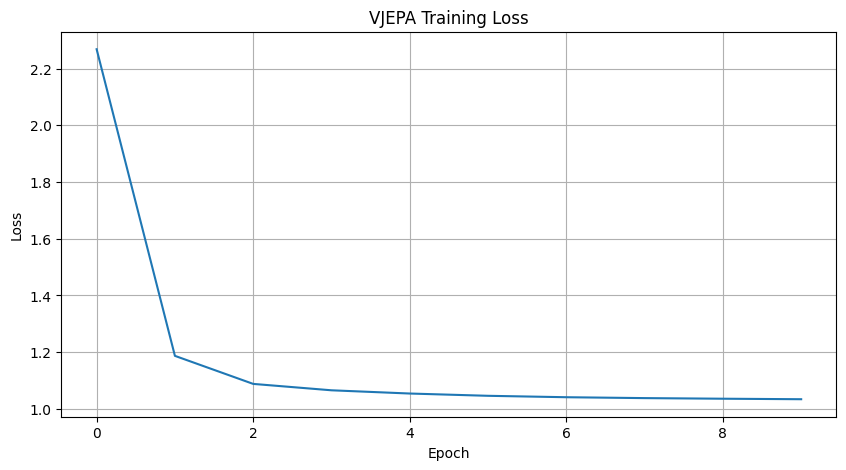

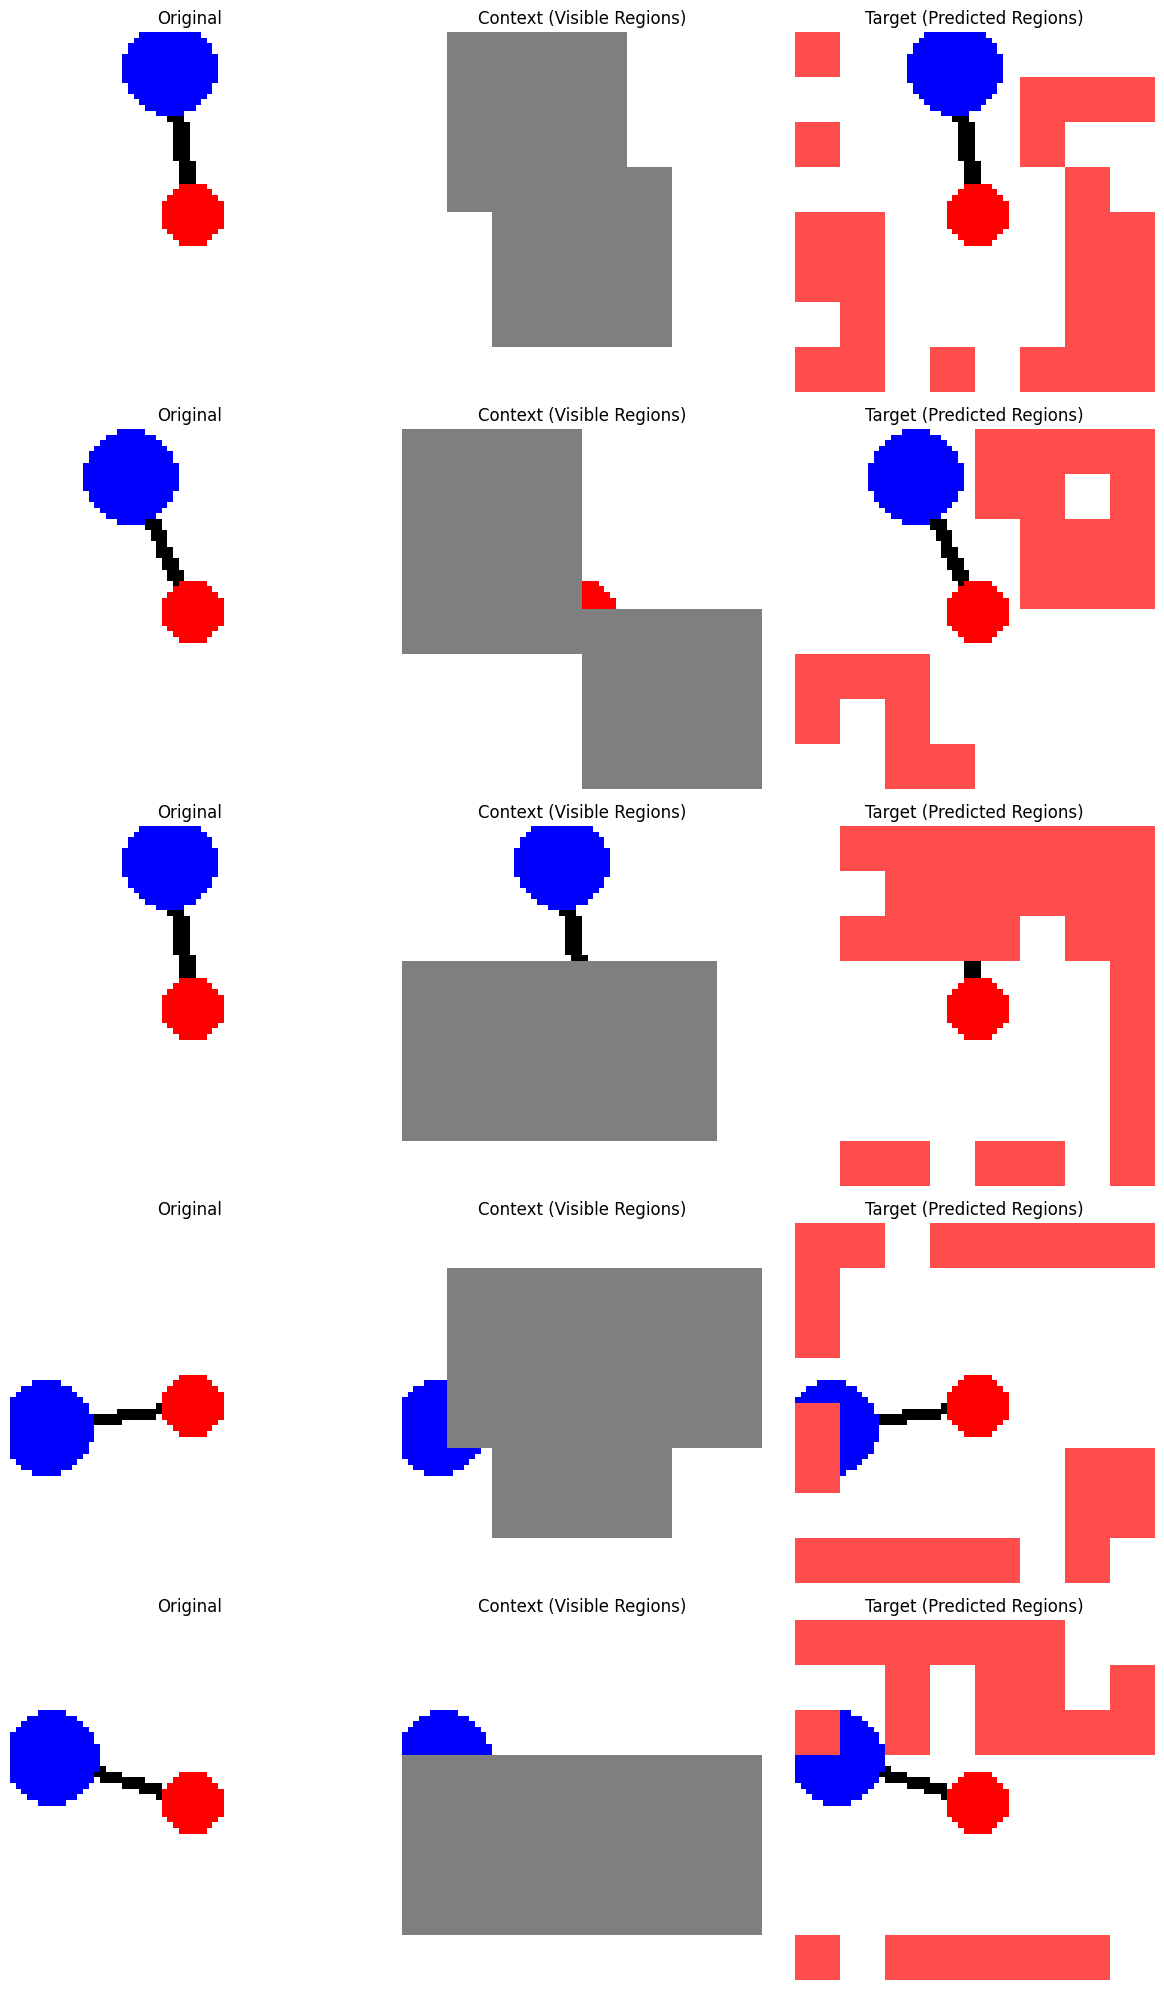

Training completed!


Extracting embeddings:   9%|▉         | 7/79 [00:01<00:12,  5.95it/s]



Latent -> Theta R²: 1.0000, MSE: 0.0001
Latent -> Omega R²: 0.2401, MSE: 7.2874


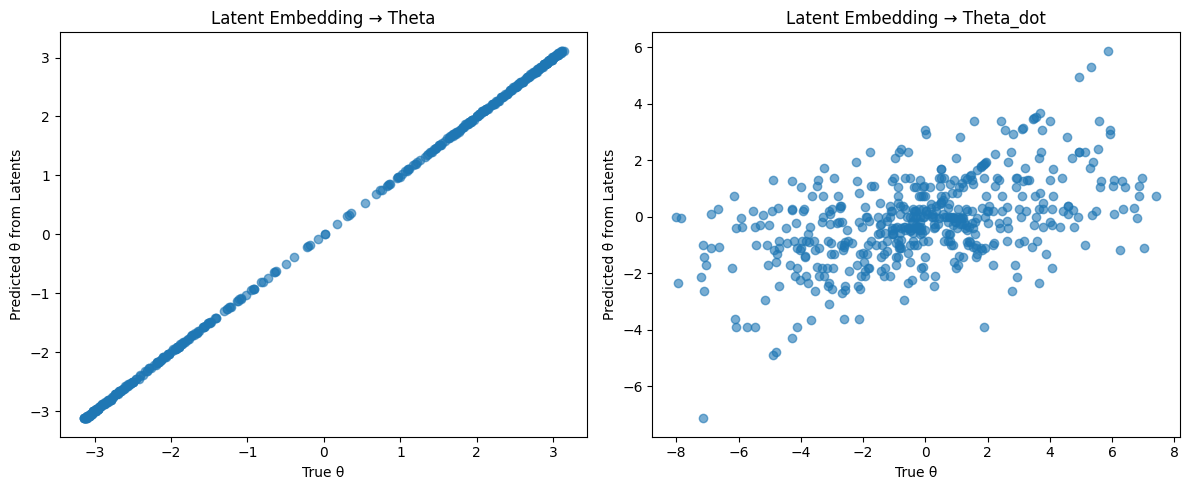

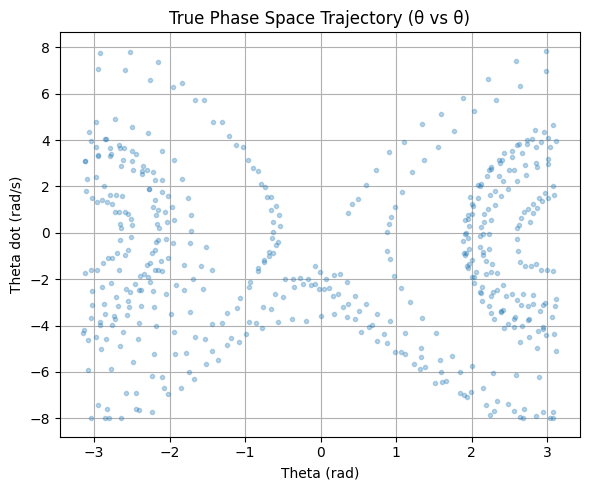

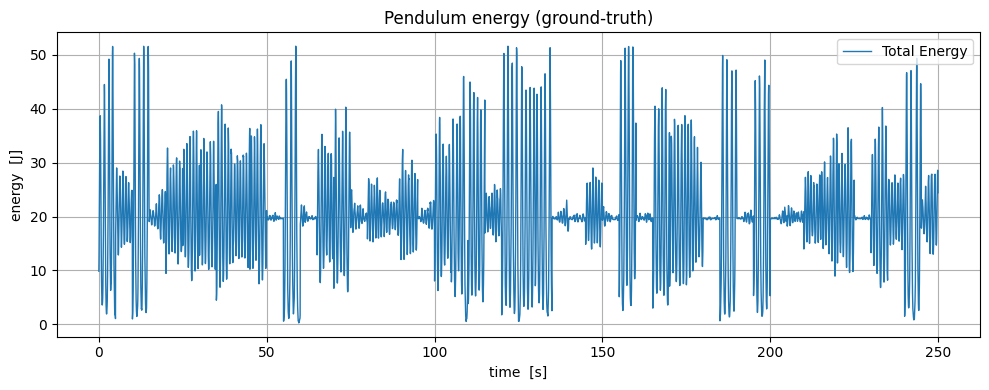

In [ ]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ============================
# 1. Data Collection and Preparation
# ============================

class PendulumDataset(Dataset):
    def __init__(self, num_episodes=100, episode_length=200, img_size=64, transform=None):
        """
        Dataset for pendulum images from OpenAI Gym

        Args:
            num_episodes: Number of episodes to collect
            episode_length: Length of each episode
            img_size: Size to resize images to
            transform: Additional transforms to apply
        """
        self.img_size = img_size
        self.transform = transform

        # Generate synthetic pendulum images
        self.generate_synthetic_pendulum_data(num_episodes, episode_length)

    def generate_synthetic_pendulum_data(self, num_episodes, episode_length):
        """Generate synthetic pendulum data using PIL"""
        print("Generating synthetic pendulum data...")
        self.images = []

        # Create environment to get pendulum dynamics
        env = gym.make('Pendulum-v1')

        # Set up parameters for drawing pendulum
        img_size = self.img_size
        pendulum_length = img_size * 0.4
        center_x, center_y = img_size // 2, img_size // 2

        self.images = []
        self.labels = []

        for episode in tqdm(range(num_episodes)):
            # Reset environment
            obs = env.reset()
            if isinstance(obs, tuple):
                obs = obs[0]  # New API returns (obs, info)

            # Extract theta from observation
            # In Pendulum-v1, obs[0] = cos(theta), obs[1] = sin(theta)
            theta = np.arctan2(obs[1], obs[0])

            for step in range(episode_length):
                # Take random action
                action = env.action_space.sample()

                # Step the environment
                step_result = env.step(action)

                # Handle different Gym API versions
                if len(step_result) == 4:  # Old API
                    obs, reward, done, _ = step_result
                else:  # New API
                    obs, reward, terminated, truncated, _ = step_result
                    done = terminated or truncated

                # Extract theta from observation
                theta = np.arctan2(obs[1], obs[0])
                omega = obs[2]

                # Draw pendulum image
                # Create a blank image
                img = Image.new('RGB', (img_size, img_size), color='white')
                draw = ImageDraw.Draw(img)

                # Calculate pendulum endpoint
                end_x = int(center_x + pendulum_length * np.sin(theta))
                end_y = int(center_y + pendulum_length * np.cos(theta))

                # Draw pendulum rod
                draw.line([(center_x, center_y), (end_x, end_y)], fill='black', width=3)

                # Draw pivot point
                draw.ellipse(
                    [(center_x-5, center_y-5), (center_x+5, center_y+5)],
                    fill='red'
                )

                # Draw bob
                draw.ellipse(
                    [(end_x-8, end_y-8), (end_x+8, end_y+8)],
                    fill='blue'
                )

                # Convert to numpy array
                img_array = np.array(img)

                # Add to dataset
                self.images.append(img_array)
                self.labels.append((theta, omega))

                if done:
                    break

        env.close()
        self.images = np.array(self.images)
        print(f"Dataset created with {len(self.images)} images")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]

        # Convert to tensor
        img = torch.from_numpy(img).float() / 255.0
        img = img.permute(2, 0, 1)  # Convert to CxHxW format

        if self.transform:
            img = self.transform(img)

        label = torch.tensor(label, dtype=torch.float32)

        return img, label


# ============================
# 2. VJEPA Architecture
# ============================

class PatchEmbed(nn.Module):
    """
    Image to Patch Embedding
    """
    def __init__(self, img_size=64, patch_size=8, in_chans=3, embed_dim=768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2

        # convolution to split the image into patches and project to embedding dim
        self.proj = nn.Conv2d(
            in_chans, embed_dim, kernel_size=patch_size, stride=patch_size
        )

    def forward(self, x):
        B, C, H, W = x.shape
        x = self.proj(x)  # (B, embed_dim, H/patch_size, W/patch_size)
        x = x.flatten(2)  # (B, embed_dim, n_patches)
        x = x.transpose(1, 2)  # (B, n_patches, embed_dim)
        return x

class TransformerEncoder(nn.Module):
    """
    Transformer encoder block
    """
    def __init__(self, embed_dim=768, depth=12, num_heads=12, mlp_ratio=4.0):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            layer = nn.TransformerEncoderLayer(
                d_model=embed_dim,
                nhead=num_heads,
                dim_feedforward=int(embed_dim * mlp_ratio),
                batch_first=True,
                norm_first=True
            )
            self.layers.append(layer)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class MaskingStrategy:
    """
    Handles masked prediction strategies for JEPA/VJEPA
    """
    def __init__(self, num_patches, mask_ratio=0.75, block_size=4):
        self.num_patches = num_patches
        self.mask_ratio = mask_ratio
        self.block_size = block_size

    def random_masking(self, batch_size):
        """Generate random masks for a batch"""
        n_keep = int(self.num_patches * (1 - self.mask_ratio))

        # For each sample, randomly select patches to keep
        noise = torch.rand(batch_size, self.num_patches, device=device)
        ids_shuffle = torch.argsort(noise, dim=1)
        ids_restore = torch.argsort(ids_shuffle, dim=1)

        # Determine which patches to keep
        mask = torch.ones([batch_size, self.num_patches], device=device)
        mask[:, :n_keep] = 0
        # Unshuffle to get the mask
        mask = torch.gather(mask, dim=1, index=ids_restore)

        return mask.bool()  # masked positions are True

    def block_masking(self, batch_size):
        """Generate block-wise masks"""
        grid_size = int(np.sqrt(self.num_patches))

        # Create empty masks
        masks = torch.zeros(batch_size, self.num_patches, device=device)

        for b in range(batch_size):
            # Number of blocks to mask
            n_blocks = int((self.num_patches * self.mask_ratio) / (self.block_size**2))

            # Randomly choose block starting positions
            for _ in range(n_blocks):
                # Choose random top-left corner for block
                h_start = np.random.randint(0, grid_size - self.block_size + 1)
                w_start = np.random.randint(0, grid_size - self.block_size + 1)

                # Mask all patches in this block
                for h in range(h_start, h_start + self.block_size):
                    for w in range(w_start, w_start + self.block_size):
                        patch_idx = h * grid_size + w
                        masks[b, patch_idx] = 1

        return masks.bool()  # masked positions are True

class VJEPA(nn.Module):
    """
    Vision-based Joint Embedding Predictive Architecture
    """
    def __init__(
        self,
        img_size=64,
        patch_size=8,
        in_chans=3,
        embed_dim=768,
        depth=12,
        num_heads=12,
        decoder_embed_dim=512,
        decoder_depth=8,
        decoder_num_heads=16,
        mlp_ratio=4.0,
        prediction_head_dim=384
    ):
        super().__init__()

        # Patch embedding
        self.patch_embed = PatchEmbed(
            img_size=img_size,
            patch_size=patch_size,
            in_chans=in_chans,
            embed_dim=embed_dim
        )

        # Number of patches - these are learnable
        self.num_patches = self.patch_embed.n_patches

        # Position embeddings
        self.pos_embed = nn.Parameter(
            torch.zeros(1, self.num_patches, embed_dim)
        )

        # Context encoder (f_θ)
        self.context_encoder = TransformerEncoder(
            embed_dim=embed_dim,
            depth=depth,
            num_heads=num_heads,
            mlp_ratio=mlp_ratio
        )

        # Target encoder (g_ϕ)
        self.target_encoder = TransformerEncoder(
            embed_dim=embed_dim,
            depth=depth,
            num_heads=num_heads,
            mlp_ratio=mlp_ratio
        )

        # Predictor network - map context features to target features
        self.predictor = nn.Sequential(
            nn.Linear(embed_dim, prediction_head_dim),
            nn.GELU(),
            nn.Linear(prediction_head_dim, embed_dim)
        )

        # Masking strategy for context/target separation
        self.masking = MaskingStrategy(self.num_patches)

        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        # Initialize position embeddings
        nn.init.normal_(self.pos_embed, std=0.02)

        # Initialize projection layers
        self.apply(self._init_weights_layer)

    def _init_weights_layer(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def forward_context(self, imgs, context_mask):
      """Process the context (visible) regions"""
      # Get patch embeddings
      x = self.patch_embed(imgs)  # [B, num_patches, embed_dim]

      # Add positional embeddings
      x = x + self.pos_embed  # [B, num_patches, embed_dim]

      B, N, D = x.shape
      unmasked_indices = ~context_mask  # [B, num_patches]

      # Collect unmasked patches per sample
      x_unmasked = []

      for i in range(B):
          patches = x[i][unmasked_indices[i]]  # [num_unmasked_i, D]

          # Pad to the max number of patches in the batch
          num_unmasked = patches.shape[0]
          padded = F.pad(patches, (0, 0, 0, N - num_unmasked))  # [N, D]
          x_unmasked.append(padded)

      x_unmasked = torch.stack(x_unmasked)  # [B, N, D]

      # Optionally, create attention masks if Transformer should ignore padded tokens

      # Encode context
      context_feats = self.context_encoder(x_unmasked)  # [B, N, D]

      return context_feats


    def forward_target(self, imgs, target_mask):
        """Process the target (masked) regions"""
        # Get patch embeddings
        x = self.patch_embed(imgs)  # [B, num_patches, embed_dim]

        # Add positional embeddings
        x = x + self.pos_embed

        B, N, D = x.shape
        masked_indices = target_mask  # [B, num_patches]

        x_masked = []

        for i in range(B):
            patches = x[i][masked_indices[i]]  # [num_masked_i, D]

            # Pad to full length N
            num_masked = patches.shape[0]
            padded = F.pad(patches, (0, 0, 0, N - num_masked))  # [N, D]
            x_masked.append(padded)

        x_masked = torch.stack(x_masked)  # [B, N, D]

        # Encode masked regions (targets)
        target_feats = self.target_encoder(x_masked)

        return target_feats


    def forward(self, imgs):
        """
        Forward pass of VJEPA

        Args:
            imgs: Batch of images [B, C, H, W]

        Returns:
            loss: VJEPA loss value
            pred: Predicted embeddings
            target: Target embeddings
        """
        B = imgs.shape[0]

        # Generate masks for context and target
        context_mask = self.masking.block_masking(B)
        target_mask = self.masking.random_masking(B)

        # Ensure context and target don't overlap
        overlap_mask = context_mask & target_mask
        target_mask = target_mask & ~overlap_mask

        # Forward pass through context encoder
        context_feats = self.forward_context(imgs, context_mask)

        # Forward pass through target encoder
        with torch.no_grad():  # Stop gradient for target encoder
            target_feats = self.forward_target(imgs, target_mask)

        # Generate predictions from context
        pred = self.predictor(context_feats)

        # Compute loss - mse loss between prediction and target
        loss = F.mse_loss(pred, target_feats)

        return loss, pred, target_feats

# ============================
# 3. Training Function
# ============================

def train_vjepa(model, theta_head, vec_field,
                train_loader, optimizer,
                num_epochs=100, log_interval=10,
                lambda_phys=1e-3, lambda_sup=1e-2):
    """
    Train VJEPA with an additional Hamiltonian physics loss.
    """
    model.train(); theta_head.train(); vec_field.train()
    losses = []

    print("Starting training…")
    for epoch in range(num_epochs):
        epoch_loss = 0.0

        for step, (imgs, labels) in enumerate(
                tqdm(train_loader, unit="batch",
                     desc=f"Epoch {epoch+1}/{num_epochs}")):

            imgs, labels = imgs.to(device), labels.to(device)   # labels = (θ, ω)

            # ─── 1. JEPA reconstruction loss ─────────────────────────
            loss_jepa, _, _ = model(imgs)

            # ─── 2. Latent → (θ̂ , ω̂)  (NO torch.no_grad!) ───────────
            lat = model.patch_embed(imgs) + model.pos_embed     # [B,N,D]
            lat = model.context_encoder(lat)                    # [B,N,D]
            z   = lat.mean(dim=1)                               # [B,D]
            theta_pred, omega_pred = theta_head(z).split(1, dim=1)  # [B,1] each

            # ─── 3. Physics loss  dq/dt ≈ ω_true ────────────────────
            state   = torch.cat([theta_pred, omega_pred], dim=1)      # [B,2]
            dqdt_pred = vec_field.time_derivative(state)[:, :1]       # (B,1)
            omega_true = labels[:, 1:2]                                # ω_true
            phys_loss  = F.mse_loss(dqdt_pred, omega_true)

            # optional direct θ supervision (helps the linear head converge)
            theta_true = labels[:, 0:1]
            sup_loss   = F.mse_loss(theta_pred, theta_true)

            # ─── 4. Total objective ─────────────────────────────────
            loss = loss_jepa + lambda_phys * phys_loss + lambda_sup * sup_loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            if step % log_interval == 0:
                tqdm.write(f"  step {step:04d}  "
                           f"jepa {loss_jepa.item():.4f}  "
                           f"phys {phys_loss.item():.4f}")

        avg = epoch_loss / len(train_loader)
        losses.append(avg)
        print(f"Epoch {epoch+1} complete — avg loss {avg:.4f}")

    return losses

# ============================
# 4. Visualization Functions
# ============================
def visualize_reconstructions(model, dataset, num_samples=5):
    """Visualize original images and their reconstructions"""
    model.eval()

    # Create a dataloader with batch size equal to num_samples
    loader = DataLoader(dataset, batch_size=num_samples, shuffle=True)
    imgs, _ = next(iter(loader))  # <-- FIXED: unpack the tuple
    imgs = imgs.to(device)

    # Get reconstructions
    with torch.no_grad():
        # Generate masks
        B = imgs.shape[0]
        context_mask = model.masking.block_masking(B)
        target_mask = model.masking.random_masking(B)

        # Ensure no overlap
        overlap_mask = context_mask & target_mask
        target_mask = target_mask & ~overlap_mask

        # Get features
        context_feats = model.forward_context(imgs, context_mask)
        pred = model.predictor(context_feats)

    # Visualize the results
    plt.figure(figsize=(12, 4 * num_samples))

    for i in range(num_samples):
        # Original image
        plt.subplot(num_samples, 3, i * 3 + 1)
        img = imgs[i].cpu().permute(1, 2, 0).numpy()
        plt.imshow(img)
        plt.title("Original")
        plt.axis('off')

        # Masked image (context)
        plt.subplot(num_samples, 3, i * 3 + 2)
        masked_img = imgs[i].clone().cpu()

        grid_size = int(np.sqrt(model.num_patches))
        mask_reshaped = context_mask[i].reshape(1, 1, grid_size, grid_size).float()
        mask_upsampled = F.interpolate(
            mask_reshaped,
            size=(imgs.shape[2], imgs.shape[3]),
            mode='nearest'
        ).squeeze()

        for c in range(3):
            masked_img[c][mask_upsampled.bool()] = 0.5  # Gray out masked areas

        plt.imshow(masked_img.permute(1, 2, 0).numpy())
        plt.title("Context (Visible Regions)")
        plt.axis('off')

        # Target image (highlight predicted regions)
        plt.subplot(num_samples, 3, i * 3 + 3)
        target_img = imgs[i].clone().cpu()

        target_mask_reshaped = target_mask[i].reshape(1, 1, grid_size, grid_size).float()
        target_mask_upsampled = F.interpolate(
            target_mask_reshaped,
            size=(imgs.shape[2], imgs.shape[3]),
            mode='nearest'
        ).squeeze()

        for c in range(3):
            if c == 0:  # Red channel
                target_img[c][target_mask_upsampled.bool()] = 1.0
            else:
                target_img[c][target_mask_upsampled.bool()] = 0.3

        plt.imshow(target_img.permute(1, 2, 0).numpy())
        plt.title("Target (Predicted Regions)")
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('vjepa_reconstructions.png')
    plt.show()


def plot_training_loss(losses):
    """Plot training loss over epochs"""
    plt.figure(figsize=(10, 5))
    plt.plot(losses)
    plt.title('VJEPA Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.savefig('vjepa_training_loss.png')
    plt.show()

# ============================
# 5. Main Execution
# ============================

def main():
    # Configuration
    batch_size = 32
    img_size = 64
    patch_size = 8
    embed_dim = 384  # Smaller for faster training
    depth = 6  # Smaller depth for faster training
    num_heads = 6
    prediction_head_dim = 192
    learning_rate = 1e-4
    num_epochs = 10

    # Create dataset
    dataset = PendulumDataset(num_episodes=50, episode_length=100, img_size=img_size)
    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)  # Set num_workers=0 for compatibility

    # Create model
    model = VJEPA(
        img_size=img_size,
        patch_size=patch_size,
        in_chans=3,
        embed_dim=embed_dim,
        depth=depth,
        num_heads=num_heads,
        decoder_embed_dim=embed_dim // 2,
        decoder_depth=4,
        decoder_num_heads=num_heads,
        mlp_ratio=4.0,
        prediction_head_dim=prediction_head_dim
    ).to(device)

    ######################################################################
    # (B)  immediately after you create the VJEPA model,                    │
    #      create a SINGLE linear mapping from latent → (θ̂ , ω̂).          │
    #      this will be trained jointly with V-JEPA and the HNN.            │
    ######################################################################
    latent_dim  = embed_dim              # = 384 in your config
    theta_head  = torch.nn.Linear(latent_dim, 2, bias=True).to(device)

    ######################################################################
    # (C)  instantiate an HNN ONCE  (again, right after model creation)
    ######################################################################
    vec_field = HNN(
        input_dim            = 2,            # (q, p)  where q = θ , p = ω
        differentiable_model = MLP(2, 256, 2),
        field_type           = 'solenoidal', # canonical Hamiltonian flow
        baseline             = False
    ).to(device)

    optimizer = optim.AdamW(
    list(model.parameters()) +
    list(theta_head.parameters()) +
    list(vec_field.parameters()),
    lr=learning_rate)

    # ------- training --------------------------------------------
    losses = train_vjepa(model, theta_head, vec_field,
                     train_loader, optimizer,
                     num_epochs=num_epochs)

    # Plot training loss
    plot_training_loss(losses)

    # Visualize reconstructions
    visualize_reconstructions(model, dataset)

    # Save final model
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, "vjepa_pendulum_final.pt")

    print("Training completed!")

    analyze_vjepa_latent_phase_relation(model,dataset )
    plot_true_phase_space(dataset)
    plot_energy_conservation(dataset)

if __name__ == "__main__":
    main()

In [ ]:
# ---------------------------------------------------------------
# Torch re-implementation of Miles Cranmer’s LNN (JAX → PyTorch)
# ---------------------------------------------------------------
class LNN(nn.Module):
    """
    Minimal PyTorch Lagrangian Neural Network.
    Learns a scalar L(q, v); returns Euler–Lagrange residual loss.
    """
    def __init__(self, input_dim, hidden_dim=256):
        # input dim - dimension of input qv concat
        # hidden dim - hidden size for mlp
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim), nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim), nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, qv):
        # forward pass through the network. take input tensor of shape  (B, 2d)
        # where d is dim of the sys(qv concatenated)
        # return scalar lagrangian val for each input in the batch
        return self.net(qv)

    def lagrangian_residual(self, q, v, dt=1.0):
        """
        Compute Euler–Lagrange residual loss for a batch of trajectories.
        q, v : (B, T, d)  – batch of trajectories (T≥2).
        Returns MSE of Euler–Lagrange residuals over B×(T-1) steps.
        """
        B, T, d = q.shape
        z   = torch.cat([q, v], dim=-1).reshape(B*T, -1).requires_grad_(True)
        L   = self.forward(z).sum()                    # scalar
        dLd  = torch.autograd.grad(L, z, create_graph=True)[0]
        dL_dq, dL_dv = dLd.split(d, dim=-1)
        dL_dq = dL_dq.reshape(B, T, d)
        dL_dv = dL_dv.reshape(B, T, d)

        # finite-difference time derivative of ∂L/∂v
        ddt_dLdv = (dL_dv[:,1:] - dL_dv[:,:-1]) / dt   # (B,T-1,d)
        res      = ddt_dLdv - dL_dq[:,:-1]             # (B,T-1,d)
        return (res**2).mean()

In [ ]:
def analyze_vjepa_latent_phase_relation(model, dataset,
                                        batch_size=64, num_samples=500):
    """
    Regression of V-JEPA latent vectors → (theta, omega).
    Works with the sequence-dataset (T ≥ 2).

    Take the trained v-jepa model. Take sequence dataset where each item is a sequence
    and a state.
    """
    model.eval()
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    latents, theta_list, omega_list = [], [], []
    collected = 0

    for seq, states in tqdm(loader, desc="extract"):
        # seq  : (B,T,C,H,W)   – take first frame
        imgs = seq[:, 0].to(next(model.parameters()).device)  # (B,C,H,W)
        theta = states[:, 0, 0].numpy()   # true θ at t=0
        omega = states[:, 0, 1].numpy()   # true ω at t=0

        with torch.no_grad():
            # forward pass through patch embedding
            x = model.patch_embed(imgs) + model.pos_embed        # (B,N,D)
            x = model.context_encoder(x)
            pooled = x.mean(1).cpu()                 # (B,D)

        latents.append(pooled)
        theta_list.extend(theta)
        omega_list.extend(omega)

        collected += imgs.size(0)
        if collected >= num_samples:
            break

    Z   = torch.cat(latents, 0).numpy()[:num_samples]
    θ   = np.array(theta_list)[:num_samples].reshape(-1, 1)
    ω   = np.array(omega_list)[:num_samples].reshape(-1, 1)

    # linear regressions
    reg_θ = LinearRegression().fit(Z, θ)
    reg_ω = LinearRegression().fit(Z, ω)

    θ̂ = reg_θ.predict(Z)
    ω̂ = reg_ω.predict(Z)

    print(f"θ  R²={r2_score(θ, θ̂):.4f},  MSE={mean_squared_error(θ, θ̂):.4e}")
    print(f"ω  R²={r2_score(ω, ω̂):.4f},  MSE={mean_squared_error(ω, ω̂):.4e}")

    # scatter plots
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1); plt.scatter(θ, θ̂, s=8, alpha=.6); plt.xlabel("true θ"); plt.ylabel("pred θ"); plt.grid()
    plt.subplot(1,2,2); plt.scatter(ω, ω̂, s=8, alpha=.6); plt.xlabel("true ω"); plt.ylabel("pred ω"); plt.grid()
    plt.suptitle("Latent → phase-space regression"); plt.tight_layout(); plt.show()

In [19]:
def plot_true_phase_space(dataset, num_samples=500):
    """Scatter of θ vs ω using every time-step until num_samples points."""
    theta_vals, omega_vals = [], []   # store theta and omega
    collected = 0
    for _, states in dataset:                 # states: (T,2)
        for t in range(states.shape[0]):
            theta_vals.append(states[t, 0].item())
            omega_vals.append(states[t, 1].item())
            collected += 1
            if collected >= num_samples:
                break
        if collected >= num_samples:
            break

    # create a scatter plot of theta v omega
    plt.figure(figsize=(6, 5))
    plt.plot(theta_vals, omega_vals, ".", alpha=0.4)
    plt.xlabel("theta (rad)")          # ← plain text avoids mathtext parser
    plt.ylabel("theta_dot (rad/s)")
    plt.title("True Phase-Space Trajectory")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [16]:
@torch.no_grad()
# plot the prediction vs true total energy for a single window (trajectory)

def plot_energy_model_vs_truth(model, theta_head,          # trained nets
                               dataset, win_idx=0, dt=0.05,
                               m=1.0, l=1.0, g=9.81):

    """
    • model        : trained VJEPA
    • theta_head   : trained latent→(θ,ω) linear layer
    • dataset      : PendulumDataset (windowed version)
    • win_idx      : which window to visualise (0 … len(dataset)-1)
    • dt           : seconds per frame (Gym default 0.05)
    """
    import numpy as np, matplotlib.pyplot as plt, torch

    model.eval(); theta_head.eval()

    # -------- get window ----------------------------------------
    imgs, states_true = dataset[win_idx]          # imgs: (T,C,H,W)
    T = imgs.shape[0]
    imgs = imgs.to(device)                        # move to GPU / CPU

    # -------- model prediction ----------------------------------
    # forward through patch embed + context encoder
    lat = model.patch_embed(imgs) + model.pos_embed        # (T,N,D)
    lat = model.context_encoder(lat)                       # (T,N,D)
    z   = lat.mean(dim=1)                                  # (T,D)
    theta_pred, omega_pred = theta_head(z).split(1, dim=1) # (T,1)

    theta_pred = theta_pred.squeeze(1).cpu().numpy()
    omega_pred = omega_pred.squeeze(1).cpu().numpy()

    # -------- ground truth --------------------------------------
    if isinstance(states_true, torch.Tensor):
        states_true = states_true.numpy()
    theta_true, omega_true = states_true[:,0], states_true[:,1]

    # -------- energies ------------------------------------------
    kin_pred  = 0.5 * m * (l**2) * omega_pred**2
    pot_pred  = m * g * l * (1 - np.cos(theta_pred))
    E_pred    = kin_pred + pot_pred

    kin_true  = 0.5 * m * (l**2) * omega_true**2
    pot_true  = m * g * l * (1 - np.cos(theta_true))
    E_true    = kin_true + pot_true

    t = np.arange(T) * dt

    # -------- plot ----------------------------------------------
    plt.figure(figsize=(12,4))
    plt.plot(t, E_true,  label="True Total E",   lw=1.5)
    plt.plot(t, E_pred,  label="Predicted Total E", lw=1.5, ls="--")
    plt.xlabel("time (s)"); plt.ylabel("energy (J)")
    plt.title("Pendulum Energy: model vs. ground truth")
    plt.legend(); plt.grid(True); plt.tight_layout()
    plt.show()

Using device: cpu
Generating pendulum trajectories …


  0%|          | 0/50 [00:00<?, ?it/s]/Users/panaschristou/miniforge3/envs/sys_dev/lib/python3.12/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|██████████| 50/50 [00:00<00:00, 139.80it/s]


Created 4900 windows (seq_len=3)
Starting training …


Epoch 1/2:   1%|          | 1/154 [00:01<04:00,  1.57s/batch]

step 0000 | jepa 1.2648 | phys 1.9701


Epoch 1/2:   7%|▋         | 11/154 [00:14<03:00,  1.26s/batch]

step 0010 | jepa 0.8838 | phys 0.1004


Epoch 1/2:  14%|█▎        | 21/154 [00:25<02:26,  1.10s/batch]

step 0020 | jepa 0.7318 | phys 0.5279


Epoch 1/2:  20%|██        | 31/154 [00:36<02:17,  1.12s/batch]

step 0030 | jepa 0.5629 | phys 0.0943


Epoch 1/2:  27%|██▋       | 41/154 [00:48<02:27,  1.30s/batch]

step 0040 | jepa 0.4405 | phys 0.0944


Epoch 1/2:  33%|███▎      | 51/154 [01:00<01:56,  1.13s/batch]

step 0050 | jepa 0.3695 | phys 0.0257


Epoch 1/2:  40%|███▉      | 61/154 [01:11<01:41,  1.10s/batch]

step 0060 | jepa 0.3229 | phys 0.0289


Epoch 1/2:  46%|████▌     | 71/154 [01:22<01:26,  1.04s/batch]

step 0070 | jepa 0.2953 | phys 0.0179


Epoch 1/2:  53%|█████▎    | 81/154 [01:32<01:16,  1.05s/batch]

step 0080 | jepa 0.2847 | phys 0.0167


Epoch 1/2:  59%|█████▉    | 91/154 [01:42<01:01,  1.02batch/s]

step 0090 | jepa 0.2767 | phys 0.0123


Epoch 1/2:  66%|██████▌   | 101/154 [01:52<00:51,  1.03batch/s]

step 0100 | jepa 0.2691 | phys 0.0133


Epoch 1/2:  72%|███████▏  | 111/154 [02:02<00:42,  1.01batch/s]

step 0110 | jepa 0.2631 | phys 0.0274


Epoch 1/2:  79%|███████▊  | 121/154 [02:12<00:32,  1.03batch/s]

step 0120 | jepa 0.2616 | phys 0.0221


Epoch 1/2:  85%|████████▌ | 131/154 [02:21<00:22,  1.03batch/s]

step 0130 | jepa 0.2560 | phys 0.0237


Epoch 1/2:  92%|█████████▏| 141/154 [02:32<00:14,  1.11s/batch]

step 0140 | jepa 0.2516 | phys 0.0100


Epoch 1/2:  98%|█████████▊| 151/154 [02:43<00:03,  1.07s/batch]

step 0150 | jepa 0.2462 | phys 0.0127


Epoch 1/2: 100%|██████████| 154/154 [02:46<00:00,  1.08s/batch]


Epoch 1 avg loss 0.4360


Epoch 2/2:   1%|          | 1/154 [00:01<02:52,  1.13s/batch]

step 0000 | jepa 0.2390 | phys 0.0094


Epoch 2/2:   7%|▋         | 11/154 [00:11<02:32,  1.06s/batch]

step 0010 | jepa 0.2358 | phys 0.0128


Epoch 2/2:  14%|█▎        | 21/154 [00:25<02:47,  1.26s/batch]

step 0020 | jepa 0.2307 | phys 0.0179


Epoch 2/2:  20%|██        | 31/154 [00:36<02:07,  1.04s/batch]

step 0030 | jepa 0.2238 | phys 0.0112


Epoch 2/2:  27%|██▋       | 41/154 [00:46<01:53,  1.00s/batch]

step 0040 | jepa 0.2317 | phys 0.0043


Epoch 2/2:  33%|███▎      | 51/154 [00:56<01:44,  1.01s/batch]

step 0050 | jepa 0.2236 | phys 0.0060


Epoch 2/2:  40%|███▉      | 61/154 [01:06<01:29,  1.03batch/s]

step 0060 | jepa 0.2229 | phys 0.0038


Epoch 2/2:  46%|████▌     | 71/154 [01:16<01:22,  1.01batch/s]

step 0070 | jepa 0.2206 | phys 0.0085


Epoch 2/2:  53%|█████▎    | 81/154 [01:26<01:20,  1.11s/batch]

step 0080 | jepa 0.2185 | phys 0.0050


Epoch 2/2:  59%|█████▉    | 91/154 [01:38<01:14,  1.17s/batch]

step 0090 | jepa 0.2204 | phys 0.0076


Epoch 2/2:  66%|██████▌   | 101/154 [01:49<00:59,  1.13s/batch]

step 0100 | jepa 0.2208 | phys 0.0054


Epoch 2/2:  72%|███████▏  | 111/154 [02:01<00:50,  1.17s/batch]

step 0110 | jepa 0.2175 | phys 0.0072


Epoch 2/2:  79%|███████▊  | 121/154 [02:15<00:42,  1.29s/batch]

step 0120 | jepa 0.2183 | phys 0.0070


Epoch 2/2:  85%|████████▌ | 131/154 [02:27<00:26,  1.15s/batch]

step 0130 | jepa 0.2154 | phys 0.0029


Epoch 2/2:  92%|█████████▏| 141/154 [02:39<00:14,  1.14s/batch]

step 0140 | jepa 0.2231 | phys 0.0029


Epoch 2/2:  98%|█████████▊| 151/154 [02:50<00:03,  1.13s/batch]

step 0150 | jepa 0.2181 | phys 0.0045


Epoch 2/2: 100%|██████████| 154/154 [02:53<00:00,  1.12s/batch]

Epoch 2 avg loss 0.2241


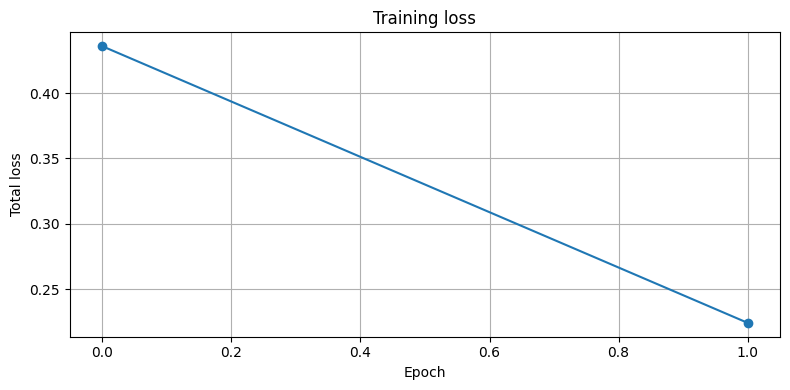

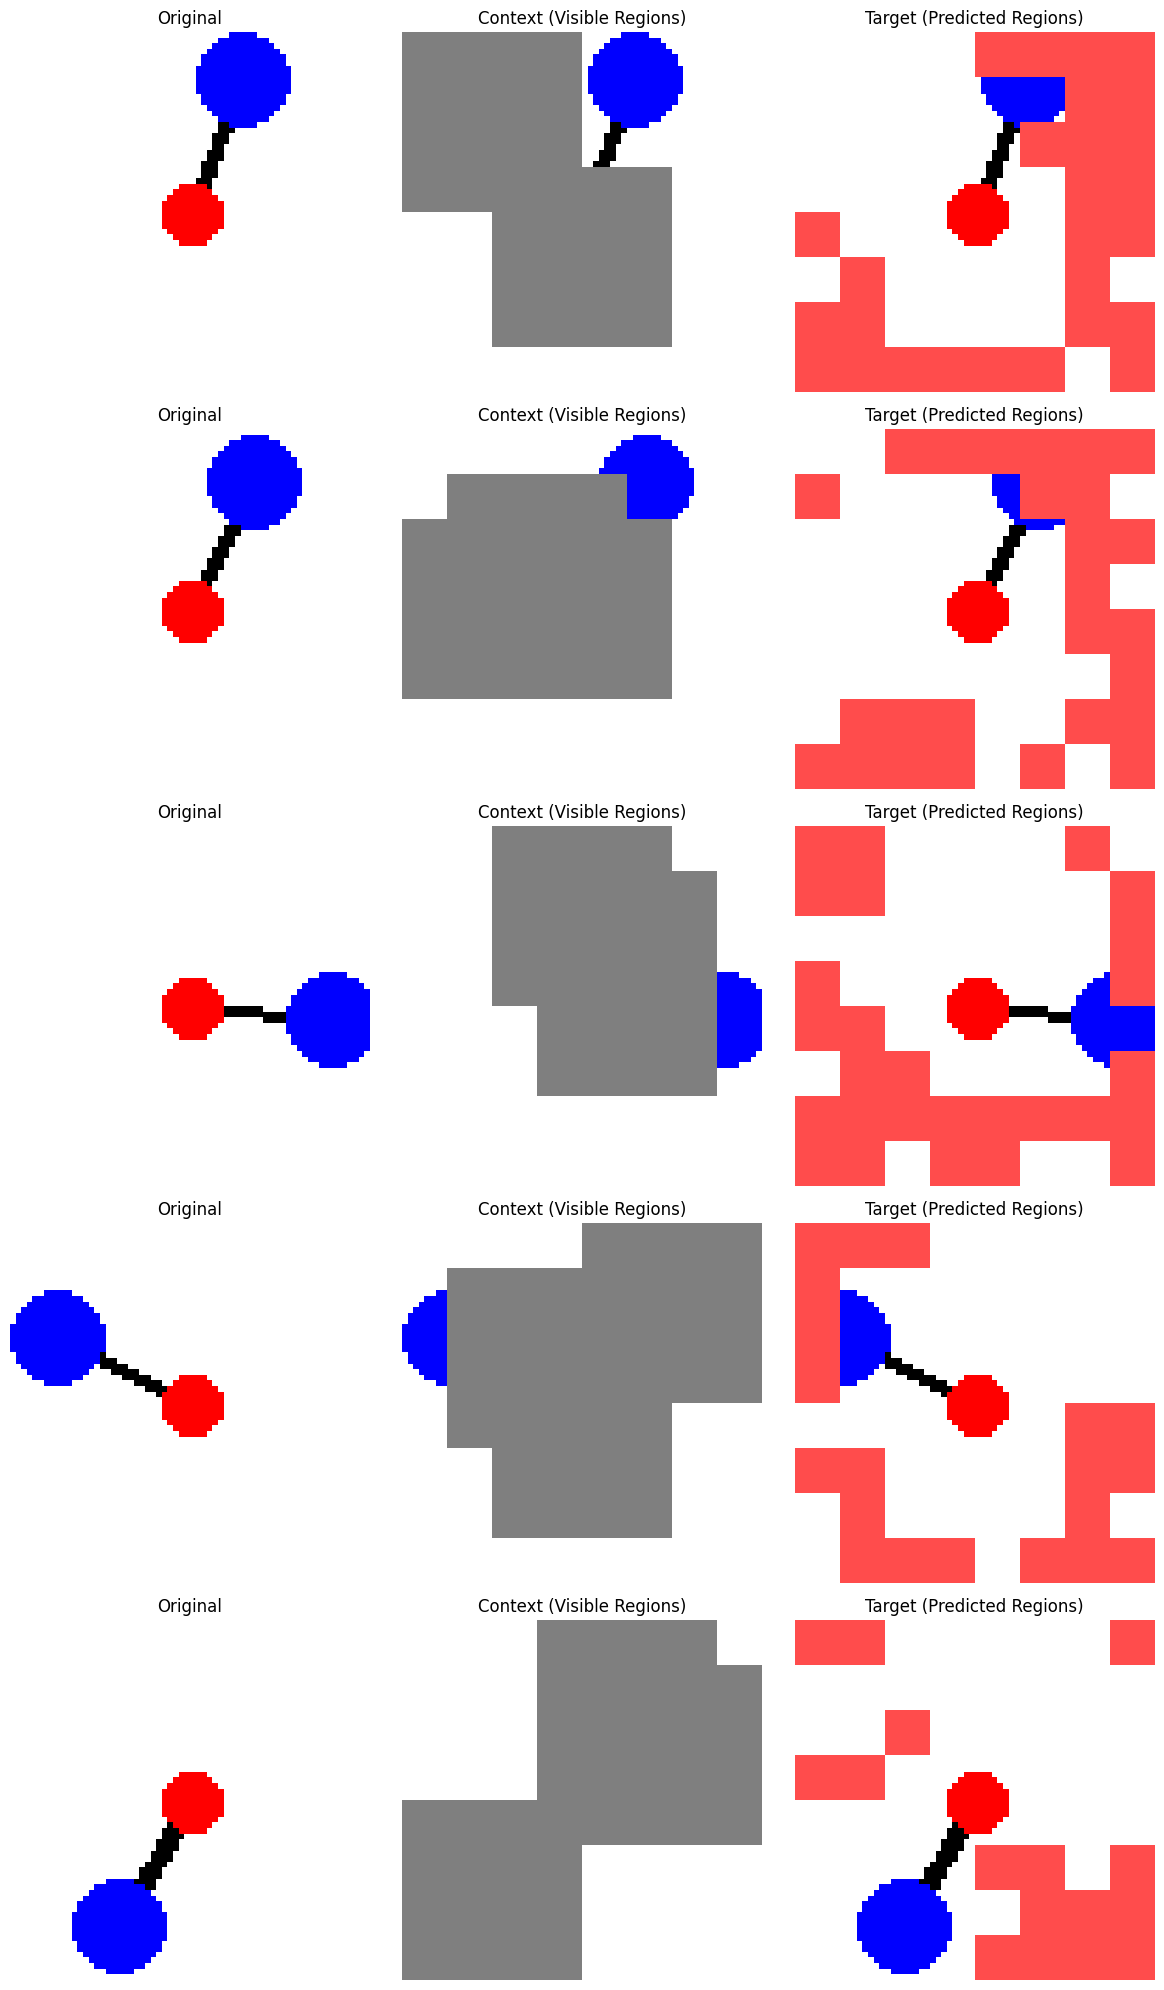

Training completed!


extract:   9%|▉         | 7/77 [00:01<00:14,  4.69it/s]


θ  R²=1.0000,  MSE=8.3748e-05
ω  R²=0.2419,  MSE=8.8211e+00


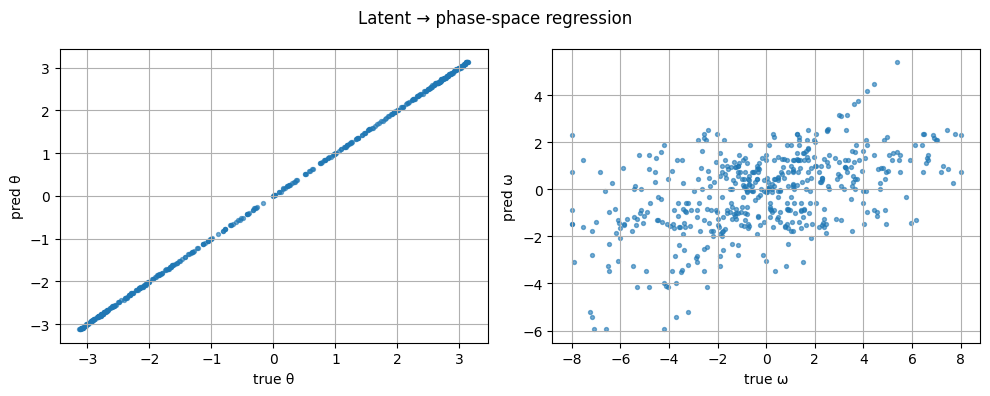

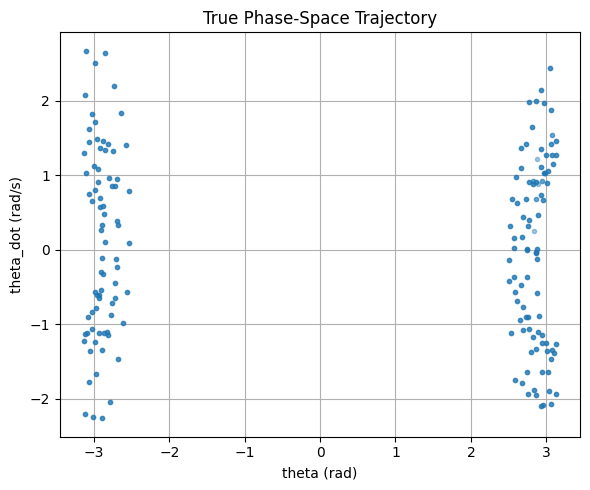

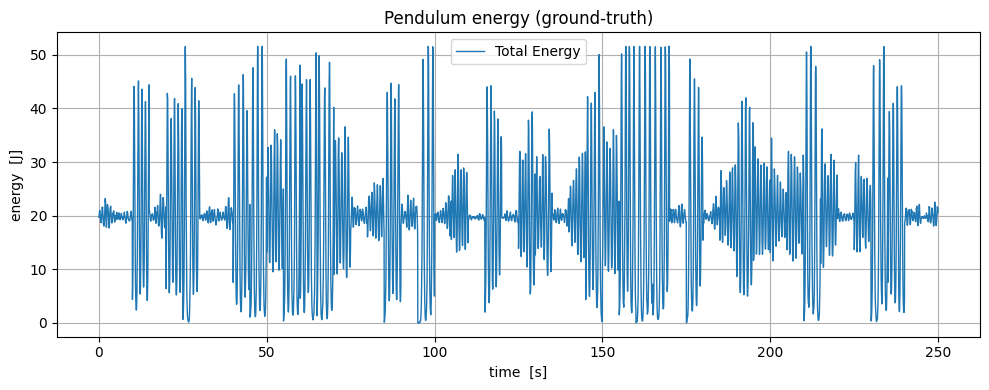

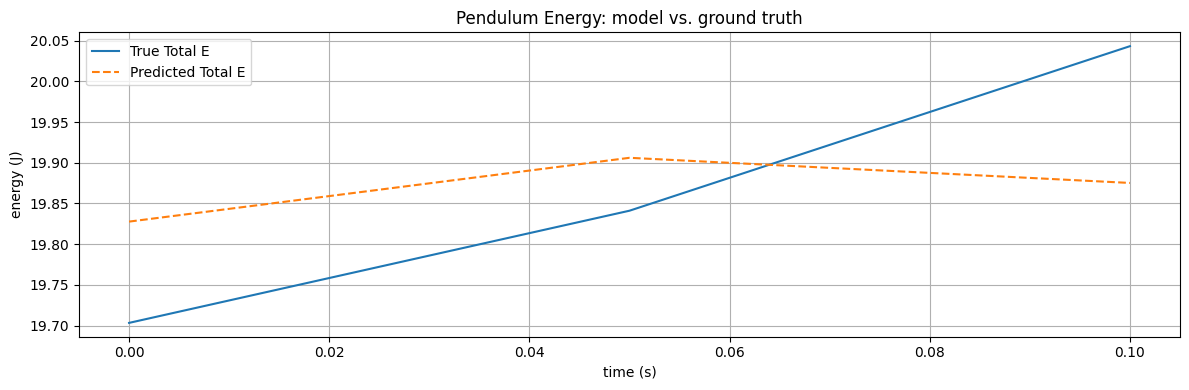

In [ ]:
#!/usr/bin/env python3
# -------------------------------------------------------------
# Vision-JEPA + Lagrangian Neural Network on Pendulum (physics-correct)
# -------------------------------------------------------------

# ------------------------------------------------------------------
# 0 · Reproducibility & Device
# ------------------------------------------------------------------
torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ============================
# 1. Data Collection / Preparation
# ============================
class PendulumDataset(Dataset):
    """
    Returns image *sequences* of length `seq_len` (T,C,H,W) and the
    corresponding (theta, omega) sequence (T,2).

    This allows the LNN to compute a proper Euler–Lagrange residual.
    """
    def __init__(
        self,
        num_episodes: int = 100,
        episode_length: int = 200,
        img_size: int = 64,
        seq_len: int = 3,
        transform=None,
    ):
        assert seq_len >= 2, "seq_len must be ≥ 2 for physics loss"
        self.img_size = img_size
        self.seq_len  = seq_len
        self.transform = transform

        self.frames  : list[np.ndarray] = []  # flattened RGB images
        self.states  : list[tuple[float,float]] = []  # flattened (θ, ω)
        self.indices : list[int] = []  # sample-idx -> start idx of window

        self._generate(num_episodes, episode_length)

    # -------------- synthetic pendulum renderer ------------------
    def _render_pendulum(self, theta: float) -> np.ndarray:
        L   = self.img_size * 0.4
        cx  = cy = self.img_size // 2
        ex  = int(cx + L * np.sin(theta))
        ey  = int(cy + L * np.cos(theta))

        img = Image.new("RGB", (self.img_size, self.img_size), "white")
        drw = ImageDraw.Draw(img)
        drw.line([(cx, cy), (ex, ey)], fill="black", width=3)
        drw.ellipse([(cx-5, cy-5), (cx+5, cy+5)], fill="red")
        drw.ellipse([(ex-8, ey-8), (ex+8, ey+8)], fill="blue")
        return np.asarray(img).copy()

    # -------------- generate roll-outs ---------------------------
    def _generate(self, n_episodes: int, epi_len: int):
        print("Generating pendulum trajectories …")
        env = gym.make("Pendulum-v1")

        for _ in tqdm(range(n_episodes)):
            obs, _   = env.reset()
            theta    = np.arctan2(obs[1], obs[0])

            ep_imgs   : list[np.ndarray] = []
            ep_states : list[tuple[float,float]] = []

            for _ in range(epi_len):
                action = env.action_space.sample()
                obs, _, terminated, truncated, _ = env.step(action)
                if terminated or truncated:
                    break

                theta = np.arctan2(obs[1], obs[0])
                omega = float(obs[2])

                ep_imgs.append(self._render_pendulum(theta))
                ep_states.append((theta, omega))

            # slide a window of length seq_len
            for t0 in range(0, len(ep_imgs) - self.seq_len + 1):
                self.indices.append(len(self.frames) + t0)

            self.frames.extend(ep_imgs)
            self.states.extend(ep_states)

        env.close()
        print(f"Created {len(self.indices)} windows (seq_len={self.seq_len})")

    # -------------- Dunder methods -------------------------------
    def __len__(self) -> int:
        return len(self.indices)

    def __getitem__(self, idx: int):
        start = self.indices[idx]
        end   = start + self.seq_len

        imgs = [
            torch.from_numpy(self.frames[i]).float().permute(2, 0, 1) / 255.0
            for i in range(start, end)
        ]
        imgs = torch.stack(imgs)            # (T,C,H,W)

        states = torch.tensor(
            self.states[start:end], dtype=torch.float32
        )                                    # (T,2)  θ, ω

        if self.transform is not None:
            imgs = self.transform(imgs)

        return imgs, states

# ============================
# 2. V-JEPA backbone
# ============================
class PatchEmbed(nn.Module):
    """Image → patch embeddings"""
    def __init__(self, img_size=64, patch_size=8, in_chans=3, embed_dim=384):
        super().__init__()
        # convolution patch embedding
        self.n_patches = (img_size // patch_size) ** 2
        self.proj      = nn.Conv2d(in_chans, embed_dim,
                                   kernel_size=patch_size,
                                   stride=patch_size)
    def forward(self, x):
        x = self.proj(x)                     # (B,embed,H',W')
        x = x.flatten(2).transpose(1, 2)     # (B,N,embed)
        return x

class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim, depth, num_heads, mlp_ratio):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.TransformerEncoderLayer(
                embed_dim,
                num_heads,
                int(embed_dim * mlp_ratio),
                batch_first=True,
                norm_first=True
            ) for _ in range(depth)
        ])
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class MaskingStrategy:
    """Block + random masking identical to original V-JEPA impl."""
    def __init__(self, num_patches, mask_ratio=0.75, block_size=4):
        self.N  = num_patches
        self.r  = mask_ratio
        self.bs = block_size

    def random_masking(self, B):
        n_keep = int(self.N * (1 - self.r))
        noise  = torch.rand(B, self.N, device=device)
        ids    = torch.argsort(noise, dim=1)
        restore= torch.argsort(ids , dim=1)
        mask   = torch.ones(B, self.N, device=device)
        mask[:, :n_keep] = 0
        mask   = torch.gather(mask, 1, restore)
        return mask.bool()

    def block_masking(self, B):
        grid  = int(np.sqrt(self.N))
        masks = torch.zeros(B, self.N, device=device)
        n_blk = int((self.N * self.r) / (self.bs ** 2))
        for b in range(B):
            for _ in range(n_blk):
                h0 = np.random.randint(0, grid - self.bs + 1)
                w0 = np.random.randint(0, grid - self.bs + 1)
                for h in range(h0, h0 + self.bs):
                    for w in range(w0, w0 + self.bs):
                        masks[b, h * grid + w] = 1
        return masks.bool()

class VJEPA(nn.Module):
    """
    Vision-based Joint Embedding Predictive Architecture
    (unchanged naming; context / target encoders etc.)
    """
    def __init__(
        self,
        img_size=64,
        patch_size=8,
        in_chans=3,
        embed_dim=384,
        depth=6,
        num_heads=6,
        mlp_ratio=4.0,
        prediction_head_dim=192,
    ):
        super().__init__()
        self.patch_embed = PatchEmbed(img_size, patch_size, in_chans, embed_dim)
        self.num_patches = self.patch_embed.n_patches
        self.pos_embed   = nn.Parameter(torch.zeros(1, self.num_patches, embed_dim))

        self.context_encoder = TransformerEncoder(
            embed_dim, depth, num_heads, mlp_ratio
        )
        self.target_encoder  = TransformerEncoder(
            embed_dim, depth, num_heads, mlp_ratio
        )

        self.predictor = nn.Sequential(
            nn.Linear(embed_dim, prediction_head_dim),
            nn.GELU(),
            nn.Linear(prediction_head_dim, embed_dim)
        )

        self.masking = MaskingStrategy(self.num_patches)
        nn.init.normal_(self.pos_embed, std=0.02)

    # ---------- helpers ----------
    def forward_context(self, imgs, context_mask):
        x = self.patch_embed(imgs) + self.pos_embed  # (B,N,D)
        B, N, D = x.shape
        keep    = ~context_mask
        out     = torch.stack([
            F.pad(x[i][keep[i]], (0, 0, 0, N - keep[i].sum()))
            for i in range(B)
        ])
        return self.context_encoder(out)

    def forward_target(self, imgs, target_mask):
        x = self.patch_embed(imgs) + self.pos_embed
        B, N, D = x.shape
        out = torch.stack([
            F.pad(x[i][target_mask[i]], (0, 0, 0, N - target_mask[i].sum()))
            for i in range(B)
        ])
        return self.target_encoder(out)

    # ---------- main forward ----------
    def forward(self, imgs):
        """
        Returns:
            loss  : MSE between predictor(ctx) and target_feats
            pred  : predicted embeddings
            target: target embeddings
        """
        B = imgs.size(0)
        cmask = self.masking.block_masking(B)
        tmask = self.masking.random_masking(B) & ~cmask

        ctx_feats = self.forward_context(imgs, cmask)
        with torch.no_grad():
            tgt_feats = self.forward_target(imgs, tmask)

        pred = self.predictor(ctx_feats)
        loss = F.mse_loss(pred, tgt_feats)

        return loss, pred, tgt_feats

# ============================
# 3. Lagrangian Neural Network
# ============================
class LNN(nn.Module):
    """
    Minimal PyTorch port of Miles Cranmer's LNN.
    Learns scalar L(q,v); physics loss is Euler–Lagrange residual.
    """
    def __init__(self, input_dim, hidden_dim=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim), nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim), nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, qv):                     # (B,2d) → scalar L
        return self.net(qv)

    def lagrangian_residual(self, q, v, dt=0.01):
        """
        q, v : (B, T, d) tensors with T ≥ 2.
        Returns mean-squared Euler–Lagrange residual over (B,T-1,d).
        """
        B, T, d = q.shape
        z   = torch.cat([q, v], dim=-1).reshape(B*T, -1).requires_grad_(True)
        L   = self.forward(z).sum()
        dLd = torch.autograd.grad(L, z, create_graph=True)[0]
        dLdq, dLdv = dLd.split(d, dim=-1)
        dLdq = dLdq.view(B, T, d)
        dLdv = dLdv.view(B, T, d)

        ddt_dLdv = (dLdv[:, 1:] - dLdv[:, :-1]) / dt  # (B,T-1,d)
        residual = ddt_dLdv - dLdq[:, :-1]           # Euler–Lagrange
        return (residual ** 2).mean()

# ============================
# 4. Training Function
# ============================

# Main training loop for VJEPA + LNN
    # For each batch:
    #   - Compute JEPA loss (first frame)
    #   - Predict (theta, omega) from latent
    #   - Compute LNN physics loss over trajectory
    #   - Optionally supervise theta at t=0
    #   - Combine losses and optimize

def train_vjepa(
    model,
    theta_head,
    lnn_net,
    train_loader,
    optimizer,
    num_epochs=10,
    log_interval=10,
    lambda_phys=1e-3,
    lambda_sup=1e-2,
):
    model.train()
    theta_head.train()
    lnn_net.train()
    losses = []

    print("Starting training …")
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for step, (imgs_seq, states_seq) in enumerate(
            tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")
        ):
            imgs_seq   = imgs_seq.to(device)    # (B,T,C,H,W)
            theta_seq  = states_seq[:, :, 0:1].to(device)  # (B,T,1)
            omega_seq  = states_seq[:, :, 1:2].to(device)  # (B,T,1)

            # ----- JEPA loss on first frame only -----
            imgs0 = imgs_seq[:, 0]               # (B,C,H,W)
            loss_jepa, _, _ = model(imgs0)

            # ----- latent → (θ̂, ω̂) (single frame) -----
            lat = model.patch_embed(imgs0) + model.pos_embed  # (B,N,D)
            lat = model.context_encoder(lat)                   # (B,N,D)
            z   = lat.mean(dim=1)                              # (B,D)
            theta_hat, omega_hat = theta_head(z).split(1, dim=1)

            # ----- physics loss on true trajectory -----
            phys_loss = lnn_net.lagrangian_residual(theta_seq, omega_seq)

            # ----- optional supervised θ loss (t=0) -----
            sup_loss = F.mse_loss(theta_hat, theta_seq[:, 0])

            # ----- total -----
            loss = (
                loss_jepa
                + lambda_phys * phys_loss
                + lambda_sup  * sup_loss
            )
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            if step % log_interval == 0:
                tqdm.write(
                    f"step {step:04d} | jepa {loss_jepa.item():.4f} "
                    f"| phys {phys_loss.item():.4f}"
                )

        avg = epoch_loss / len(train_loader)
        losses.append(avg)
        print(f"Epoch {epoch+1} avg loss {avg:.4f}")
    return losses

def visualize_reconstructions(model, dataset, num_samples=5):
    """Show original, context-masked and target-masked frames."""
    model.eval()

    loader = DataLoader(dataset, batch_size=num_samples, shuffle=True)
    seq, _ = next(iter(loader))          # seq: (B,T,C,H,W)
    imgs   = seq[:, 0].to(device)        # take frame t=0 → (B,C,H,W)

    with torch.no_grad():
        B = imgs.size(0)
        context_mask = model.masking.block_masking(B)
        target_mask  = model.masking.random_masking(B) & ~context_mask
        context_feats = model.forward_context(imgs, context_mask)
        pred = model.predictor(context_feats)

    # Visualize the results
    plt.figure(figsize=(12, 4 * num_samples))

    for i in range(num_samples):
        # Original image
        plt.subplot(num_samples, 3, i * 3 + 1)
        img = imgs[i].cpu().permute(1, 2, 0).numpy()
        plt.imshow(img)
        plt.title("Original")
        plt.axis('off')

        # Masked image (context)
        plt.subplot(num_samples, 3, i * 3 + 2)
        masked_img = imgs[i].clone().cpu()

        grid_size = int(np.sqrt(model.num_patches))
        mask_reshaped = context_mask[i].reshape(1, 1, grid_size, grid_size).float()
        mask_upsampled = F.interpolate(
            mask_reshaped,
            size=(imgs.shape[2], imgs.shape[3]),
            mode='nearest'
        ).squeeze()

        for c in range(3):
            masked_img[c][mask_upsampled.bool()] = 0.5  # Gray out masked areas

        plt.imshow(masked_img.permute(1, 2, 0).numpy())
        plt.title("Context (Visible Regions)")
        plt.axis('off')

        # Target image (highlight predicted regions)
        plt.subplot(num_samples, 3, i * 3 + 3)
        target_img = imgs[i].clone().cpu()

        target_mask_reshaped = target_mask[i].reshape(1, 1, grid_size, grid_size).float()
        target_mask_upsampled = F.interpolate(
            target_mask_reshaped,
            size=(imgs.shape[2], imgs.shape[3]),
            mode='nearest'
        ).squeeze()

        for c in range(3):
            if c == 0:  # Red channel
                target_img[c][target_mask_upsampled.bool()] = 1.0
            else:
                target_img[c][target_mask_upsampled.bool()] = 0.3

        plt.imshow(target_img.permute(1, 2, 0).numpy())
        plt.title("Target (Predicted Regions)")
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('vjepa_reconstructions.png')
    plt.show()

# ============================
# 5. Simple loss plot helper
# ============================
def plot_training_loss(loss_list):
    plt.figure(figsize=(8,4))
    plt.plot(loss_list, marker="o")
    plt.xlabel("Epoch")
    plt.ylabel("Total loss")
    plt.title("Training loss")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# ============================
# 7. Main
# ============================
def main():
    # ---- config ----
    batch_size    = 32
    img_size      = 64
    patch_size    = 8
    embed_dim     = 384
    depth         = 6
    num_heads     = 6
    pred_head_dim = 192
    learning_rate = 1e-4
    num_epochs    = 2
    seq_len       = 3

    # ---- dataset & loader ----
    dataset = PendulumDataset(
        num_episodes=50,
        episode_length=100,
        img_size=img_size,
        seq_len=seq_len
    )
    train_loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
        pin_memory=False,
    )

    # ---- models ----
    model = VJEPA(
        img_size         = img_size,
        patch_size       = patch_size,
        in_chans         = 3,
        embed_dim        = embed_dim,
        depth            = depth,
        num_heads        = num_heads,
        mlp_ratio        = 4.0,
        prediction_head_dim = pred_head_dim,
    ).to(device)

    theta_head = nn.Linear(embed_dim, 2).to(device)
    lnn_net    = LNN(input_dim=2, hidden_dim=256).to(device)

    # ---- optimiser ----
    optimizer = optim.AdamW(
        list(model.parameters())
        + list(theta_head.parameters())
        + list(lnn_net.parameters()),
        lr=learning_rate)

    # ───────────────────────────
    # 6 · Training
    # ───────────────────────────
    losses = train_vjepa(
        model, theta_head, lnn_net,
        train_loader, optimizer,
        num_epochs=num_epochs
    )

    plot_training_loss(losses)
    visualize_reconstructions(model, dataset)

    # save checkpoint
    torch.save({
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
    }, "vjepa_pendulum_final.pt")

    print("Training completed!")
    analyze_vjepa_latent_phase_relation(model, dataset)
    plot_true_phase_space(dataset)
    plot_energy_conservation(dataset)   # uncomment if desired
    plot_energy_model_vs_truth(
    model,            # your trained VJEPA
    theta_head,       # trained latent→(θ,ω) layer
    dataset,
    win_idx=0         # pick any window index you like
)


if __name__ == "__main__":
    main()

In [17]:
def analyze_vjepa_latent_phase_relation(model, dataset,
                                        batch_size=64, num_samples=500):
    """
    Fit two linear regressors:
        V-JEPA latent  →  theta , omega      (using frame t = 0 only)
    Prints R² & MSE, plus a scatter plot.
    """
    model.eval()
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    latents, theta_list, omega_list = [], [], []
    collected = 0

    for seq, states in tqdm(loader, desc="extract"):
        # seq   (B,T,C,H,W) — take first frame
        imgs = seq[:, 0].to(next(model.parameters()).device)      # (B,C,H,W)
        states = states.cpu()          # ← FIX: ensure on CPU for .numpy()
        theta  = states[:, 0, 0].numpy()
        omega  = states[:, 0, 1].numpy()

        with torch.no_grad():
            x = model.patch_embed(imgs) + model.pos_embed         # (B,N,D)
            x = model.context_encoder(x)
            pooled = x.mean(1).cpu()                              # (B,D)

        latents.append(pooled)
        theta_list.extend(theta)
        omega_list.extend(omega)

        collected += imgs.size(0)
        if collected >= num_samples:
            break

    Z = torch.cat(latents, 0).numpy()[:num_samples]
    θ = np.array(theta_list)[:num_samples].reshape(-1, 1)         # ← trim
    ω = np.array(omega_list)[:num_samples].reshape(-1, 1)

    # linear regressions
    reg_θ = LinearRegression().fit(Z, θ)
    reg_ω = LinearRegression().fit(Z, ω)

    θ̂ = reg_θ.predict(Z)
    ω̂ = reg_ω.predict(Z)

    print(f"θ  R² = {r2_score(θ, θ̂):.4f} ,  MSE = {mean_squared_error(θ, θ̂):.4e}")
    print(f"ω  R² = {r2_score(ω, ω̂):.4f} ,  MSE = {mean_squared_error(ω, ω̂):.4e}")

    # scatter plots
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.scatter(θ, θ̂, s=8, alpha=.6)
    plt.xlabel("true θ"); plt.ylabel("pred θ"); plt.grid()

    plt.subplot(1,2,2)
    plt.scatter(ω, ω̂, s=8, alpha=.6)
    plt.xlabel("true ω"); plt.ylabel("pred ω"); plt.grid()

    plt.suptitle("Latent → phase-space regression")
    plt.tight_layout(); plt.show()

Using device: cpu
Generating pendulum trajectories …


  0%|          | 0/50 [00:00<?, ?it/s]/Users/panaschristou/miniforge3/envs/sys_dev/lib/python3.12/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|██████████| 50/50 [00:00<00:00, 170.87it/s]


Created 4900 windows (seq_len=3)
Starting training …


Epoch 1/2:   1%|          | 1/154 [00:01<03:29,  1.37s/batch]

step 0000 | jepa 1.2614 hnn 0.0396 lnn 3.5093


Epoch 1/2:   7%|▋         | 11/154 [00:11<02:19,  1.03batch/s]

step 0010 | jepa 0.8913 hnn 0.0459 lnn 0.2463


Epoch 1/2:  14%|█▎        | 21/154 [00:20<02:06,  1.05batch/s]

step 0020 | jepa 0.7359 hnn 0.0372 lnn 0.1329


Epoch 1/2:  20%|██        | 31/154 [00:30<01:58,  1.04batch/s]

step 0030 | jepa 0.5765 hnn 0.0019 lnn 0.1299


Epoch 1/2:  27%|██▋       | 41/154 [00:40<01:47,  1.05batch/s]

step 0040 | jepa 0.4473 hnn 0.0009 lnn 0.0642


Epoch 1/2:  33%|███▎      | 51/154 [00:49<01:40,  1.03batch/s]

step 0050 | jepa 0.3750 hnn 0.0055 lnn 0.0216


Epoch 1/2:  40%|███▉      | 61/154 [00:59<01:29,  1.04batch/s]

step 0060 | jepa 0.3297 hnn 0.0023 lnn 0.0431


Epoch 1/2:  46%|████▌     | 71/154 [01:09<01:18,  1.06batch/s]

step 0070 | jepa 0.3027 hnn 0.0038 lnn 0.0311


Epoch 1/2:  53%|█████▎    | 81/154 [01:18<01:09,  1.06batch/s]

step 0080 | jepa 0.2945 hnn 0.0102 lnn 0.0195


Epoch 1/2:  59%|█████▉    | 91/154 [01:28<01:01,  1.03batch/s]

step 0090 | jepa 0.2807 hnn 0.0106 lnn 0.0114


Epoch 1/2:  66%|██████▌   | 101/154 [01:38<00:56,  1.06s/batch]

step 0100 | jepa 0.2749 hnn 0.0158 lnn 0.0083


Epoch 1/2:  72%|███████▏  | 111/154 [01:49<00:51,  1.20s/batch]

step 0110 | jepa 0.2694 hnn 0.0283 lnn 0.0108


Epoch 1/2:  79%|███████▊  | 121/154 [02:00<00:34,  1.04s/batch]

step 0120 | jepa 0.2595 hnn 0.0116 lnn 0.0183


Epoch 1/2:  85%|████████▌ | 131/154 [02:09<00:22,  1.04batch/s]

step 0130 | jepa 0.2604 hnn 0.0119 lnn 0.0105


Epoch 1/2:  92%|█████████▏| 141/154 [02:19<00:12,  1.04batch/s]

step 0140 | jepa 0.2541 hnn 0.0177 lnn 0.0090


Epoch 1/2:  98%|█████████▊| 151/154 [02:29<00:02,  1.05batch/s]

step 0150 | jepa 0.2519 hnn 0.0105 lnn 0.0089


Epoch 1/2: 100%|██████████| 154/154 [02:31<00:00,  1.02batch/s]


Epoch 1 avg loss 0.4458


Epoch 2/2:   1%|          | 1/154 [00:01<02:39,  1.04s/batch]

step 0000 | jepa 0.2417 hnn 0.0102 lnn 0.0185


Epoch 2/2:   7%|▋         | 11/154 [00:11<02:26,  1.02s/batch]

step 0010 | jepa 0.2416 hnn 0.0114 lnn 0.0161


Epoch 2/2:  14%|█▎        | 21/154 [00:20<02:09,  1.03batch/s]

step 0020 | jepa 0.2323 hnn 0.0088 lnn 0.0036


Epoch 2/2:  20%|██        | 31/154 [00:30<01:59,  1.03batch/s]

step 0030 | jepa 0.2275 hnn 0.0142 lnn 0.0077


Epoch 2/2:  27%|██▋       | 41/154 [00:40<01:50,  1.03batch/s]

step 0040 | jepa 0.2265 hnn 0.0104 lnn 0.0200


Epoch 2/2:  33%|███▎      | 51/154 [00:50<01:40,  1.02batch/s]

step 0050 | jepa 0.2232 hnn 0.0079 lnn 0.0258


Epoch 2/2:  40%|███▉      | 61/154 [00:59<01:28,  1.05batch/s]

step 0060 | jepa 0.2242 hnn 0.0083 lnn 0.0071


Epoch 2/2:  46%|████▌     | 71/154 [01:10<01:28,  1.07s/batch]

step 0070 | jepa 0.2218 hnn 0.0103 lnn 0.0055


Epoch 2/2:  53%|█████▎    | 81/154 [01:21<01:20,  1.10s/batch]

step 0080 | jepa 0.2201 hnn 0.0088 lnn 0.0094


Epoch 2/2:  59%|█████▉    | 91/154 [01:31<01:02,  1.01batch/s]

step 0090 | jepa 0.2203 hnn 0.0065 lnn 0.0055


Epoch 2/2:  66%|██████▌   | 101/154 [01:40<00:50,  1.05batch/s]

step 0100 | jepa 0.2180 hnn 0.0053 lnn 0.0038


Epoch 2/2:  72%|███████▏  | 111/154 [01:50<00:42,  1.01batch/s]

step 0110 | jepa 0.2174 hnn 0.0056 lnn 0.0063


Epoch 2/2:  79%|███████▊  | 121/154 [02:00<00:31,  1.05batch/s]

step 0120 | jepa 0.2192 hnn 0.0036 lnn 0.0035


Epoch 2/2:  85%|████████▌ | 131/154 [02:10<00:22,  1.00batch/s]

step 0130 | jepa 0.2180 hnn 0.0044 lnn 0.0041


Epoch 2/2:  92%|█████████▏| 141/154 [02:20<00:12,  1.04batch/s]

step 0140 | jepa 0.2180 hnn 0.0041 lnn 0.0029


Epoch 2/2:  98%|█████████▊| 151/154 [02:29<00:02,  1.07batch/s]

step 0150 | jepa 0.2170 hnn 0.0064 lnn 0.0021


Epoch 2/2: 100%|██████████| 154/154 [02:31<00:00,  1.02batch/s]

Epoch 2 avg loss 0.2252


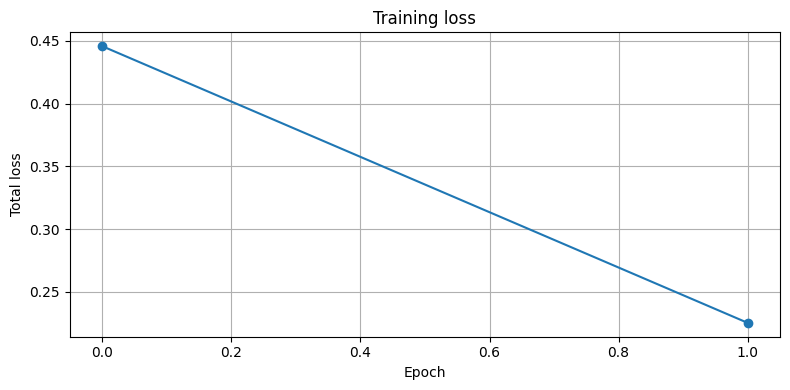

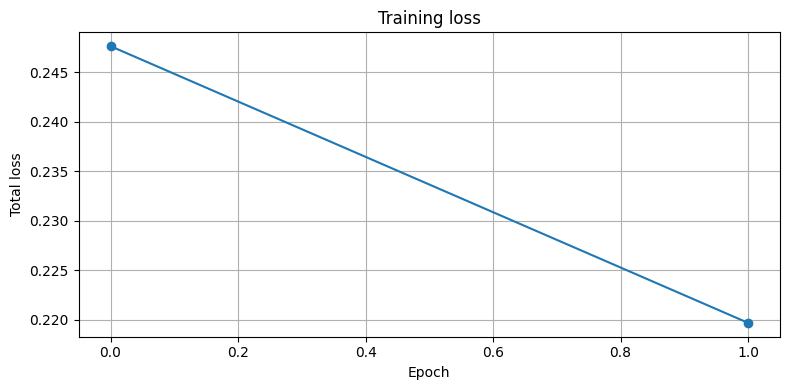

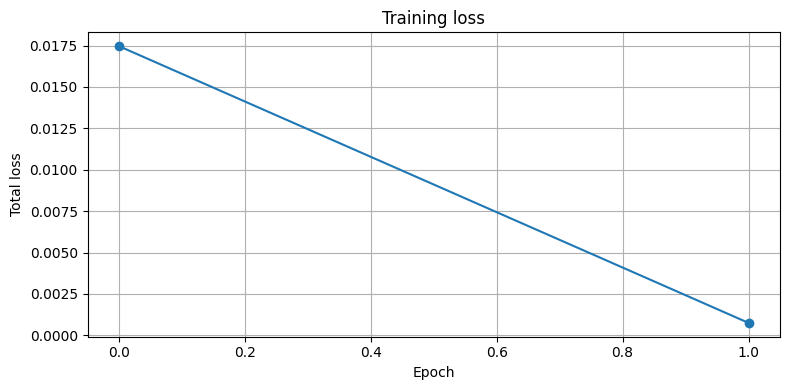

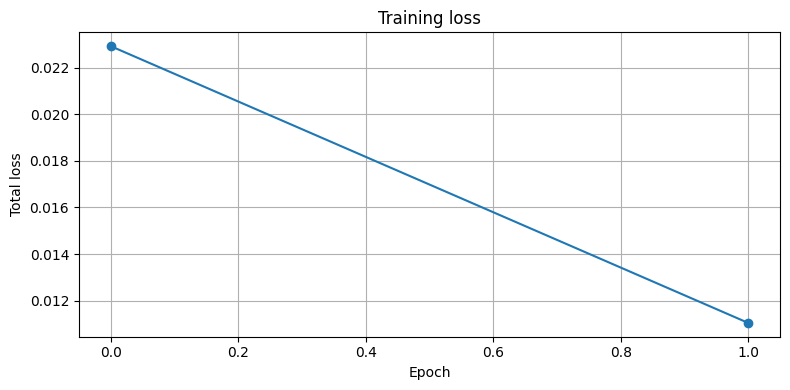

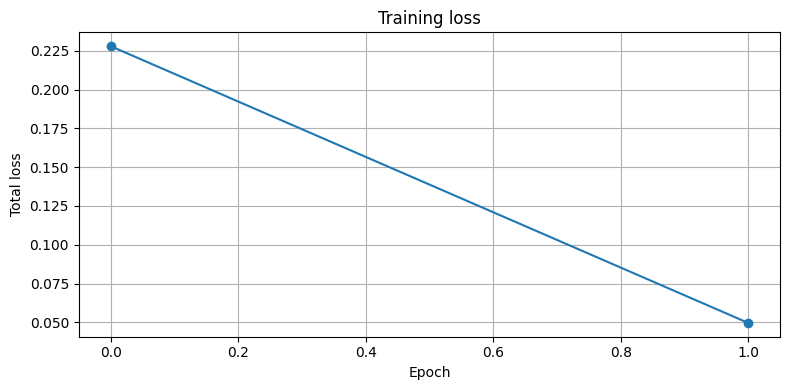

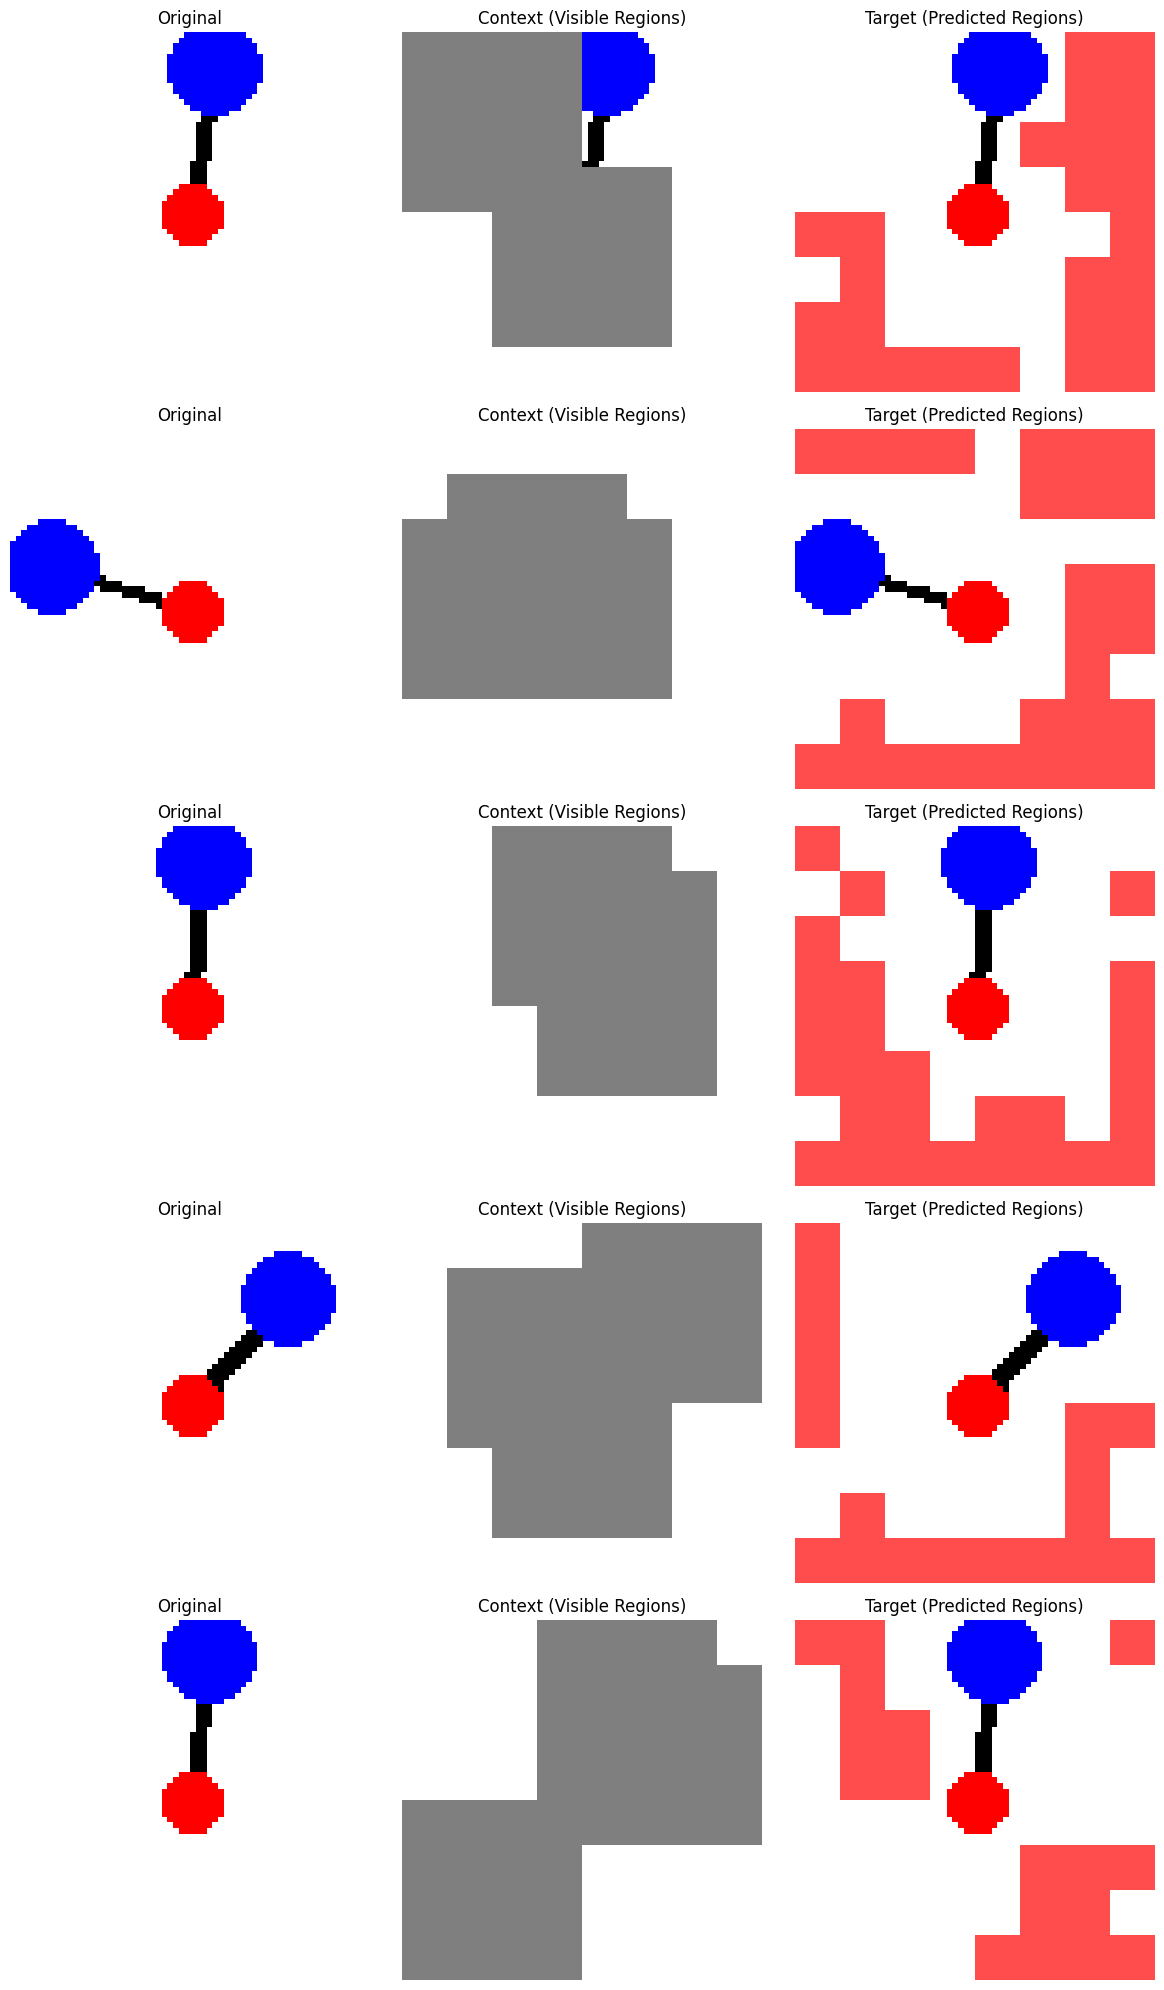

Training completed!


extract:   9%|▉         | 7/77 [00:01<00:10,  6.54it/s]


θ  R² = 1.0000 ,  MSE = 9.7151e-05
ω  R² = 0.2855 ,  MSE = 7.4475e+00


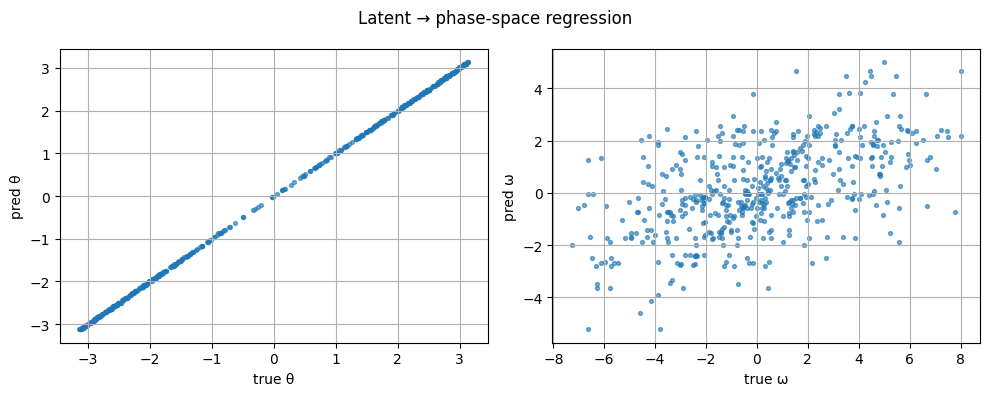

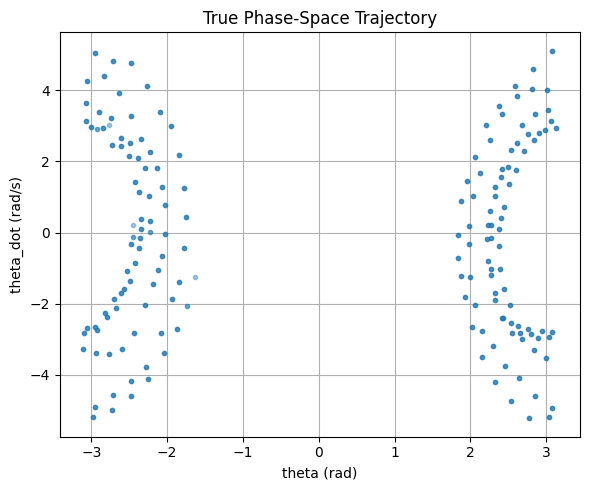

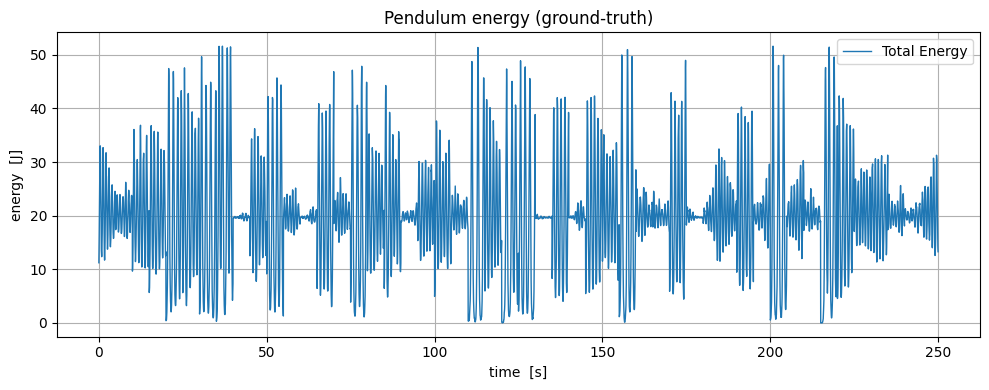

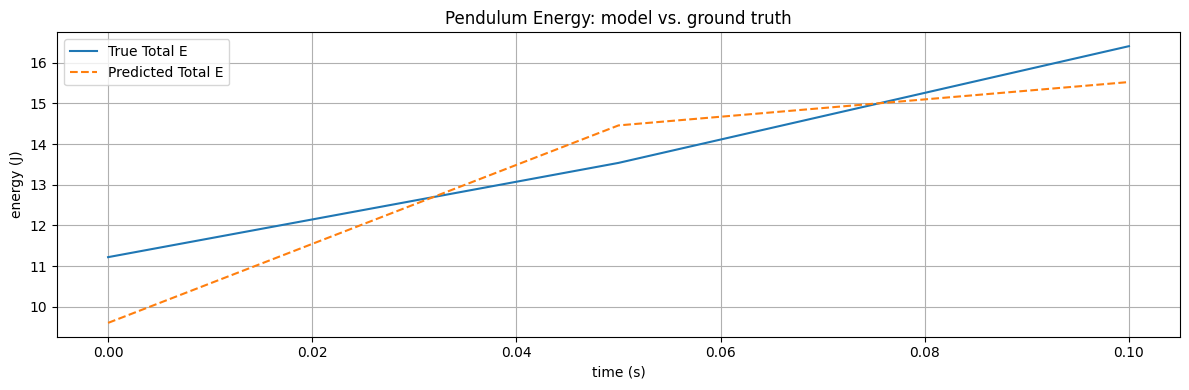

In [20]:
#!/usr/bin/env python3
# -------------------------------------------------------------
# Vision-JEPA + Lagrangian Neural Network on Pendulum (physics-correct)
# -------------------------------------------------------------

# ------------------------------------------------------------------
# 0 · Reproducibility & Device
# ------------------------------------------------------------------
torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ============================
# 1. Data Collection / Preparation
# ============================
class PendulumDataset(Dataset):
    """
    Returns image *sequences* of length `seq_len` (T,C,H,W) and the
    corresponding (theta, omega) sequence (T,2).

    This allows the LNN to compute a proper Euler–Lagrange residual.
    """
    def __init__(
        self,
        num_episodes: int = 100,
        episode_length: int = 200,
        img_size: int = 64,
        seq_len: int = 3,
        transform=None,
    ):
        assert seq_len >= 2, "seq_len must be ≥ 2 for physics loss"
        self.img_size = img_size
        self.seq_len  = seq_len
        self.transform = transform

        self.frames  : list[np.ndarray] = []  # flattened RGB images
        self.states  : list[tuple[float,float]] = []  # flattened (θ, ω)
        self.indices : list[int] = []  # sample-idx -> start idx of window

        self._generate(num_episodes, episode_length)

    # -------------- synthetic pendulum renderer ------------------
    def _render_pendulum(self, theta: float) -> np.ndarray:
        L   = self.img_size * 0.4
        cx  = cy = self.img_size // 2
        ex  = int(cx + L * np.sin(theta))
        ey  = int(cy + L * np.cos(theta))

        img = Image.new("RGB", (self.img_size, self.img_size), "white")
        drw = ImageDraw.Draw(img)
        drw.line([(cx, cy), (ex, ey)], fill="black", width=3)
        drw.ellipse([(cx-5, cy-5), (cx+5, cy+5)], fill="red")
        drw.ellipse([(ex-8, ey-8), (ex+8, ey+8)], fill="blue")
        return np.asarray(img).copy()

    # -------------- generate roll-outs ---------------------------
    def _generate(self, n_episodes: int, epi_len: int):
        print("Generating pendulum trajectories …")
        env = gym.make("Pendulum-v1")

        for _ in tqdm(range(n_episodes)):
            obs, _   = env.reset()
            theta    = np.arctan2(obs[1], obs[0])

            ep_imgs   : list[np.ndarray] = []
            ep_states : list[tuple[float,float]] = []

            for _ in range(epi_len):
                action = env.action_space.sample()
                obs, _, terminated, truncated, _ = env.step(action)
                if terminated or truncated:
                    break

                theta = np.arctan2(obs[1], obs[0])
                omega = float(obs[2])

                ep_imgs.append(self._render_pendulum(theta))
                ep_states.append((theta, omega))

            # slide a window of length seq_len
            for t0 in range(0, len(ep_imgs) - self.seq_len + 1):
                self.indices.append(len(self.frames) + t0)

            self.frames.extend(ep_imgs)
            self.states.extend(ep_states)

        env.close()
        print(f"Created {len(self.indices)} windows (seq_len={self.seq_len})")

    # -------------- Dunder methods -------------------------------
    def __len__(self) -> int:
        return len(self.indices)

    def __getitem__(self, idx: int):
        start = self.indices[idx]
        end   = start + self.seq_len

        imgs = [
            torch.from_numpy(self.frames[i]).float().permute(2, 0, 1) / 255.0
            for i in range(start, end)
        ]
        imgs = torch.stack(imgs)            # (T,C,H,W)

        states = torch.tensor(
            self.states[start:end], dtype=torch.float32
        )                                    # (T,2)  θ, ω

        if self.transform is not None:
            imgs = self.transform(imgs)

        return imgs, states

# ============================
# 2. V-JEPA backbone
# ============================
class PatchEmbed(nn.Module):
    """Image → patch embeddings"""
    def __init__(self, img_size=64, patch_size=8, in_chans=3, embed_dim=384):
        super().__init__()
        # convolution patch embedding
        self.n_patches = (img_size // patch_size) ** 2
        self.proj      = nn.Conv2d(in_chans, embed_dim,
                                   kernel_size=patch_size,
                                   stride=patch_size)
    def forward(self, x):
        x = self.proj(x)                     # (B,embed,H',W')
        x = x.flatten(2).transpose(1, 2)     # (B,N,embed)
        return x

class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim, depth, num_heads, mlp_ratio):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.TransformerEncoderLayer(
                embed_dim,
                num_heads,
                int(embed_dim * mlp_ratio),
                batch_first=True,
                norm_first=True
            ) for _ in range(depth)
        ])
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class MaskingStrategy:
    """Block + random masking identical to original V-JEPA impl."""
    def __init__(self, num_patches, mask_ratio=0.75, block_size=4):
        self.N  = num_patches
        self.r  = mask_ratio
        self.bs = block_size

    def random_masking(self, B):
        n_keep = int(self.N * (1 - self.r))
        noise  = torch.rand(B, self.N, device=device)
        ids    = torch.argsort(noise, dim=1)
        restore= torch.argsort(ids , dim=1)
        mask   = torch.ones(B, self.N, device=device)
        mask[:, :n_keep] = 0
        mask   = torch.gather(mask, 1, restore)
        return mask.bool()

    def block_masking(self, B):
        grid  = int(np.sqrt(self.N))
        masks = torch.zeros(B, self.N, device=device)
        n_blk = int((self.N * self.r) / (self.bs ** 2))
        for b in range(B):
            for _ in range(n_blk):
                h0 = np.random.randint(0, grid - self.bs + 1)
                w0 = np.random.randint(0, grid - self.bs + 1)
                for h in range(h0, h0 + self.bs):
                    for w in range(w0, w0 + self.bs):
                        masks[b, h * grid + w] = 1
        return masks.bool()

class VJEPA(nn.Module):
    """
    Vision-based Joint Embedding Predictive Architecture
    (unchanged naming; context / target encoders etc.)
    """
    def __init__(
        self,
        img_size=64,
        patch_size=8,
        in_chans=3,
        embed_dim=384,
        depth=6,
        num_heads=6,
        mlp_ratio=4.0,
        prediction_head_dim=192,
    ):
        super().__init__()
        self.patch_embed = PatchEmbed(img_size, patch_size, in_chans, embed_dim)
        self.num_patches = self.patch_embed.n_patches
        self.pos_embed   = nn.Parameter(torch.zeros(1, self.num_patches, embed_dim))

        self.context_encoder = TransformerEncoder(
            embed_dim, depth, num_heads, mlp_ratio
        )
        self.target_encoder  = TransformerEncoder(
            embed_dim, depth, num_heads, mlp_ratio
        )

        self.predictor = nn.Sequential(
            nn.Linear(embed_dim, prediction_head_dim),
            nn.GELU(),
            nn.Linear(prediction_head_dim, embed_dim)
        )

        self.masking = MaskingStrategy(self.num_patches)
        nn.init.normal_(self.pos_embed, std=0.02)

    # ---------- helpers ----------
    def forward_context(self, imgs, context_mask):
        x = self.patch_embed(imgs) + self.pos_embed  # (B,N,D)
        B, N, D = x.shape
        keep    = ~context_mask
        out     = torch.stack([
            F.pad(x[i][keep[i]], (0, 0, 0, N - keep[i].sum()))
            for i in range(B)
        ])
        return self.context_encoder(out)

    def forward_target(self, imgs, target_mask):
        x = self.patch_embed(imgs) + self.pos_embed
        B, N, D = x.shape
        out = torch.stack([
            F.pad(x[i][target_mask[i]], (0, 0, 0, N - target_mask[i].sum()))
            for i in range(B)
        ])
        return self.target_encoder(out)

    # ---------- main forward ----------
    def forward(self, imgs):
        """
        Returns:
            loss  : MSE between predictor(ctx) and target_feats
            pred  : predicted embeddings
            target: target embeddings
        """
        B = imgs.size(0)
        cmask = self.masking.block_masking(B)
        tmask = self.masking.random_masking(B) & ~cmask

        ctx_feats = self.forward_context(imgs, cmask)
        with torch.no_grad():
            tgt_feats = self.forward_target(imgs, tmask)

        pred = self.predictor(ctx_feats)
        loss = F.mse_loss(pred, tgt_feats)

        return loss, pred, tgt_feats

# ============================
# 3. Lagrangian Neural Network
# ============================
class LNN(nn.Module):
    """
    Minimal PyTorch port of Miles Cranmer's LNN.
    Learns scalar L(q,v); physics loss is Euler–Lagrange residual.
    """
    def __init__(self, input_dim, hidden_dim=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim), nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim), nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, qv):                     # (B,2d) → scalar L
        return self.net(qv)

    def lagrangian_residual(self, q, v, dt=0.01):
        """
        q, v : (B, T, d) tensors with T ≥ 2.
        Returns mean-squared Euler–Lagrange residual over (B,T-1,d).
        """
        B, T, d = q.shape
        z   = torch.cat([q, v], dim=-1).reshape(B*T, -1).requires_grad_(True)
        L   = self.forward(z).sum()
        dLd = torch.autograd.grad(L, z, create_graph=True)[0]
        dLdq, dLdv = dLd.split(d, dim=-1)
        dLdq = dLdq.view(B, T, d)
        dLdv = dLdv.view(B, T, d)

        ddt_dLdv = (dLdv[:, 1:] - dLdv[:, :-1]) / dt  # (B,T-1,d)
        residual = ddt_dLdv - dLdq[:, :-1]           # Euler–Lagrange
        return (residual ** 2).mean()

# ============================
# 3b. Hamiltonian Neural Network
# ============================
class HNN(nn.Module):
    """Minimal 2-D Hamiltonian NN (q = θ, p = ω)."""
    def __init__(self, hidden_dim=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, hidden_dim), nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim), nn.Tanh(),
            nn.Linear(hidden_dim, 2)               # outputs F1, F2
        )
        self.register_buffer("J", torch.tensor([[0., 1.],
                                                [-1., 0.]]))  # symplectic matrix

    def time_derivative(self, qp):                 # qp: (B,2)
        F1, F2 = self.net(qp).split(1, 1)
        dF2 = torch.autograd.grad(F2.sum(), qp, create_graph=True)[0]
        return dF2 @ self.J.T                      # (dq/dt, dp/dt)
    
    
# ============================
# 4. Training Function
# ============================

# Main training loop for VJEPA + LNN
    # For each batch:
    #   - Compute JEPA loss (first frame)
    #   - Predict (theta, omega) from latent
    #   - Compute LNN physics loss over trajectory
    #   - Optionally supervise theta at t=0
    #   - Combine losses and optimize

def train_vjepa(
    model,
    theta_head,
    lnn_net,
    hnn_net,                     # ▲ new
    train_loader,
    optimizer,
    num_epochs=10,
    log_interval=10,
    lambda_lnn=1e-3,             # ▲ renamed for clarity
    lambda_hnn=5e-4,             # ▲ new
    lambda_sup=1e-2,
):
    model.train()
    theta_head.train()
    lnn_net.train()
    hnn_net.train()               # ▲ new
    losses = []
    hnn_losses = []
    lnn_losses = []
    sup_losses = []
    jepa_losses = []

    print("Starting training …")
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for step, (imgs_seq, states_seq) in enumerate(
            tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")
        ):
            imgs_seq   = imgs_seq.to(device)    # (B,T,C,H,W)
            theta_seq  = states_seq[:, :, 0:1].to(device)  # (B,T,1)
            omega_seq  = states_seq[:, :, 1:2].to(device)  # (B,T,1)

            # ----- JEPA loss on first frame only -----
            imgs0 = imgs_seq[:, 0]               # (B,C,H,W)
            loss_jepa, _, _ = model(imgs0)

            # ----- latent → (θ̂, ω̂) (single frame) -----
            lat = model.patch_embed(imgs0) + model.pos_embed  # (B,N,D)
            lat = model.context_encoder(lat)                   # (B,N,D)
            z   = lat.mean(dim=1)                              # (B,D)
            theta_hat, omega_hat = theta_head(z).split(1, dim=1)
            
            # ----- HNN physics loss on frame-0 ---- ▲
            qp         = torch.cat([theta_hat, omega_hat], dim=1)   # (B,2)
            dqd_pred   = hnn_net.time_derivative(qp)[:, :1]         # dq/dt
            hnn_loss   = F.mse_loss(dqd_pred, omega_hat)            # p = ω

            # ----- LNN physics loss over trajectory ----
            lnn_loss = lnn_net.lagrangian_residual(theta_seq, omega_seq)

            # ----- optional supervised θ loss (t=0) -----
            sup_loss = F.mse_loss(theta_hat, theta_seq[:, 0])

            # ----- total -----
            loss = (
                loss_jepa
                + lambda_lnn * lnn_loss
                + lambda_hnn * hnn_loss      # ▲
                + lambda_sup  * sup_loss
            )
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            if step % log_interval == 0:
                tqdm.write(
                    f"step {step:04d} | "
                    f"jepa {loss_jepa.item():.4f} "
                    f"hnn {hnn_loss.item():.4f} "     # ▲
                    f"lnn {lnn_loss.item():.4f}"
                )

        avg = epoch_loss / len(train_loader)
        losses.append(avg)
        jepa_losses.append(loss_jepa.item())
        hnn_losses.append(hnn_loss.item())
        lnn_losses.append(lnn_loss.item())
        sup_losses.append(sup_loss.item())
        print(f"Epoch {epoch+1} avg loss {avg:.4f}")
    return losses, jepa_losses, hnn_losses, lnn_losses, sup_losses

def visualize_reconstructions(model, dataset, num_samples=5):
    """Show original, context-masked and target-masked frames."""
    model.eval()

    loader = DataLoader(dataset, batch_size=num_samples, shuffle=True)
    seq, _ = next(iter(loader))          # seq: (B,T,C,H,W)
    imgs   = seq[:, 0].to(device)        # take frame t=0 → (B,C,H,W)

    with torch.no_grad():
        B = imgs.size(0)
        context_mask = model.masking.block_masking(B)
        target_mask  = model.masking.random_masking(B) & ~context_mask
        context_feats = model.forward_context(imgs, context_mask)
        pred = model.predictor(context_feats)

    # Visualize the results
    plt.figure(figsize=(12, 4 * num_samples))

    for i in range(num_samples):
        # Original image
        plt.subplot(num_samples, 3, i * 3 + 1)
        img = imgs[i].cpu().permute(1, 2, 0).numpy()
        plt.imshow(img)
        plt.title("Original")
        plt.axis('off')

        # Masked image (context)
        plt.subplot(num_samples, 3, i * 3 + 2)
        masked_img = imgs[i].clone().cpu()

        grid_size = int(np.sqrt(model.num_patches))
        mask_reshaped = context_mask[i].reshape(1, 1, grid_size, grid_size).float()
        mask_upsampled = F.interpolate(
            mask_reshaped,
            size=(imgs.shape[2], imgs.shape[3]),
            mode='nearest'
        ).squeeze()

        for c in range(3):
            masked_img[c][mask_upsampled.bool()] = 0.5  # Gray out masked areas

        plt.imshow(masked_img.permute(1, 2, 0).numpy())
        plt.title("Context (Visible Regions)")
        plt.axis('off')

        # Target image (highlight predicted regions)
        plt.subplot(num_samples, 3, i * 3 + 3)
        target_img = imgs[i].clone().cpu()

        target_mask_reshaped = target_mask[i].reshape(1, 1, grid_size, grid_size).float()
        target_mask_upsampled = F.interpolate(
            target_mask_reshaped,
            size=(imgs.shape[2], imgs.shape[3]),
            mode='nearest'
        ).squeeze()

        for c in range(3):
            if c == 0:  # Red channel
                target_img[c][target_mask_upsampled.bool()] = 1.0
            else:
                target_img[c][target_mask_upsampled.bool()] = 0.3

        plt.imshow(target_img.permute(1, 2, 0).numpy())
        plt.title("Target (Predicted Regions)")
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('vjepa_reconstructions.png')
    plt.show()

# ============================
# 5. Simple loss plot helper
# ============================
def plot_training_loss(loss_list):
    plt.figure(figsize=(8,4))
    plt.plot(loss_list, marker="o")
    plt.xlabel("Epoch")
    plt.ylabel("Total loss")
    plt.title("Training loss")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# ============================
# 7. Main
# ============================
def main():
    # ---- config ----
    batch_size    = 32
    img_size      = 64
    patch_size    = 8
    embed_dim     = 384
    depth         = 6
    num_heads     = 6
    pred_head_dim = 192
    learning_rate = 1e-4
    num_epochs    = 2
    seq_len       = 3

    # ---- dataset & loader ----
    dataset = PendulumDataset(
        num_episodes=50,
        episode_length=100,
        img_size=img_size,
        seq_len=seq_len
    )
    train_loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
        pin_memory=False,
    )

    # ---- models ----
    model = VJEPA(
        img_size         = img_size,
        patch_size       = patch_size,
        in_chans         = 3,
        embed_dim        = embed_dim,
        depth            = depth,
        num_heads        = num_heads,
        mlp_ratio        = 4.0,
        prediction_head_dim = pred_head_dim,
    ).to(device)

    theta_head = nn.Linear(embed_dim, 2).to(device)
    lnn_net    = LNN(input_dim=2, hidden_dim=256).to(device)
    hnn_net    = HNN(hidden_dim=256).to(device)  

    # ---- optimiser ----
    optimizer = optim.AdamW(
        list(model.parameters())
        + list(theta_head.parameters())
        + list(lnn_net.parameters())
        + list(hnn_net.parameters()),
        lr=learning_rate)

    # ───────────────────────────
    # 6 · Training
    # ───────────────────────────
    losses, jepa_losses, hnn_losses, lnn_losses, sup_losses = train_vjepa(
        model, theta_head, lnn_net, hnn_net,
        train_loader, optimizer,
        num_epochs=num_epochs
    )

    plot_training_loss(losses)
    plot_training_loss(jepa_losses)
    plot_training_loss(hnn_losses)
    plot_training_loss(lnn_losses)
    plot_training_loss(sup_losses)
    visualize_reconstructions(model, dataset)

    # save checkpoint
    torch.save({
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
    }, "vjepa_pendulum_final.pt")

    print("Training completed!")
    analyze_vjepa_latent_phase_relation(model, dataset)
    plot_true_phase_space(dataset)
    plot_energy_conservation(dataset)   # uncomment if desired
    plot_energy_model_vs_truth(
    model,            # your trained VJEPA
    theta_head,       # trained latent→(θ,ω) layer
    dataset,
    win_idx=0         # pick any window index you like
)


if __name__ == "__main__":
    main()

In [21]:
#!/usr/bin/env python3
# -------------------------------------------------------------
# Vision-JEPA + Lagrangian Neural Network on Pendulum (physics-correct)
# -------------------------------------------------------------

# ------------------------------------------------------------------
# 0 · Reproducibility & Device
# ------------------------------------------------------------------
torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ============================
# 1. Data Collection / Preparation
# ============================
class PendulumDataset(Dataset):
    """
    Returns image *sequences* of length `seq_len` (T,C,H,W) and the
    corresponding (theta, omega) sequence (T,2).

    This allows the LNN to compute a proper Euler–Lagrange residual.
    """
    def __init__(
        self,
        num_episodes: int = 100,
        episode_length: int = 200,
        img_size: int = 64,
        seq_len: int = 3,
        transform=None,
    ):
        assert seq_len >= 2, "seq_len must be ≥ 2 for physics loss"
        self.img_size = img_size
        self.seq_len  = seq_len
        self.transform = transform

        self.frames  : list[np.ndarray] = []  # flattened RGB images
        self.states  : list[tuple[float,float]] = []  # flattened (θ, ω)
        self.indices : list[int] = []  # sample-idx -> start idx of window

        self._generate(num_episodes, episode_length)

    # -------------- synthetic pendulum renderer ------------------
    def _render_pendulum(self, theta: float) -> np.ndarray:
        L   = self.img_size * 0.4
        cx  = cy = self.img_size // 2
        ex  = int(cx + L * np.sin(theta))
        ey  = int(cy + L * np.cos(theta))

        img = Image.new("RGB", (self.img_size, self.img_size), "white")
        drw = ImageDraw.Draw(img)
        drw.line([(cx, cy), (ex, ey)], fill="black", width=3)
        drw.ellipse([(cx-5, cy-5), (cx+5, cy+5)], fill="red")
        drw.ellipse([(ex-8, ey-8), (ex+8, ey+8)], fill="blue")
        return np.asarray(img).copy()

    # -------------- generate roll-outs ---------------------------
    def _generate(self, n_episodes: int, epi_len: int):
        print("Generating pendulum trajectories …")
        env = gym.make("Pendulum-v1")

        for _ in tqdm(range(n_episodes)):
            obs, _   = env.reset()
            theta    = np.arctan2(obs[1], obs[0])

            ep_imgs   : list[np.ndarray] = []
            ep_states : list[tuple[float,float]] = []

            for _ in range(epi_len):
                action = env.action_space.sample()
                obs, _, terminated, truncated, _ = env.step(action)
                if terminated or truncated:
                    break

                theta = np.arctan2(obs[1], obs[0])
                omega = float(obs[2])

                ep_imgs.append(self._render_pendulum(theta))
                ep_states.append((theta, omega))

            # slide a window of length seq_len
            for t0 in range(0, len(ep_imgs) - self.seq_len + 1):
                self.indices.append(len(self.frames) + t0)

            self.frames.extend(ep_imgs)
            self.states.extend(ep_states)

        env.close()
        print(f"Created {len(self.indices)} windows (seq_len={self.seq_len})")

    # -------------- Dunder methods -------------------------------
    def __len__(self) -> int:
        return len(self.indices)

    def __getitem__(self, idx: int):
        start = self.indices[idx]
        end   = start + self.seq_len

        imgs = [
            torch.from_numpy(self.frames[i]).float().permute(2, 0, 1) / 255.0
            for i in range(start, end)
        ]
        imgs = torch.stack(imgs)            # (T,C,H,W)

        states = torch.tensor(
            self.states[start:end], dtype=torch.float32
        )                                    # (T,2)  θ, ω

        if self.transform is not None:
            imgs = self.transform(imgs)

        return imgs, states

# ============================
# 2. V-JEPA backbone
# ============================
class PatchEmbed(nn.Module):
    """Image → patch embeddings"""
    def __init__(self, img_size=64, patch_size=8, in_chans=3, embed_dim=384):
        super().__init__()
        # convolution patch embedding
        self.n_patches = (img_size // patch_size) ** 2
        self.proj      = nn.Conv2d(in_chans, embed_dim,
                                   kernel_size=patch_size,
                                   stride=patch_size)
    def forward(self, x):
        x = self.proj(x)                     # (B,embed,H',W')
        x = x.flatten(2).transpose(1, 2)     # (B,N,embed)
        return x

class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim, depth, num_heads, mlp_ratio):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.TransformerEncoderLayer(
                embed_dim,
                num_heads,
                int(embed_dim * mlp_ratio),
                batch_first=True,
                norm_first=True
            ) for _ in range(depth)
        ])
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class MaskingStrategy:
    """Block + random masking identical to original V-JEPA impl."""
    def __init__(self, num_patches, mask_ratio=0.75, block_size=4):
        self.N  = num_patches
        self.r  = mask_ratio
        self.bs = block_size

    def random_masking(self, B):
        n_keep = int(self.N * (1 - self.r))
        noise  = torch.rand(B, self.N, device=device)
        ids    = torch.argsort(noise, dim=1)
        restore= torch.argsort(ids , dim=1)
        mask   = torch.ones(B, self.N, device=device)
        mask[:, :n_keep] = 0
        mask   = torch.gather(mask, 1, restore)
        return mask.bool()

    def block_masking(self, B):
        grid  = int(np.sqrt(self.N))
        masks = torch.zeros(B, self.N, device=device)
        n_blk = int((self.N * self.r) / (self.bs ** 2))
        for b in range(B):
            for _ in range(n_blk):
                h0 = np.random.randint(0, grid - self.bs + 1)
                w0 = np.random.randint(0, grid - self.bs + 1)
                for h in range(h0, h0 + self.bs):
                    for w in range(w0, w0 + self.bs):
                        masks[b, h * grid + w] = 1
        return masks.bool()

class VJEPA(nn.Module):
    """
    Vision-based Joint Embedding Predictive Architecture
    (unchanged naming; context / target encoders etc.)
    """
    def __init__(
        self,
        img_size=64,
        patch_size=8,
        in_chans=3,
        embed_dim=384,
        depth=6,
        num_heads=6,
        mlp_ratio=4.0,
        prediction_head_dim=192,
    ):
        super().__init__()
        self.patch_embed = PatchEmbed(img_size, patch_size, in_chans, embed_dim)
        self.num_patches = self.patch_embed.n_patches
        self.pos_embed   = nn.Parameter(torch.zeros(1, self.num_patches, embed_dim))

        self.context_encoder = TransformerEncoder(
            embed_dim, depth, num_heads, mlp_ratio
        )
        self.target_encoder  = TransformerEncoder(
            embed_dim, depth, num_heads, mlp_ratio
        )

        self.predictor = nn.Sequential(
            nn.Linear(embed_dim, prediction_head_dim),
            nn.GELU(),
            nn.Linear(prediction_head_dim, embed_dim)
        )

        self.masking = MaskingStrategy(self.num_patches)
        nn.init.normal_(self.pos_embed, std=0.02)

    # ---------- helpers ----------
    def forward_context(self, imgs, context_mask):
        x = self.patch_embed(imgs) + self.pos_embed  # (B,N,D)
        B, N, D = x.shape
        keep    = ~context_mask
        out     = torch.stack([
            F.pad(x[i][keep[i]], (0, 0, 0, N - keep[i].sum()))
            for i in range(B)
        ])
        return self.context_encoder(out)

    def forward_target(self, imgs, target_mask):
        x = self.patch_embed(imgs) + self.pos_embed
        B, N, D = x.shape
        out = torch.stack([
            F.pad(x[i][target_mask[i]], (0, 0, 0, N - target_mask[i].sum()))
            for i in range(B)
        ])
        return self.target_encoder(out)

    # ---------- main forward ----------
    def forward(self, imgs):
        """
        Returns:
            loss  : MSE between predictor(ctx) and target_feats
            pred  : predicted embeddings
            target: target embeddings
        """
        B = imgs.size(0)
        cmask = self.masking.block_masking(B)
        tmask = self.masking.random_masking(B) & ~cmask

        ctx_feats = self.forward_context(imgs, cmask)
        with torch.no_grad():
            tgt_feats = self.forward_target(imgs, tmask)

        pred = self.predictor(ctx_feats)
        loss = F.mse_loss(pred, tgt_feats)

        return loss, pred, tgt_feats

# ============================
# 3. Lagrangian Neural Network
# ============================
class LNN(nn.Module):
    """
    Minimal PyTorch port of Miles Cranmer's LNN.
    Learns scalar L(q,v); physics loss is Euler–Lagrange residual.
    """
    def __init__(self, input_dim, hidden_dim=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim), nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim), nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, qv):                     # (B,2d) → scalar L
        return self.net(qv)

    def lagrangian_residual(self, q, v, dt=0.01):
        """
        q, v : (B, T, d) tensors with T ≥ 2.
        Returns mean-squared Euler–Lagrange residual over (B,T-1,d).
        """
        B, T, d = q.shape
        z   = torch.cat([q, v], dim=-1).reshape(B*T, -1).requires_grad_(True)
        L   = self.forward(z).sum()
        dLd = torch.autograd.grad(L, z, create_graph=True)[0]
        dLdq, dLdv = dLd.split(d, dim=-1)
        dLdq = dLdq.view(B, T, d)
        dLdv = dLdv.view(B, T, d)

        ddt_dLdv = (dLdv[:, 1:] - dLdv[:, :-1]) / dt  # (B,T-1,d)
        residual = ddt_dLdv - dLdq[:, :-1]           # Euler–Lagrange
        return (residual ** 2).mean()

# ============================
# 3b. Hamiltonian Neural Network
# ============================
class HNN(nn.Module):
    """Minimal 2-D Hamiltonian NN (q = θ, p = ω)."""
    def __init__(self, hidden_dim=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, hidden_dim), nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim), nn.Tanh(),
            nn.Linear(hidden_dim, 2)               # outputs F1, F2
        )
        self.register_buffer("J", torch.tensor([[0., 1.],
                                                [-1., 0.]]))  # symplectic matrix

    def time_derivative(self, qp):                 # qp: (B,2)
        F1, F2 = self.net(qp).split(1, 1)
        dF2 = torch.autograd.grad(F2.sum(), qp, create_graph=True)[0]
        return dF2 @ self.J.T                      # (dq/dt, dp/dt)

Using device: cpu


In [34]:
# ================================================================
# 0 · helper: train ONE epoch, return loss dict
# ================================================================
def _train_one_epoch(model, theta_head, lnn, hnn,
                     loader, opt, λ_lnn, λ_hnn, λ_sup):
    model.train(); theta_head.train()
    if lnn : lnn.train()
    if hnn : hnn.train()

    agg = dict(jepa=0., lnn=0., hnn=0., sup=0., total=0.)
    for imgs_seq, states_seq in loader:
        imgs_seq, states_seq = imgs_seq.to(device), states_seq.to(device)
        imgs0   = imgs_seq[:,0]                         # (B,C,H,W)
        θ_true  = states_seq[:,:,0:1]
        ω_true  = states_seq[:,:,1:2]

        # --- JEPA on frame-0 ------------------------------------
        loss_jepa, _, _ = model(imgs0)

        # --- latent → θ̂, ω̂ frame-0 -----------------------------
        z0   = model.patch_embed(imgs0)+model.pos_embed
        z0   = model.context_encoder(z0).mean(1)
        θ̂0, ω̂0 = theta_head(z0).split(1,1)

        # --- HNN residual (if active) ---------------------------
        if hnn and λ_hnn>0:
            qp = torch.cat([θ̂0, ω̂0], 1)
            hnn_loss = F.mse_loss(hnn.time_derivative(qp)[:,0:1], ω̂0)
        else:
            hnn_loss = torch.tensor(0., device=device)

        # --- LNN residual (if active) ---------------------------
        if lnn and λ_lnn>0:
            lnn_loss = lnn.lagrangian_residual(θ_true, ω_true)
        else:
            lnn_loss = torch.tensor(0., device=device)

        # --- supervised θ at t=0 -------------------------------
        sup_loss = F.mse_loss(θ̂0, θ_true[:,0])

        loss = (loss_jepa + λ_lnn*lnn_loss + λ_hnn*hnn_loss + λ_sup*sup_loss)
        opt.zero_grad(); loss.backward(); opt.step()

        agg['jepa']  += loss_jepa.item()
        agg['lnn']   += lnn_loss.item()
        agg['hnn']   += hnn_loss.item()
        agg['sup']   += sup_loss.item()
        agg['total'] += loss.item()

    for k in agg: agg[k] /= len(loader)
    return agg


# ================================================================
# 1 · run one MODE and save log
# ================================================================
def run_mode(mode:str, epochs:int=10, batch_size:int=32):
    print(f"\n###  {mode.upper()}  ###")

    # ---- hyper-params specific to run -------------------------
    λ_map = {
        "plain":    dict(λ_h=0.0,   λ_l=0.0),
        "hnn":      dict(λ_h=1e-3,  λ_l=0.0),
        "lnn":      dict(λ_h=0.0,   λ_l=1e-3),
        "hnn+lnn":  dict(λ_h=5e-4,  λ_l=1e-3),
    }
    λ_h, λ_l = λ_map[mode]["λ_h"], λ_map[mode]["λ_l"]
    λ_sup = 1e-2

    # ---- data loader ------------------------------------------
    ds = PendulumDataset(num_episodes=40, episode_length=120,
                         img_size=64, seq_len=3)
    dl = DataLoader(ds, batch_size=batch_size, shuffle=True)

    # ---- networks ---------------------------------------------
    model       = VJEPA(embed_dim=384, depth=6, num_heads=6).to(device)
    theta_head  = nn.Linear(384, 2).to(device)
    hnn         = HNN(hidden_dim=256).to(device) if λ_h > 0 else None
    lnn         = LNN(input_dim=2, hidden_dim=256).to(device) if λ_l > 0 else None

    params = list(model.parameters()) + list(theta_head.parameters())
    if hnn: params += list(hnn.parameters())
    if lnn: params += list(lnn.parameters())
    opt = optim.AdamW(params, lr=1e-4)

    # ---- training ---------------------------------------------
    log = {k:[] for k in ["total","jepa","hnn","lnn","sup"]}
    for ep in range(epochs):
        ep_loss = _train_one_epoch(model, theta_head, lnn, hnn,
                                   dl, opt, λ_l, λ_h, λ_sup)
        for k in log: log[k].append(ep_loss[k])
        print(f"ep {ep+1}: tot {ep_loss['total']:.3f} "
              f"j {ep_loss['jepa']:.3f} "
              f"h {ep_loss['hnn']:.3f} "
              f"l {ep_loss['lnn']:.3f}")

    # ---- save dictionary --------------------------------------
    cfg = dict(mode=mode, epochs=epochs,
               λ_hnn=λ_h, λ_lnn=λ_l, λ_sup=λ_sup,
               batch_size=batch_size)
    torch.save(model.state_dict(), f"model_{mode}.pt")
    torch.save(theta_head.state_dict(), f"theta_{mode}.pt")
    np.savez(f"results_{mode}.npz", **log, config=cfg)
    print("saved to results_%s.npz" % mode)


In [37]:
# ================================================================
# 2 · run all four experiments
# ================================================================
if __name__ == "__main__":
    for m in ["plain","hnn","lnn","hnn+lnn"]:
        run_mode(m)
    print("\nFinished all experiments; compare logs in results_<mode>.npz")


###  PLAIN  ###
Generating pendulum trajectories …


100%|██████████| 40/40 [00:00<00:00, 100.41it/s]


Created 4720 windows (seq_len=3)
ep 1: tot 0.470 j 0.429 h 0.000 l 0.000
ep 2: tot 0.224 j 0.223 h 0.000 l 0.000
ep 3: tot 0.214 j 0.214 h 0.000 l 0.000
ep 4: tot 0.211 j 0.210 h 0.000 l 0.000
ep 5: tot 0.209 j 0.209 h 0.000 l 0.000
ep 6: tot 0.209 j 0.208 h 0.000 l 0.000
ep 7: tot 0.208 j 0.208 h 0.000 l 0.000
ep 8: tot 0.207 j 0.207 h 0.000 l 0.000
ep 9: tot 0.207 j 0.207 h 0.000 l 0.000
ep 10: tot 0.207 j 0.207 h 0.000 l 0.000
saved to results_plain.npz

###  HNN  ###
Generating pendulum trajectories …


100%|██████████| 40/40 [00:00<00:00, 142.04it/s]


Created 4720 windows (seq_len=3)
ep 1: tot 0.457 j 0.420 h 0.011 l 0.000
ep 2: tot 0.227 j 0.225 h 0.006 l 0.000
ep 3: tot 0.217 j 0.217 h 0.004 l 0.000
ep 4: tot 0.214 j 0.214 h 0.003 l 0.000
ep 5: tot 0.213 j 0.213 h 0.003 l 0.000
ep 6: tot 0.213 j 0.213 h 0.002 l 0.000
ep 7: tot 0.212 j 0.212 h 0.002 l 0.000
ep 8: tot 0.212 j 0.212 h 0.001 l 0.000
ep 9: tot 0.211 j 0.211 h 0.001 l 0.000
ep 10: tot 0.211 j 0.211 h 0.001 l 0.000
saved to results_hnn.npz

###  LNN  ###
Generating pendulum trajectories …


100%|██████████| 40/40 [00:00<00:00, 114.05it/s]


Created 4720 windows (seq_len=3)
ep 1: tot 0.464 j 0.427 h 0.000 l 0.138
ep 2: tot 0.229 j 0.228 h 0.000 l 0.009
ep 3: tot 0.217 j 0.217 h 0.000 l 0.004
ep 4: tot 0.214 j 0.214 h 0.000 l 0.005
ep 5: tot 0.212 j 0.212 h 0.000 l 0.002
ep 6: tot 0.212 j 0.212 h 0.000 l 0.001
ep 7: tot 0.212 j 0.211 h 0.000 l 0.002
ep 8: tot 0.211 j 0.211 h 0.000 l 0.008
ep 9: tot 0.211 j 0.211 h 0.000 l 0.021
ep 10: tot 0.210 j 0.210 h 0.000 l 0.006
saved to results_lnn.npz

###  HNN+LNN  ###
Generating pendulum trajectories …


100%|██████████| 40/40 [00:00<00:00, 140.27it/s]


Created 4720 windows (seq_len=3)
ep 1: tot 0.455 j 0.413 h 0.029 l 0.524
ep 2: tot 0.233 j 0.231 h 0.009 l 0.015
ep 3: tot 0.221 j 0.221 h 0.004 l 0.005
ep 4: tot 0.218 j 0.218 h 0.003 l 0.003
ep 5: tot 0.218 j 0.218 h 0.003 l 0.003
ep 6: tot 0.217 j 0.217 h 0.002 l 0.002
ep 7: tot 0.217 j 0.217 h 0.002 l 0.002
ep 8: tot 0.217 j 0.217 h 0.002 l 0.001
ep 9: tot 0.216 j 0.216 h 0.002 l 0.002
ep 10: tot 0.216 j 0.216 h 0.002 l 0.002
saved to results_hnn+lnn.npz

Finished all experiments; compare logs in results_<mode>.npz


loaded plain    — epochs: 10
loaded hnn      — epochs: 10
loaded lnn      — epochs: 10
loaded hnn+lnn  — epochs: 10


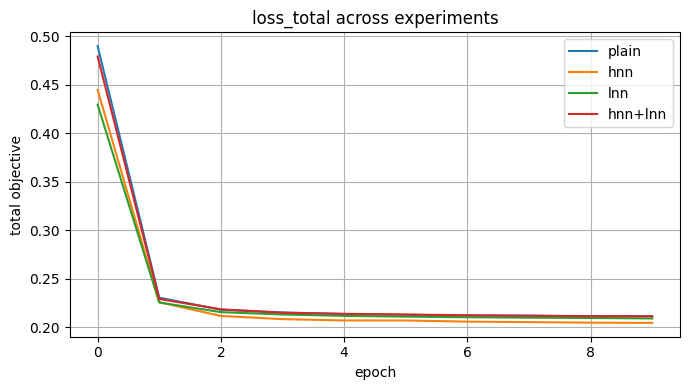

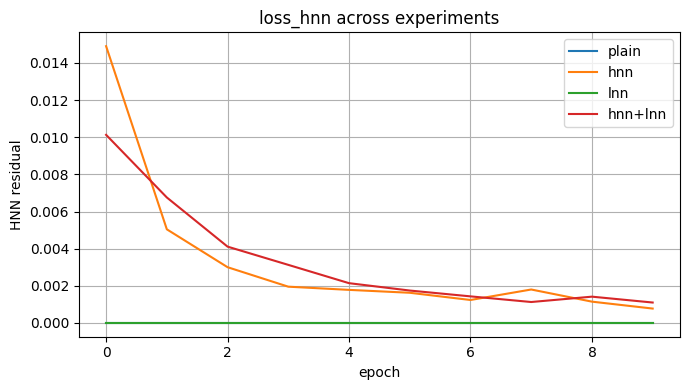

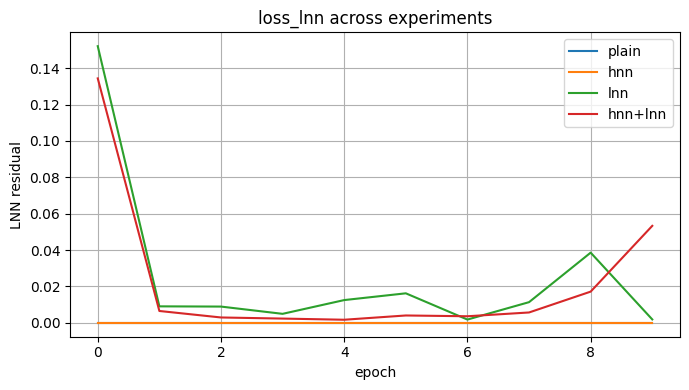

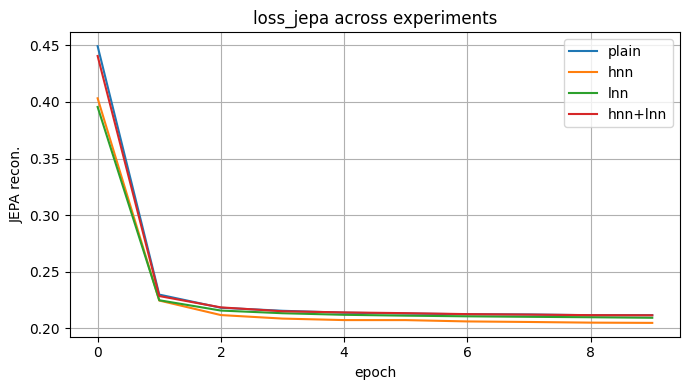

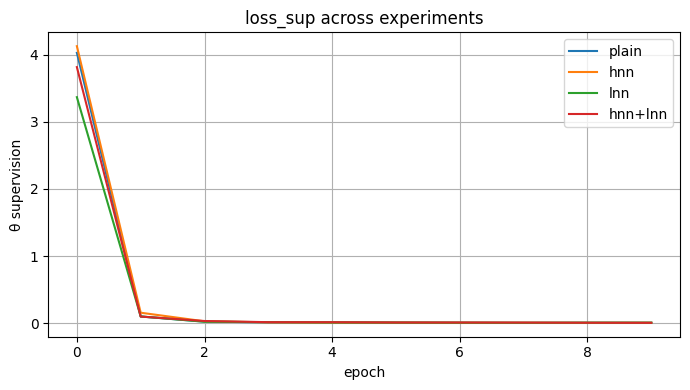

In [36]:
import numpy as np, matplotlib.pyplot as plt, glob, os, re

# ------------------------------------------------------------
# 1)  Load every results_<mode>.npz  and normalise keys
# ------------------------------------------------------------
logs = {}   # mode → dict

def _normalise_keys(ndict):
    """map total→loss_total, jepa→loss_jepa, … if needed"""
    mapping = {
        "total":"loss_total", "jepa":"loss_jepa",
        "hnn":"loss_hnn",     "lnn":"loss_lnn",
        "sup":"loss_sup"
    }
    out = {}
    for k,v in ndict.items():
        out[ mapping.get(k,k) ] = v
    return out

for file in glob.glob("results_*.npz"):
    mode  = re.search(r"results_(.+)\.npz", file).group(1)
    data  = np.load(file, allow_pickle=True)
    arrays= { k: data[k] for k in data.files if k != "config" }
    logs[mode] = _normalise_keys(arrays)
    logs[mode]["config"] = data["config"].item()
    n_ep = len(logs[mode]["loss_total"])
    print(f"loaded {mode:8} — epochs: {n_ep}")

# ------------------------------------------------------------
# 2)  Generic multi-line plot
# ------------------------------------------------------------
def plot_loss(comp, ylabel=None):
    plt.figure(figsize=(7,4))
    for mode,rec in logs.items():
        if comp in rec:
            plt.plot(rec[comp], label=mode)
    plt.xlabel("epoch")
    plt.ylabel(ylabel or comp)
    plt.title(f"{comp} across experiments")
    plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

# ------------------------------------------------------------
# 3)  Draw requested comparisons
# ------------------------------------------------------------
for key, label in [("loss_total","total objective"),
                   ("loss_hnn","HNN residual"),
                   ("loss_lnn","LNN residual"),
                   ("loss_jepa","JEPA recon."),
                   ("loss_sup","θ supervision")]:
    plot_loss(key, label)

Generating pendulum trajectories …


100%|██████████| 30/30 [00:00<00:00, 113.70it/s]


Created 3540 windows (seq_len=3)

>>> PLAIN <<<
{'r2_theta': 0.9999808669090271, 'mse_theta': 9.310909081250429e-05, 'r2_omega': 0.2355775237083435, 'mse_omega': 9.41842269897461}

>>> HNN <<<
{'r2_theta': 0.9999813437461853, 'mse_theta': 9.194109588861465e-05, 'r2_omega': 0.23699700832366943, 'mse_omega': 10.747400283813477}

>>> LNN <<<
{'r2_theta': 0.9999768733978271, 'mse_theta': 0.00011005270789610222, 'r2_omega': 0.28179699182510376, 'mse_omega': 9.363110542297363}

>>> HNN+LNN <<<
{'r2_theta': 0.9999802708625793, 'mse_theta': 9.12676623556763e-05, 'r2_omega': 0.3094382882118225, 'mse_omega': 9.52114486694336}

Saved metrics → metrics_all.json


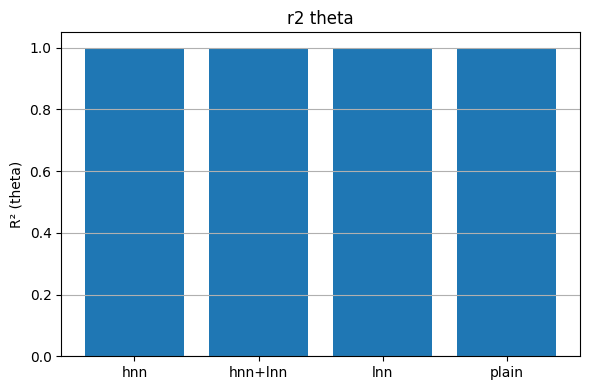

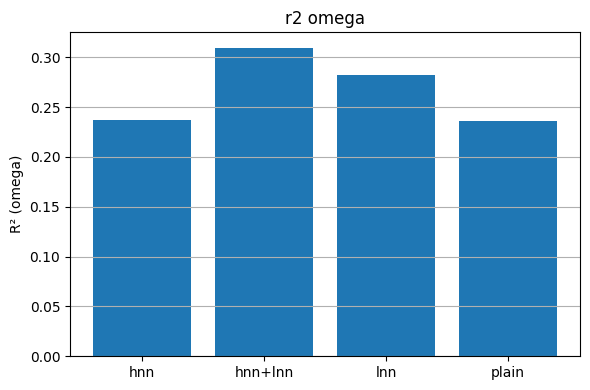

In [38]:
import torch, numpy as np, matplotlib.pyplot as plt, json, os, re
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from torch.utils.data import DataLoader
from tqdm import tqdm

# ------------------------------------------------------------------
# your existing regression helper, slightly tweaked to *return* metrics
# ------------------------------------------------------------------
def latent_phase_regression(model, dataset, batch_size=64, num_samples=500):
    model.eval()
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    latents, theta_list, omega_list = [], [], []
    collected = 0

    for seq, states in loader:
        imgs  = seq[:, 0].to(next(model.parameters()).device)
        theta = states[:, 0, 0].cpu().numpy()
        omega = states[:, 0, 1].cpu().numpy()

        with torch.no_grad():
            z = model.patch_embed(imgs) + model.pos_embed
            z = model.context_encoder(z).mean(1).cpu()

        latents.append(z)
        theta_list.extend(theta)
        omega_list.extend(omega)

        collected += imgs.size(0)
        if collected >= num_samples:
            break

    Z = torch.cat(latents, 0).numpy()[:num_samples]
    θ = np.array(theta_list)[:num_samples].reshape(-1,1)
    ω = np.array(omega_list)[:num_samples].reshape(-1,1)

    reg_θ = LinearRegression().fit(Z, θ)
    reg_ω = LinearRegression().fit(Z, ω)

    θ̂, ω̂ = reg_θ.predict(Z), reg_ω.predict(Z)
    return dict(
        r2_theta = float(r2_score(θ, θ̂)),
        mse_theta= float(mean_squared_error(θ, θ̂)),
        r2_omega = float(r2_score(ω, ω̂)),
        mse_omega= float(mean_squared_error(ω, ω̂)),
    )

# ------------------------------------------------------------------
# load-and-analyse loop
# ------------------------------------------------------------------
def analyse_saved_models(modes, dataset,
                         model_ctor, head_ctor,
                         result_json="metrics_all.json"):
    out = {}
    for m in modes:
        print(f"\n>>> {m.upper()} <<<")

        model = model_ctor().to(device)
        head  = head_ctor().to(device)

        mdl_ckpt  = f"model_{m}.pt"
        head_ckpt = f"theta_{m}.pt"
        if not (os.path.exists(mdl_ckpt) and os.path.exists(head_ckpt)):
            print("  checkpoints missing, skipping.")
            continue
        model.load_state_dict(torch.load(mdl_ckpt,  map_location=device))
        head.load_state_dict (torch.load(head_ckpt, map_location=device))

        # graft head (only for forward pass clarity)
        model.theta_head = head

        # run regression
        metrics = latent_phase_regression(model, dataset)
        out[m] = metrics
        print(metrics)

    # save metrics to one json for later
    with open(result_json, "w") as f:
        json.dump(out, f, indent=2)
    print("\nSaved metrics →", result_json)
    return out

# ------------------------------------------------------------------
# quick comparison plot  (example: R² for θ̂)
# ------------------------------------------------------------------
def plot_metric(all_metrics, key, ylabel):
    plt.figure(figsize=(6,4))
    modes = sorted(all_metrics.keys())
    vals  = [all_metrics[m][key] for m in modes]
    plt.bar(modes, vals)
    plt.ylabel(ylabel); plt.title(key.replace("_"," "))
    plt.grid(axis="y"); plt.tight_layout(); plt.show()

# ------------------------------------------------------------------
# Usage
# ------------------------------------------------------------------
if __name__ == "__main__":
    modes   = ["plain", "hnn", "lnn", "hnn+lnn"]

    # a PendulumDataset identical to the one you used for training
    ds = PendulumDataset(num_episodes=30, episode_length=120,
                         img_size=64, seq_len=3)

    metrics = analyse_saved_models(
        modes,
        dataset   = ds,
        model_ctor= lambda: VJEPA(embed_dim=384, depth=6, num_heads=6),
        head_ctor = lambda: nn.Linear(384,2)
    )

    # plot comparison
    plot_metric(metrics, "r2_theta", "R² (theta)")
    plot_metric(metrics, "r2_omega", "R² (omega)")

Generating pendulum trajectories …


  0%|          | 0/30 [00:00<?, ?it/s]/Users/panaschristou/miniforge3/envs/sys_dev/lib/python3.12/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|██████████| 30/30 [00:00<00:00, 138.14it/s]


Created 3540 windows (seq_len=3)


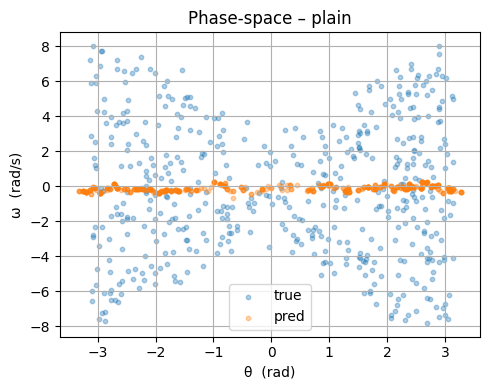

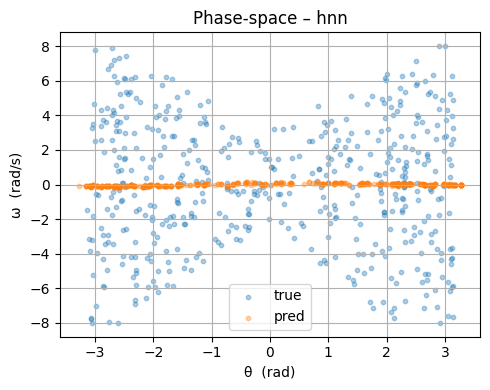

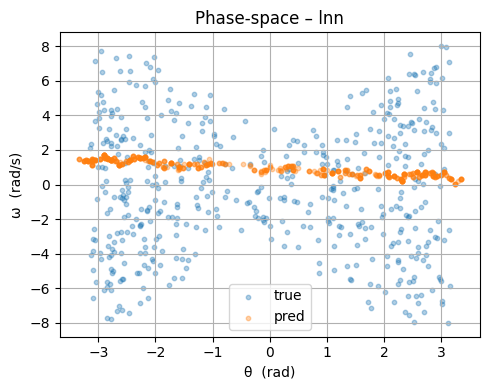

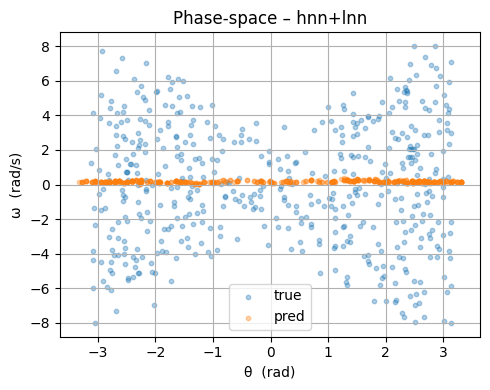

In [39]:
# ------------------------------------------------------------
# phase-space comparison for multiple trained models
# ------------------------------------------------------------
def plot_phase_space_models(modes,
                            dataset,
                            model_ctor,
                            head_ctor,
                            num_samples=500):
    """
    For every mode in `modes`:
      • load model_<mode>.pt  and  theta_<mode>.pt
      • scatter true (θ, ω)  vs. predicted (θ̂, ω̂) for up to num_samples
    """
    loader = DataLoader(dataset, batch_size=64, shuffle=True)

    results = {}          # mode → dict of arrays

    for mode in modes:
        mdl_file  = f"model_{mode}.pt"
        head_file = f"theta_{mode}.pt"
        if not (os.path.exists(mdl_file) and os.path.exists(head_file)):
            print(f"[{mode}] checkpoints missing — skipping")
            continue

        # -------- load nets ----------
        model = model_ctor().to(device)
        model.load_state_dict(torch.load(mdl_file, map_location=device))
        model.eval()

        theta_head = head_ctor().to(device)
        theta_head.load_state_dict(torch.load(head_file, map_location=device))
        theta_head.eval()

        θ_true, ω_true, θ_pred, ω_pred = [], [], [], []
        collected = 0

        for seq, states in loader:
            imgs  = seq[:, 0].to(device)          # (B,C,H,W) frame 0
            with torch.no_grad():
                z = model.patch_embed(imgs) + model.pos_embed
                z = model.context_encoder(z).mean(1)
                θ̂, ω̂ = theta_head(z).split(1,1)

            θ_true.extend(states[:,0,0].cpu().numpy())
            ω_true.extend(states[:,0,1].cpu().numpy())
            θ_pred.extend(θ̂.squeeze().cpu().numpy())
            ω_pred.extend(ω̂.squeeze().cpu().numpy())

            collected += imgs.size(0)
            if collected >= num_samples:
                break

        # trim to num_samples exactly
        θ_true = np.array(θ_true)[:num_samples]
        ω_true = np.array(ω_true)[:num_samples]
        θ_pred = np.array(θ_pred)[:num_samples]
        ω_pred = np.array(ω_pred)[:num_samples]

        results[mode] = dict(theta_true=θ_true,
                             omega_true=ω_true,
                             theta_pred=θ_pred,
                             omega_pred=ω_pred)

        # -------- plotting ----------
        plt.figure(figsize=(5,4))
        plt.scatter(θ_true, ω_true, s=10, alpha=.35, label="true")
        plt.scatter(θ_pred, ω_pred, s=10, alpha=.35, label="pred")
        plt.xlabel("θ  (rad)")
        plt.ylabel("ω  (rad/s)")
        plt.title(f"Phase-space – {mode}")
        plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

    return results

# ------------------------------------------------------------
# example call
# ------------------------------------------------------------
if __name__ == "__main__":
    ds = PendulumDataset(num_episodes=30, episode_length=120,
                         img_size=64, seq_len=3)

    modes = ["plain", "hnn", "lnn", "hnn+lnn"]   # adjust as you like

    phase_data = plot_phase_space_models(
        modes      = modes,
        dataset    = ds,
        model_ctor = lambda: VJEPA(embed_dim=384, depth=6, num_heads=6),
        head_ctor  = lambda: nn.Linear(384,2),
        num_samples=500
    )

    # optional: save to disk for later analysis
    np.savez("phase_space_all_modes.npz", **phase_data)

Generating pendulum trajectories …


100%|██████████| 30/30 [00:00<00:00, 124.18it/s]


Created 3540 windows (seq_len=3)

PLAIN:  θ R²=0.994  ω R²=-0.005


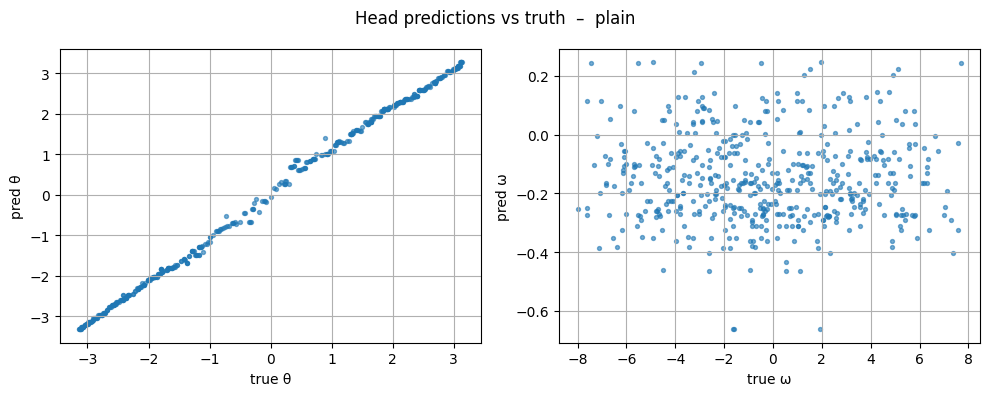


HNN:  θ R²=0.997  ω R²=-0.003


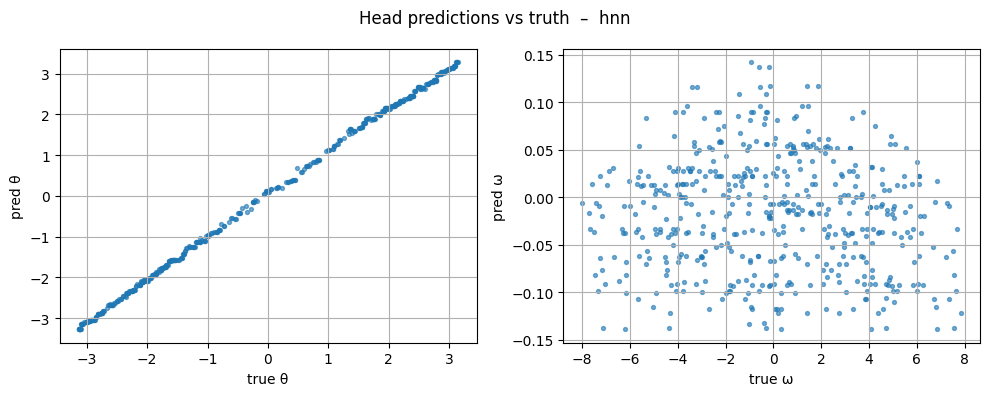


LNN:  θ R²=0.996  ω R²=-0.122


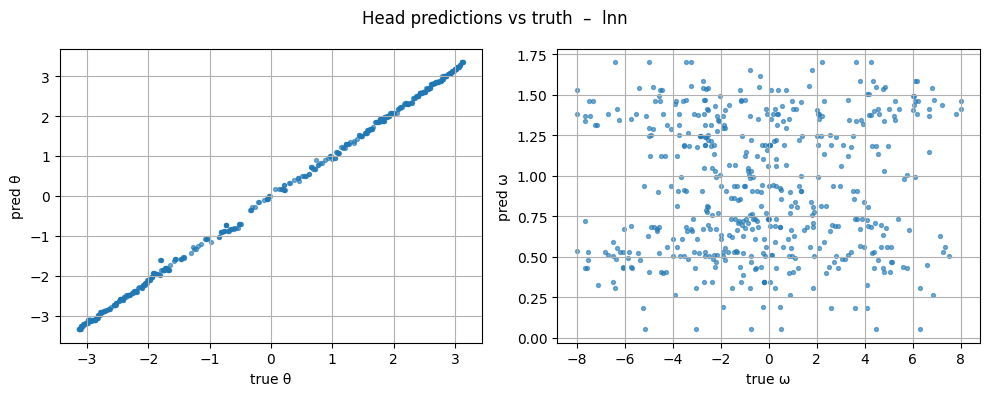


HNN+LNN:  θ R²=0.996  ω R²=-0.009


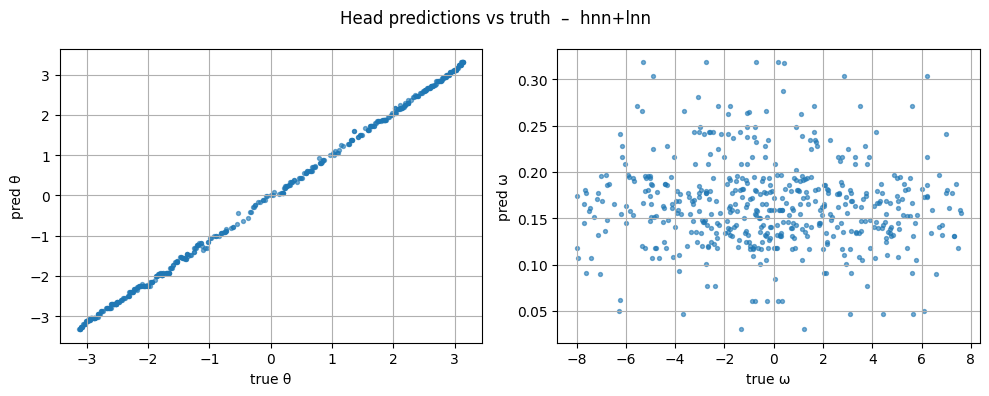


Saved metrics → head_metrics.json


In [40]:
import torch, numpy as np, matplotlib.pyplot as plt, json, os, re
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.metrics import r2_score, mean_squared_error

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ────────────────────────────────────────────────────────────────
# 0 · helper: run head → (θ̂, ω̂) and collect points
# ────────────────────────────────────────────────────────────────
def _scatter_head(model, head, dataset, num_samples=500, batch_size=64):
    model.eval(); head.eval()
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    θ_true, ω_true, θ_pred, ω_pred = [], [], [], []
    collected = 0

    for seq, states in loader:
        imgs = seq[:, 0].to(device)                       # (B,C,H,W)
        with torch.no_grad():
            z = model.patch_embed(imgs) + model.pos_embed
            z = model.context_encoder(z).mean(1)          # (B,D)
            θ̂, ω̂ = head(z).split(1, 1)

        θ_true.extend(states[:, 0, 0].cpu().numpy())
        ω_true.extend(states[:, 0, 1].cpu().numpy())
        θ_pred.extend(θ̂.squeeze().cpu().numpy())
        ω_pred.extend(ω̂.squeeze().cpu().numpy())

        collected += imgs.size(0)
        if collected >= num_samples:
            break

    # trim exactly
    θ_t = np.array(θ_true)[:num_samples]
    ω_t = np.array(ω_true)[:num_samples]
    θ_p = np.array(θ_pred)[:num_samples]
    ω_p = np.array(ω_pred)[:num_samples]

    return θ_t, ω_t, θ_p, ω_p


# ────────────────────────────────────────────────────────────────
# 1 · analyse & plot for all modes
# ────────────────────────────────────────────────────────────────
def analyse_modes(modes,
                  dataset,
                  model_ctor,
                  head_ctor,
                  samples=500,
                  out_json="head_metrics.json"):
    metrics = {}

    for m in modes:
        mdl_file  = f"model_{m}.pt"
        head_file = f"theta_{m}.pt"
        if not (os.path.exists(mdl_file) and os.path.exists(head_file)):
            print(f"[{m}] checkpoints not found → skipping"); continue

        # --- load nets -----------------------------------------------------
        model = model_ctor().to(device)
        model.load_state_dict(torch.load(mdl_file, map_location=device))
        head  = head_ctor().to(device)
        head.load_state_dict(torch.load(head_file, map_location=device))

        # --- collect points ------------------------------------------------
        θ_t, ω_t, θ_p, ω_p = _scatter_head(model, head, dataset,
                                           num_samples=samples)

        # --- metrics -------------------------------------------------------
        r2θ  = r2_score(θ_t, θ_p);   mseθ = mean_squared_error(θ_t, θ_p)
        r2ω  = r2_score(ω_t, ω_p);   mseω = mean_squared_error(ω_t, ω_p)
        metrics[m] = dict(r2_theta=r2θ, mse_theta=mseθ,
                          r2_omega=r2ω, mse_omega=mseω)
        print(f"\n{m.upper()}:  θ R²={r2θ:.3f}  ω R²={r2ω:.3f}")

        # --- scatter plots -------------------------------------------------
        plt.figure(figsize=(10,4))
        plt.subplot(1,2,1); plt.scatter(θ_t, θ_p, s=8, alpha=.6)
        plt.xlabel("true θ"); plt.ylabel("pred θ"); plt.grid()
        plt.subplot(1,2,2); plt.scatter(ω_t, ω_p, s=8, alpha=.6)
        plt.xlabel("true ω"); plt.ylabel("pred ω"); plt.grid()
        plt.suptitle(f"Head predictions vs truth  –  {m}")
        plt.tight_layout(); plt.show()

    with open(out_json, "w") as f: json.dump(metrics, f, indent=2)
    print("\nSaved metrics →", out_json)


# ────────────────────────────────────────────────────────────────
# 2 · example call
# ────────────────────────────────────────────────────────────────
if __name__ == "__main__":
    modes = ["plain", "hnn", "lnn", "hnn+lnn"]

    # dataset identical to training one
    ds = PendulumDataset(num_episodes=30, episode_length=120,
                         img_size=64, seq_len=3)

    analyse_modes(
        modes      = modes,
        dataset    = ds,
        model_ctor = lambda: VJEPA(embed_dim=384, depth=6, num_heads=6),
        head_ctor  = lambda: nn.Linear(384, 2),
        samples    = 500
    )

In [ ]:
#!/usr/bin/env python3
# -------------------------------------------------------------
# Vision-JEPA + Lagrangian Neural Network on Pendulum (physics-correct)
# -------------------------------------------------------------

# ------------------------------------------------------------------
# 0 · Reproducibility & Device
# ------------------------------------------------------------------
torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ============================
# 1. Data Collection / Preparation
# ============================
class PendulumDataset(Dataset):
    """
    Returns image *sequences* of length `seq_len` (T,C,H,W) and the
    corresponding (theta, omega) sequence (T,2).

    This allows the LNN to compute a proper Euler–Lagrange residual.
    """
    def __init__(
        self,
        num_episodes: int = 100,
        episode_length: int = 200,
        img_size: int = 64,
        seq_len: int = 3,
        transform=None,
    ):
        assert seq_len >= 2, "seq_len must be ≥ 2 for physics loss"
        self.img_size = img_size
        self.seq_len  = seq_len
        self.transform = transform

        self.frames  : list[np.ndarray] = []  # flattened RGB images
        self.states  : list[tuple[float,float]] = []  # flattened (θ, ω)
        self.indices : list[int] = []  # sample-idx -> start idx of window

        self._generate(num_episodes, episode_length)

    # -------------- synthetic pendulum renderer ------------------
    def _render_pendulum(self, theta: float) -> np.ndarray:
        L   = self.img_size * 0.4
        cx  = cy = self.img_size // 2
        ex  = int(cx + L * np.sin(theta))
        ey  = int(cy + L * np.cos(theta))

        img = Image.new("RGB", (self.img_size, self.img_size), "white")
        drw = ImageDraw.Draw(img)
        drw.line([(cx, cy), (ex, ey)], fill="black", width=3)
        drw.ellipse([(cx-5, cy-5), (cx+5, cy+5)], fill="red")
        drw.ellipse([(ex-8, ey-8), (ex+8, ey+8)], fill="blue")
        return np.asarray(img).copy()

    # -------------- generate roll-outs ---------------------------
    def _generate(self, n_episodes: int, epi_len: int):
        print("Generating pendulum trajectories …")
        env = gym.make("Pendulum-v1")

        for _ in tqdm(range(n_episodes)):
            obs, _   = env.reset()
            theta    = np.arctan2(obs[1], obs[0])

            ep_imgs   : list[np.ndarray] = []
            ep_states : list[tuple[float,float]] = []

            for _ in range(epi_len):
                action = env.action_space.sample()
                obs, _, terminated, truncated, _ = env.step(action)
                if terminated or truncated:
                    break

                theta = np.arctan2(obs[1], obs[0])
                omega = float(obs[2])

                ep_imgs.append(self._render_pendulum(theta))
                ep_states.append((theta, omega))

            # slide a window of length seq_len
            for t0 in range(0, len(ep_imgs) - self.seq_len + 1):
                self.indices.append(len(self.frames) + t0)

            self.frames.extend(ep_imgs)
            self.states.extend(ep_states)

        env.close()
        print(f"Created {len(self.indices)} windows (seq_len={self.seq_len})")

    # -------------- Dunder methods -------------------------------
    def __len__(self) -> int:
        return len(self.indices)

    def __getitem__(self, idx: int):
        start = self.indices[idx]
        end   = start + self.seq_len

        imgs = [
            torch.from_numpy(self.frames[i]).float().permute(2, 0, 1) / 255.0
            for i in range(start, end)
        ]
        imgs = torch.stack(imgs)            # (T,C,H,W)

        states = torch.tensor(
            self.states[start:end], dtype=torch.float32
        )                                    # (T,2)  θ, ω

        if self.transform is not None:
            imgs = self.transform(imgs)

        return imgs, states

# ============================
# 2. V-JEPA backbone
# ============================
class PatchEmbed(nn.Module):
    """Image → patch embeddings"""
    def __init__(self, img_size=64, patch_size=8, in_chans=3, embed_dim=384):
        super().__init__()
        # convolution patch embedding
        self.n_patches = (img_size // patch_size) ** 2
        self.proj      = nn.Conv2d(in_chans, embed_dim,
                                   kernel_size=patch_size,
                                   stride=patch_size)
    def forward(self, x):
        x = self.proj(x)                     # (B,embed,H',W')
        x = x.flatten(2).transpose(1, 2)     # (B,N,embed)
        return x

class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim, depth, num_heads, mlp_ratio):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.TransformerEncoderLayer(
                embed_dim,
                num_heads,
                int(embed_dim * mlp_ratio),
                batch_first=True,
                norm_first=True
            ) for _ in range(depth)
        ])
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class MaskingStrategy:
    """Block + random masking identical to original V-JEPA impl."""
    def __init__(self, num_patches, mask_ratio=0.75, block_size=4):
        self.N  = num_patches
        self.r  = mask_ratio
        self.bs = block_size

    def random_masking(self, B):
        n_keep = int(self.N * (1 - self.r))
        noise  = torch.rand(B, self.N, device=device)
        ids    = torch.argsort(noise, dim=1)
        restore= torch.argsort(ids , dim=1)
        mask   = torch.ones(B, self.N, device=device)
        mask[:, :n_keep] = 0
        mask   = torch.gather(mask, 1, restore)
        return mask.bool()

    def block_masking(self, B):
        grid  = int(np.sqrt(self.N))
        masks = torch.zeros(B, self.N, device=device)
        n_blk = int((self.N * self.r) / (self.bs ** 2))
        for b in range(B):
            for _ in range(n_blk):
                h0 = np.random.randint(0, grid - self.bs + 1)
                w0 = np.random.randint(0, grid - self.bs + 1)
                for h in range(h0, h0 + self.bs):
                    for w in range(w0, w0 + self.bs):
                        masks[b, h * grid + w] = 1
        return masks.bool()

class VJEPA(nn.Module):
    """
    Vision-based Joint Embedding Predictive Architecture
    (unchanged naming; context / target encoders etc.)
    """
    def __init__(
        self,
        img_size=64,
        patch_size=8,
        in_chans=3,
        embed_dim=384,
        depth=6,
        num_heads=6,
        mlp_ratio=4.0,
        prediction_head_dim=192,
    ):
        super().__init__()
        self.patch_embed = PatchEmbed(img_size, patch_size, in_chans, embed_dim)
        self.num_patches = self.patch_embed.n_patches
        self.pos_embed   = nn.Parameter(torch.zeros(1, self.num_patches, embed_dim))

        self.context_encoder = TransformerEncoder(
            embed_dim, depth, num_heads, mlp_ratio
        )
        self.target_encoder  = TransformerEncoder(
            embed_dim, depth, num_heads, mlp_ratio
        )

        self.predictor = nn.Sequential(
            nn.Linear(embed_dim, prediction_head_dim),
            nn.GELU(),
            nn.Linear(prediction_head_dim, embed_dim)
        )

        self.masking = MaskingStrategy(self.num_patches)
        nn.init.normal_(self.pos_embed, std=0.02)

    # ---------- helpers ----------
    def forward_context(self, imgs, context_mask):
        x = self.patch_embed(imgs) + self.pos_embed  # (B,N,D)
        B, N, D = x.shape
        keep    = ~context_mask
        out     = torch.stack([
            F.pad(x[i][keep[i]], (0, 0, 0, N - keep[i].sum()))
            for i in range(B)
        ])
        return self.context_encoder(out)

    def forward_target(self, imgs, target_mask):
        x = self.patch_embed(imgs) + self.pos_embed
        B, N, D = x.shape
        out = torch.stack([
            F.pad(x[i][target_mask[i]], (0, 0, 0, N - target_mask[i].sum()))
            for i in range(B)
        ])
        return self.target_encoder(out)

    # ---------- main forward ----------
    def forward(self, imgs):
        """
        Returns:
            loss  : MSE between predictor(ctx) and target_feats
            pred  : predicted embeddings
            target: target embeddings
        """
        B = imgs.size(0)
        cmask = self.masking.block_masking(B)
        tmask = self.masking.random_masking(B) & ~cmask

        ctx_feats = self.forward_context(imgs, cmask)
        with torch.no_grad():
            tgt_feats = self.forward_target(imgs, tmask)

        pred = self.predictor(ctx_feats)
        loss = F.mse_loss(pred, tgt_feats)

        return loss, pred, tgt_feats

# ============================
# 3. Lagrangian Neural Network
# ============================
class LNN(nn.Module):
    """
    Minimal PyTorch port of Miles Cranmer's LNN.
    Learns scalar L(q,v); physics loss is Euler–Lagrange residual.
    """
    def __init__(self, input_dim, hidden_dim=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim), nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim), nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, qv):                     # (B,2d) → scalar L
        return self.net(qv)

    def lagrangian_residual(self, q, v, dt=0.01):
        """
        q, v : (B, T, d) tensors with T ≥ 2.
        Returns mean-squared Euler–Lagrange residual over (B,T-1,d).
        """
        B, T, d = q.shape
        z   = torch.cat([q, v], dim=-1).reshape(B*T, -1).requires_grad_(True)
        L   = self.forward(z).sum()
        dLd = torch.autograd.grad(L, z, create_graph=True)[0]
        dLdq, dLdv = dLd.split(d, dim=-1)
        dLdq = dLdq.view(B, T, d)
        dLdv = dLdv.view(B, T, d)

        ddt_dLdv = (dLdv[:, 1:] - dLdv[:, :-1]) / dt  # (B,T-1,d)
        residual = ddt_dLdv - dLdq[:, :-1]           # Euler–Lagrange
        return (residual ** 2).mean()

# ============================
# 3b. Hamiltonian Neural Network
# ============================
class HNN(nn.Module):
    """Minimal 2-D Hamiltonian NN (q = θ, p = ω)."""
    def __init__(self, hidden_dim=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, hidden_dim), nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim), nn.Tanh(),
            nn.Linear(hidden_dim, 2)               # outputs F1, F2
        )
        self.register_buffer("J", torch.tensor([[0., 1.],
                                                [-1., 0.]]))  # symplectic matrix

    def time_derivative(self, qp):                 # qp: (B,2)
        F1, F2 = self.net(qp).split(1, 1)
        dF2 = torch.autograd.grad(F2.sum(), qp, create_graph=True)[0]
        return dF2 @ self.J.T                      # (dq/dt, dp/dt)

In [ ]:
# ================================================================
# 0 · helper: train ONE epoch, return loss dict
# ================================================================
def _train_one_epoch(model, theta_head, lnn, hnn,
                     loader, opt, λ_lnn, λ_hnn, λ_sup):
    model.train(); theta_head.train()
    if lnn : lnn.train()
    if hnn : hnn.train()

    agg = dict(jepa=0., lnn=0., hnn=0., sup=0., total=0.)
    for imgs_seq, states_seq in loader:
        imgs_seq, states_seq = imgs_seq.to(device), states_seq.to(device)
        imgs0   = imgs_seq[:,0]                         # (B,C,H,W)
        θ_true  = states_seq[:,:,0:1]
        ω_true  = states_seq[:,:,1:2]

        # --- JEPA on frame-0 ------------------------------------
        loss_jepa, _, _ = model(imgs0)

        # --- latent → θ̂, ω̂ frame-0 -----------------------------
        z0   = model.patch_embed(imgs0)+model.pos_embed
        z0   = model.context_encoder(z0).mean(1)
        θ̂0, ω̂0 = theta_head(z0).split(1,1)

        # --- HNN residual (if active) ---------------------------
        if hnn and λ_hnn>0:
            qp = torch.cat([θ̂0, ω̂0], 1)
            hnn_loss = F.mse_loss(hnn.time_derivative(qp)[:,0:1], ω̂0)
        else:
            hnn_loss = torch.tensor(0., device=device)

        # --- LNN residual (if active) ---------------------------
        if lnn and λ_lnn>0:
            lnn_loss = lnn.lagrangian_residual(θ_true, ω_true)
        else:
            lnn_loss = torch.tensor(0., device=device)

        # --- supervised θ at t=0 -------------------------------
        sup_loss = F.mse_loss(θ̂0, θ_true[:,0])

        loss = (loss_jepa + λ_lnn*lnn_loss + λ_hnn*hnn_loss + λ_sup*sup_loss)
        opt.zero_grad(); loss.backward(); opt.step()

        agg['jepa']  += loss_jepa.item()
        agg['lnn']   += lnn_loss.item()
        agg['hnn']   += hnn_loss.item()
        agg['sup']   += sup_loss.item()
        agg['total'] += loss.item()

    for k in agg: agg[k] /= len(loader)
    return agg


# ================================================================
# 1 · run one MODE and save log
# ================================================================
def run_mode(mode:str, epochs:int=10, batch_size:int=32):
    print(f"\n###  {mode.upper()}  ###")

    # ---- hyper-params specific to run -------------------------
    λ_map = {
        "plain":    dict(λ_h=0.0,   λ_l=0.0),
        "hnn":      dict(λ_h=1e-3,  λ_l=0.0),
        "lnn":      dict(λ_h=0.0,   λ_l=1e-3),
        "hnn+lnn":  dict(λ_h=5e-4,  λ_l=1e-3),
    }
    λ_h, λ_l = λ_map[mode]["λ_h"], λ_map[mode]["λ_l"]
    λ_sup = 1e-2

    # ---- data loader ------------------------------------------
    ds = PendulumDataset(num_episodes=40, episode_length=400,
                         img_size=64, seq_len=3)
    dl = DataLoader(ds, batch_size=batch_size, shuffle=True)

    # ---- networks ---------------------------------------------
    model       = VJEPA(embed_dim=384, depth=6, num_heads=6).to(device)
    theta_head  = nn.Linear(384, 2).to(device)
    hnn         = HNN(hidden_dim=256).to(device) if λ_h > 0 else None
    lnn         = LNN(input_dim=2, hidden_dim=256).to(device) if λ_l > 0 else None

    params = list(model.parameters()) + list(theta_head.parameters())
    if hnn: params += list(hnn.parameters())
    if lnn: params += list(lnn.parameters())
    opt = optim.AdamW(params, lr=1e-4)

    # ---- training ---------------------------------------------
    log = {k:[] for k in ["total","jepa","hnn","lnn","sup"]}
    for ep in range(epochs):
        ep_loss = _train_one_epoch(model, theta_head, lnn, hnn,
                                   dl, opt, λ_l, λ_h, λ_sup)
        for k in log: log[k].append(ep_loss[k])
        print(f"ep {ep+1}: tot {ep_loss['total']:.3f} "
              f"j {ep_loss['jepa']:.3f} "
              f"h {ep_loss['hnn']:.3f} "
              f"l {ep_loss['lnn']:.3f}")

    # ---- save dictionary --------------------------------------
    cfg = dict(mode=mode, epochs=epochs,
               λ_hnn=λ_h, λ_lnn=λ_l, λ_sup=λ_sup,
               batch_size=batch_size)
    torch.save(model.state_dict(), f"model_{mode}_dense.pt")
    torch.save(theta_head.state_dict(), f"theta_{mode}_dense.pt")
    np.savez(f"results_{mode}_dense.npz", **log, config=cfg)
    print("saved to results_%s_dense.npz" % mode)


In [59]:
# ================================================================
# 0 · helper: train ONE epoch, return loss dict
# ================================================================
def _train_one_epoch(model, theta_head, lnn, hnn,
                     loader, opt, λ_lnn, λ_hnn, λ_sup):
    
    model.train(); theta_head.train()
    if lnn : lnn.train()
    if hnn : hnn.train()

    agg = dict(jepa=0., lnn=0., hnn=0., sup=0., total=0.)
    for imgs_seq, states_seq in loader:
        imgs_seq, states_seq = imgs_seq.to(device), states_seq.to(device)
        imgs0   = imgs_seq[:,0]                         # (B,C,H,W)
        θ_true  = states_seq[:,:,0:1]
        ω_true  = states_seq[:,:,1:2]

        # --- JEPA on frame-0 ------------------------------------
        loss_jepa, _, _ = model(imgs0)

        # --- latent → θ̂, ω̂ frame-0 -----------------------------
        z0   = model.patch_embed(imgs0)+model.pos_embed
        z0   = model.context_encoder(z0).mean(1)
        θ̂0, ω̂0 = theta_head(z0).split(1,1)

        # --- HNN residual (if active) ---------------------------
        if hnn and λ_hnn>0:
            qp = torch.cat([θ̂0, ω̂0], 1)
            hnn_loss = F.mse_loss(hnn.time_derivative(qp)[:,0:1], ω̂0)
        else:
            hnn_loss = torch.tensor(0., device=device)

        # --- LNN residual (if active) ---------------------------
        if lnn and λ_lnn>0:
            lnn_loss = lnn.lagrangian_residual(θ_true, ω_true)
        else:
            lnn_loss = torch.tensor(0., device=device)

        # --- supervised θ at t=0 -------------------------------
        sup_loss = F.mse_loss(θ̂0, θ_true[:,0])

        loss = (loss_jepa + λ_lnn*lnn_loss + λ_hnn*hnn_loss + λ_sup*sup_loss)
        opt.zero_grad(); loss.backward(); opt.step()

        agg['jepa']  += loss_jepa.item()
        agg['lnn']   += lnn_loss.item()
        agg['hnn']   += hnn_loss.item()
        agg['sup']   += sup_loss.item()
        agg['total'] += loss.item()

    for k in agg: agg[k] /= len(loader)
    return agg


# ================================================================
# 1 · run one MODE and save log
# ================================================================
def run_mode(mode:str, epochs:int=10, batch_size:int=32):
    print(f"\n###  {mode.upper()}  ###")

    SUFFIX = '_dense'
    
    # ---- hyper-params specific to run -------------------------
    λ_map = {
        "plain":    dict(λ_h=0.0,   λ_l=0.0),
        "hnn":      dict(λ_h=1e-3,  λ_l=0.0),
        "lnn":      dict(λ_h=0.0,   λ_l=1e-3),
        "hnn+lnn":  dict(λ_h=5e-4,  λ_l=1e-3),
    }
    λ_h, λ_l = λ_map[mode]["λ_h"], λ_map[mode]["λ_l"]
    λ_sup = 1e-2

    # ---- data loader ------------------------------------------
    ds = PendulumDataset(num_episodes=40, episode_length=400,
                         img_size=64, seq_len=3)
    dl = DataLoader(ds, batch_size=batch_size, shuffle=True)

    # ---- networks ---------------------------------------------
    model       = VJEPA(embed_dim=384, depth=6, num_heads=6).to(device)
    theta_head  = nn.Linear(384, 2).to(device)
    hnn         = HNN(hidden_dim=256).to(device) if λ_h > 0 else None
    lnn         = LNN(input_dim=2, hidden_dim=256).to(device) if λ_l > 0 else None

    params = list(model.parameters()) + list(theta_head.parameters())
    if hnn: params += list(hnn.parameters())
    if lnn: params += list(lnn.parameters())
    opt = optim.AdamW(params, lr=1e-4)

    # ---- training ---------------------------------------------
    log = {k:[] for k in ["total","jepa","hnn","lnn","sup"]}
    for ep in range(epochs):
        ep_loss = _train_one_epoch(model, theta_head, lnn, hnn,
                                   dl, opt, λ_l, λ_h, λ_sup)
        for k in log: log[k].append(ep_loss[k])
        print(f"ep {ep+1}: tot {ep_loss['total']:.3f} "
              f"j {ep_loss['jepa']:.3f} "
              f"h {ep_loss['hnn']:.3f} "
              f"l {ep_loss['lnn']:.3f}")

    # ---- save dictionary --------------------------------------
    cfg = dict(mode=mode, epochs=epochs,
               λ_hnn=λ_h, λ_lnn=λ_l, λ_sup=λ_sup,
               batch_size=batch_size)
    # ---------------------------------------------------------------
    # replace the two separate torch.save(...) calls by this block
    # ---------------------------------------------------------------
    full_sd = {}

    # 1)  V-JEPA backbone
    for k, v in model.state_dict().items():
        full_sd[f"vjepa.{k}"] = v.cpu()

    # 2)  θ-ω linear head
    for k, v in theta_head.state_dict().items():
        full_sd[f"theta_head.{k}"] = v.cpu()

    # 3)  HNN parameters  (only if this mode uses an HNN)
    if hnn is not None:
        for k, v in hnn.state_dict().items():
            full_sd[f"hnn.{k}"] = v.cpu()

    # 4)  LNN parameters  (only if this mode uses an LNN)
    if lnn is not None:
        for k, v in lnn.state_dict().items():
            full_sd[f"lnn.{k}"] = v.cpu()

    # ---- one self-contained checkpoint ----
    torch.save(full_sd, f"model_{mode}{SUFFIX}.pt")

    # --------- training log stays unchanged ----------
    np.savez(f"results_{mode}{SUFFIX}.npz", **log, config=cfg)
    print(f"saved to  model_{mode}{SUFFIX}.pt   &   results_{mode}{SUFFIX}.npz")
    
    np.savez(f"results_{mode}_dense.npz", **log, config=cfg)
    print("saved to results_%s_dense.npz" % mode)


In [60]:
# ================================================================
# 2 · run all four experiments
# ================================================================
if __name__ == "__main__":
    for m in ["plain","hnn","lnn","hnn+lnn"]:
        run_mode(m)
    print("\nFinished all experiments; compare logs in results_<mode>_dense.npz")


###  PLAIN  ###
Generating pendulum trajectories …


  0%|          | 0/40 [00:00<?, ?it/s]/Users/panaschristou/miniforge3/envs/sys_dev/lib/python3.12/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|██████████| 40/40 [00:00<00:00, 42.01it/s]


Created 15920 windows (seq_len=3)
ep 1: tot 0.288 j 0.278 h 0.000 l 0.000
ep 2: tot 0.210 j 0.210 h 0.000 l 0.000
ep 3: tot 0.209 j 0.209 h 0.000 l 0.000
ep 4: tot 0.208 j 0.208 h 0.000 l 0.000
ep 5: tot 0.207 j 0.207 h 0.000 l 0.000
ep 6: tot 0.207 j 0.206 h 0.000 l 0.000
ep 7: tot 0.206 j 0.206 h 0.000 l 0.000
ep 8: tot 0.206 j 0.206 h 0.000 l 0.000
ep 9: tot 0.206 j 0.206 h 0.000 l 0.000
ep 10: tot 0.205 j 0.205 h 0.000 l 0.000
saved to  model_plain_dense.pt   &   results_plain_dense.npz
saved to results_plain_dense.npz

###  HNN  ###
Generating pendulum trajectories …


100%|██████████| 40/40 [00:01<00:00, 33.27it/s]


Created 15920 windows (seq_len=3)
ep 1: tot 0.285 j 0.274 h 0.012 l 0.000
ep 2: tot 0.211 j 0.211 h 0.003 l 0.000
ep 3: tot 0.209 j 0.209 h 0.001 l 0.000
ep 4: tot 0.208 j 0.208 h 0.001 l 0.000
ep 5: tot 0.207 j 0.207 h 0.001 l 0.000
ep 6: tot 0.207 j 0.207 h 0.000 l 0.000
ep 7: tot 0.206 j 0.206 h 0.000 l 0.000
ep 8: tot 0.206 j 0.206 h 0.000 l 0.000
ep 9: tot 0.206 j 0.206 h 0.000 l 0.000
ep 10: tot 0.206 j 0.205 h 0.000 l 0.000
saved to  model_hnn_dense.pt   &   results_hnn_dense.npz
saved to results_hnn_dense.npz

###  LNN  ###
Generating pendulum trajectories …


100%|██████████| 40/40 [00:01<00:00, 38.68it/s]


Created 15920 windows (seq_len=3)
ep 1: tot 0.286 j 0.273 h 0.000 l 0.030
ep 2: tot 0.211 j 0.210 h 0.000 l 0.014
ep 3: tot 0.209 j 0.209 h 0.000 l 0.002
ep 4: tot 0.209 j 0.208 h 0.000 l 0.033
ep 5: tot 0.208 j 0.208 h 0.000 l 0.000
ep 6: tot 0.208 j 0.208 h 0.000 l 0.032
ep 7: tot 0.208 j 0.208 h 0.000 l 0.000
ep 8: tot 0.208 j 0.208 h 0.000 l 0.001
ep 9: tot 0.208 j 0.208 h 0.000 l 0.002
ep 10: tot 0.209 j 0.209 h 0.000 l 0.003
saved to  model_lnn_dense.pt   &   results_lnn_dense.npz
saved to results_lnn_dense.npz

###  HNN+LNN  ###
Generating pendulum trajectories …


100%|██████████| 40/40 [00:00<00:00, 44.61it/s]


Created 15920 windows (seq_len=3)
ep 1: tot 0.295 j 0.283 h 0.006 l 0.121
ep 2: tot 0.210 j 0.210 h 0.003 l 0.002
ep 3: tot 0.209 j 0.209 h 0.002 l 0.005
ep 4: tot 0.209 j 0.208 h 0.001 l 0.003
ep 5: tot 0.208 j 0.208 h 0.001 l 0.013
ep 6: tot 0.208 j 0.208 h 0.000 l 0.001
ep 7: tot 0.208 j 0.208 h 0.000 l 0.002
ep 8: tot 0.207 j 0.207 h 0.000 l 0.022
ep 9: tot 0.207 j 0.207 h 0.000 l 0.000
ep 10: tot 0.207 j 0.207 h 0.000 l 0.001
saved to  model_hnn+lnn_dense.pt   &   results_hnn+lnn_dense.npz
saved to results_hnn+lnn_dense.npz

Finished all experiments; compare logs in results_<mode>_dense.npz


loaded hnn+lnn  — epochs: 10
loaded lnn      — epochs: 10
loaded plain    — epochs: 10
loaded hnn      — epochs: 10


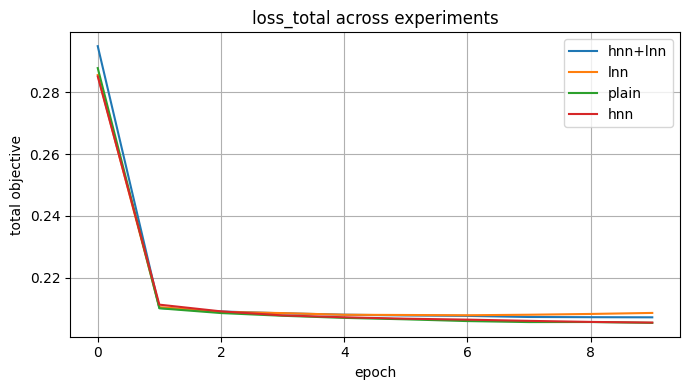

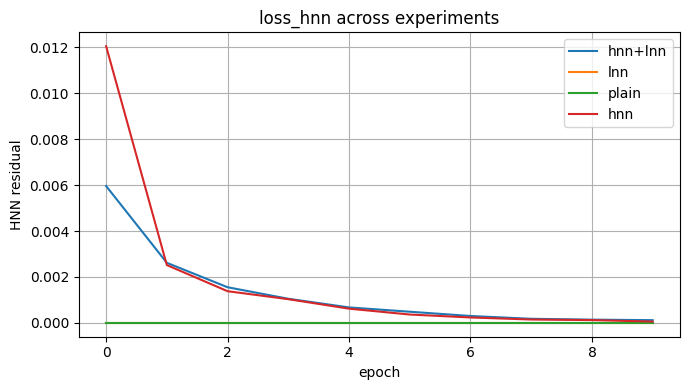

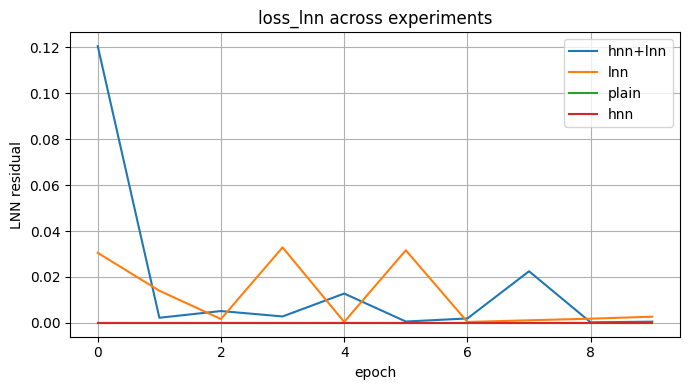

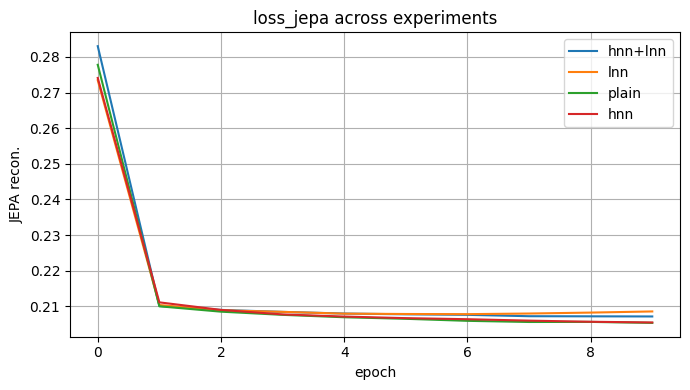

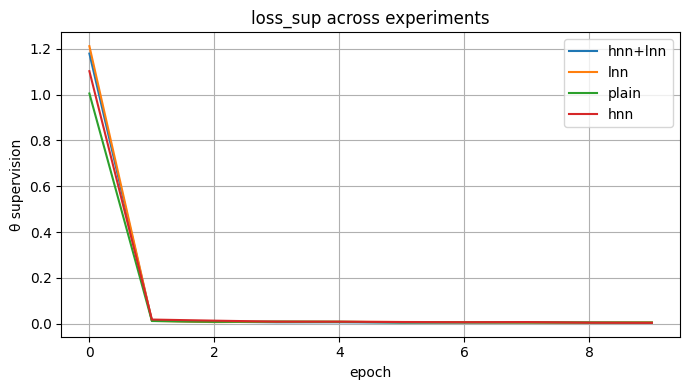

In [77]:
import numpy as np, matplotlib.pyplot as plt, glob, os, re

# ------------------------------------------------------------
# 1)  Load every results_<mode>.npz  and normalise keys
# ------------------------------------------------------------
logs = {}   # mode → dict

def _normalise_keys(ndict):
    """map total→loss_total, jepa→loss_jepa, … if needed"""
    mapping = {
        "total":"loss_total", "jepa":"loss_jepa",
        "hnn":"loss_hnn",     "lnn":"loss_lnn",
        "sup":"loss_sup"
    }
    out = {}
    for k,v in ndict.items():
        out[ mapping.get(k,k) ] = v
    return out

for file in glob.glob("results_*_dense.npz"):
    mode  = re.search(r"results_(.+)\_dense.npz", file).group(1)
    data  = np.load(file, allow_pickle=True)
    arrays= { k: data[k] for k in data.files if k != "config" }
    logs[mode] = _normalise_keys(arrays)
    logs[mode]["config"] = data["config"].item()
    n_ep = len(logs[mode]["loss_total"])
    print(f"loaded {mode:8} — epochs: {n_ep}")

# ------------------------------------------------------------
# 2)  Generic multi-line plot
# ------------------------------------------------------------
def plot_loss(comp, ylabel=None):
    plt.figure(figsize=(7,4))
    for mode,rec in logs.items():
        if comp in rec:
            plt.plot(rec[comp], label=mode)
    plt.xlabel("epoch")
    plt.ylabel(ylabel or comp)
    plt.title(f"{comp} across experiments")
    plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

# ------------------------------------------------------------
# 3)  Draw requested comparisons
# ------------------------------------------------------------
for key, label in [("loss_total","total objective"),
                   ("loss_hnn","HNN residual"),
                   ("loss_lnn","LNN residual"),
                   ("loss_jepa","JEPA recon."),
                   ("loss_sup","θ supervision")]:
    plot_loss(key, label)

Generating pendulum trajectories …


100%|██████████| 30/30 [00:00<00:00, 129.43it/s]


Created 3540 windows (seq_len=3)

>>> PLAIN <<<
{'r2_theta': 0.9999796152114868, 'mse_theta': 9.73064816207625e-05, 'r2_omega': 0.29609614610671997, 'mse_omega': 9.921295166015625}

>>> HNN <<<
{'r2_theta': 0.9999791979789734, 'mse_theta': 9.443904855288565e-05, 'r2_omega': 0.27099835872650146, 'mse_omega': 9.27684211730957}

>>> LNN <<<
{'r2_theta': 0.9999813437461853, 'mse_theta': 9.123844210989773e-05, 'r2_omega': 0.2531147003173828, 'mse_omega': 10.585156440734863}

>>> HNN+LNN <<<
{'r2_theta': 0.9999790787696838, 'mse_theta': 9.634550951886922e-05, 'r2_omega': 0.2953941226005554, 'mse_omega': 9.252267837524414}

Saved metrics → metrics_all_dense.json


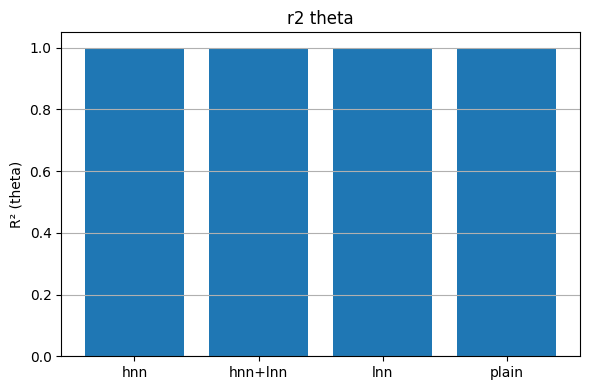

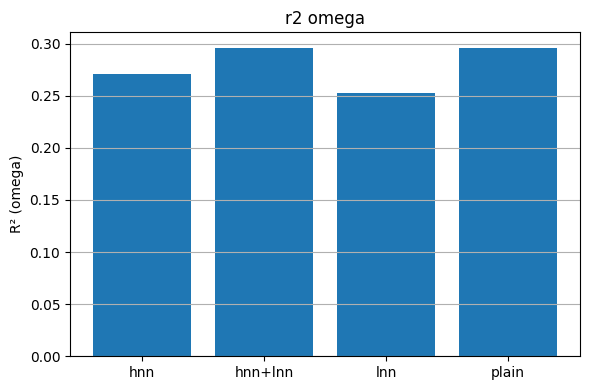

In [46]:
import torch, numpy as np, matplotlib.pyplot as plt, json, os, re
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from torch.utils.data import DataLoader
from tqdm import tqdm

# ------------------------------------------------------------------
# your existing regression helper, slightly tweaked to *return* metrics
# ------------------------------------------------------------------
def latent_phase_regression(model, dataset, batch_size=64, num_samples=500):
    model.eval()
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    latents, theta_list, omega_list = [], [], []
    collected = 0

    for seq, states in loader:
        imgs  = seq[:, 0].to(next(model.parameters()).device)
        theta = states[:, 0, 0].cpu().numpy()
        omega = states[:, 0, 1].cpu().numpy()

        with torch.no_grad():
            z = model.patch_embed(imgs) + model.pos_embed
            z = model.context_encoder(z).mean(1).cpu()

        latents.append(z)
        theta_list.extend(theta)
        omega_list.extend(omega)

        collected += imgs.size(0)
        if collected >= num_samples:
            break

    Z = torch.cat(latents, 0).numpy()[:num_samples]
    θ = np.array(theta_list)[:num_samples].reshape(-1,1)
    ω = np.array(omega_list)[:num_samples].reshape(-1,1)

    reg_θ = LinearRegression().fit(Z, θ)
    reg_ω = LinearRegression().fit(Z, ω)

    θ̂, ω̂ = reg_θ.predict(Z), reg_ω.predict(Z)
    return dict(
        r2_theta = float(r2_score(θ, θ̂)),
        mse_theta= float(mean_squared_error(θ, θ̂)),
        r2_omega = float(r2_score(ω, ω̂)),
        mse_omega= float(mean_squared_error(ω, ω̂)),
    )

# ------------------------------------------------------------------
# load-and-analyse loop
# ------------------------------------------------------------------
def analyse_saved_models(modes, dataset,
                         model_ctor, head_ctor,
                         result_json="metrics_all_dense.json"):
    out = {}
    for m in modes:
        print(f"\n>>> {m.upper()} <<<")

        model = model_ctor().to(device)
        head  = head_ctor().to(device)

        mdl_ckpt  = f"model_{m}_dense.pt"
        head_ckpt = f"theta_{m}_dense.pt"
        if not (os.path.exists(mdl_ckpt) and os.path.exists(head_ckpt)):
            print("  checkpoints missing, skipping.")
            continue
        model.load_state_dict(torch.load(mdl_ckpt,  map_location=device))
        head.load_state_dict (torch.load(head_ckpt, map_location=device))

        # graft head (only for forward pass clarity)
        model.theta_head = head

        # run regression
        metrics = latent_phase_regression(model, dataset)
        out[m] = metrics
        print(metrics)

    # save metrics to one json for later
    with open(result_json, "w") as f:
        json.dump(out, f, indent=2)
    print("\nSaved metrics →", result_json)
    return out

# ------------------------------------------------------------------
# quick comparison plot  (example: R² for θ̂)
# ------------------------------------------------------------------
def plot_metric(all_metrics, key, ylabel):
    plt.figure(figsize=(6,4))
    modes = sorted(all_metrics.keys())
    vals  = [all_metrics[m][key] for m in modes]
    plt.bar(modes, vals)
    plt.ylabel(ylabel); plt.title(key.replace("_"," "))
    plt.grid(axis="y"); plt.tight_layout(); plt.show()

# ------------------------------------------------------------------
# Usage
# ------------------------------------------------------------------
if __name__ == "__main__":
    modes   = ["plain", "hnn", "lnn", "hnn+lnn"]

    # a PendulumDataset identical to the one you used for training
    ds = PendulumDataset(num_episodes=30, episode_length=120,
                         img_size=64, seq_len=3)

    metrics = analyse_saved_models(
        modes,
        dataset   = ds,
        model_ctor= lambda: VJEPA(embed_dim=384, depth=6, num_heads=6),
        head_ctor = lambda: nn.Linear(384,2)
    )

    # plot comparison
    plot_metric(metrics, "r2_theta", "R² (theta)")
    plot_metric(metrics, "r2_omega", "R² (omega)")

Generating pendulum trajectories …


  0%|          | 0/40 [00:00<?, ?it/s]/Users/panaschristou/miniforge3/envs/sys_dev/lib/python3.12/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|██████████| 40/40 [00:00<00:00, 81.52it/s]


Created 7880 windows (seq_len=3)


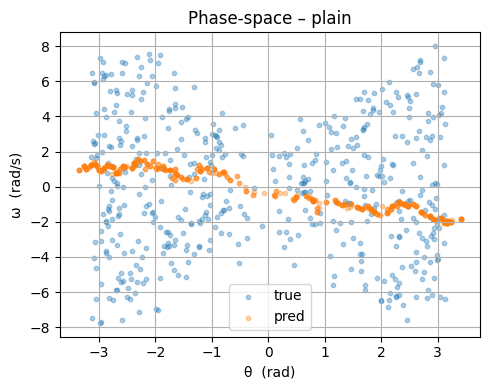

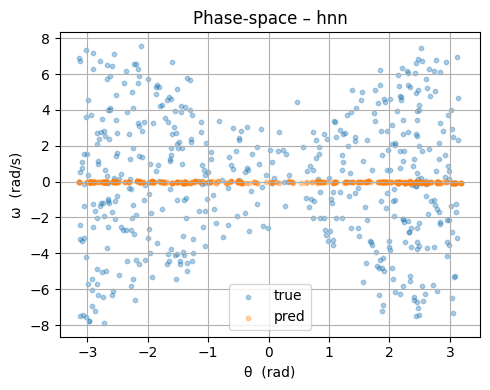

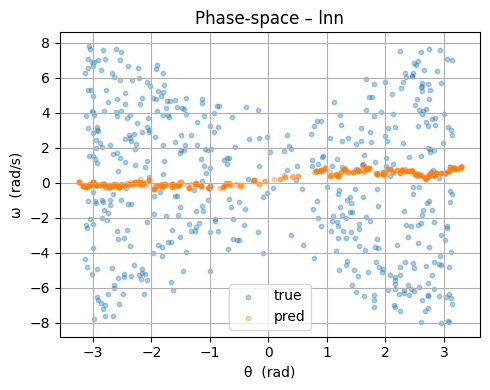

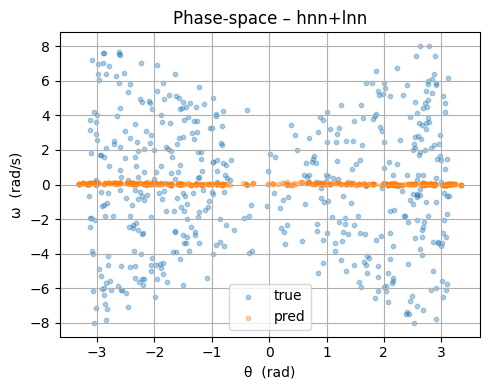

In [47]:
# ------------------------------------------------------------
# phase-space comparison for multiple trained models
# ------------------------------------------------------------
def plot_phase_space_models(modes,
                            dataset,
                            model_ctor,
                            head_ctor,
                            num_samples=500):
    """
    For every mode in `modes`:
      • load model_<mode>.pt  and  theta_<mode>.pt
      • scatter true (θ, ω)  vs. predicted (θ̂, ω̂) for up to num_samples
    """
    loader = DataLoader(dataset, batch_size=64, shuffle=True)

    results = {}          # mode → dict of arrays

    for mode in modes:
        mdl_file  = f"model_{mode}_dense.pt"
        head_file = f"theta_{mode}_dense.pt"
        if not (os.path.exists(mdl_file) and os.path.exists(head_file)):
            print(f"[{mode}] checkpoints missing — skipping")
            continue

        # -------- load nets ----------
        model = model_ctor().to(device)
        model.load_state_dict(torch.load(mdl_file, map_location=device))
        model.eval()

        theta_head = head_ctor().to(device)
        theta_head.load_state_dict(torch.load(head_file, map_location=device))
        theta_head.eval()

        θ_true, ω_true, θ_pred, ω_pred = [], [], [], []
        collected = 0

        for seq, states in loader:
            imgs  = seq[:, 0].to(device)          # (B,C,H,W) frame 0
            with torch.no_grad():
                z = model.patch_embed(imgs) + model.pos_embed
                z = model.context_encoder(z).mean(1)
                θ̂, ω̂ = theta_head(z).split(1,1)

            θ_true.extend(states[:,0,0].cpu().numpy())
            ω_true.extend(states[:,0,1].cpu().numpy())
            θ_pred.extend(θ̂.squeeze().cpu().numpy())
            ω_pred.extend(ω̂.squeeze().cpu().numpy())

            collected += imgs.size(0)
            if collected >= num_samples:
                break

        # trim to num_samples exactly
        θ_true = np.array(θ_true)[:num_samples]
        ω_true = np.array(ω_true)[:num_samples]
        θ_pred = np.array(θ_pred)[:num_samples]
        ω_pred = np.array(ω_pred)[:num_samples]

        results[mode] = dict(theta_true=θ_true,
                             omega_true=ω_true,
                             theta_pred=θ_pred,
                             omega_pred=ω_pred)

        # -------- plotting ----------
        plt.figure(figsize=(5,4))
        plt.scatter(θ_true, ω_true, s=10, alpha=.35, label="true")
        plt.scatter(θ_pred, ω_pred, s=10, alpha=.35, label="pred")
        plt.xlabel("θ  (rad)")
        plt.ylabel("ω  (rad/s)")
        plt.title(f"Phase-space – {mode}")
        plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

    return results

# ------------------------------------------------------------
# example call
# ------------------------------------------------------------
if __name__ == "__main__":
    ds = PendulumDataset(num_episodes=40, episode_length=200,
                         img_size=64, seq_len=3)

    modes = ["plain", "hnn", "lnn", "hnn+lnn"]   # adjust as you like

    phase_data = plot_phase_space_models(
        modes      = modes,
        dataset    = ds,
        model_ctor = lambda: VJEPA(embed_dim=384, depth=6, num_heads=6),
        head_ctor  = lambda: nn.Linear(384,2),
        num_samples=500
    )

    # optional: save to disk for later analysis
    np.savez("phase_space_all_modes_dense.npz", **phase_data)

Generating pendulum trajectories …


100%|██████████| 40/40 [00:00<00:00, 85.78it/s]


Created 7880 windows (seq_len=3)

PLAIN:  θ R²=0.994  ω R²=-0.132


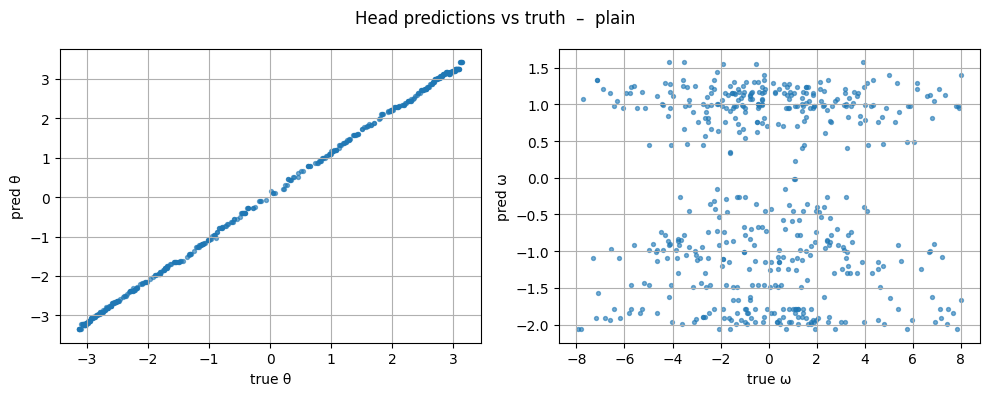


HNN:  θ R²=0.999  ω R²=-0.001


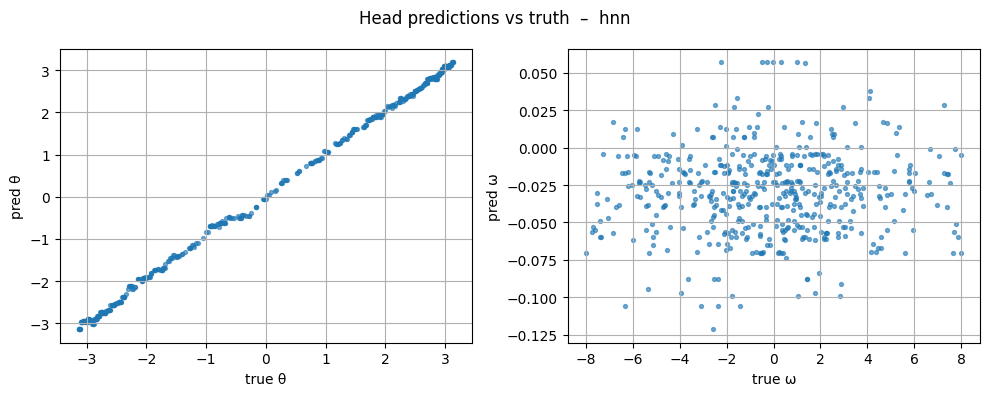


LNN:  θ R²=0.998  ω R²=-0.009


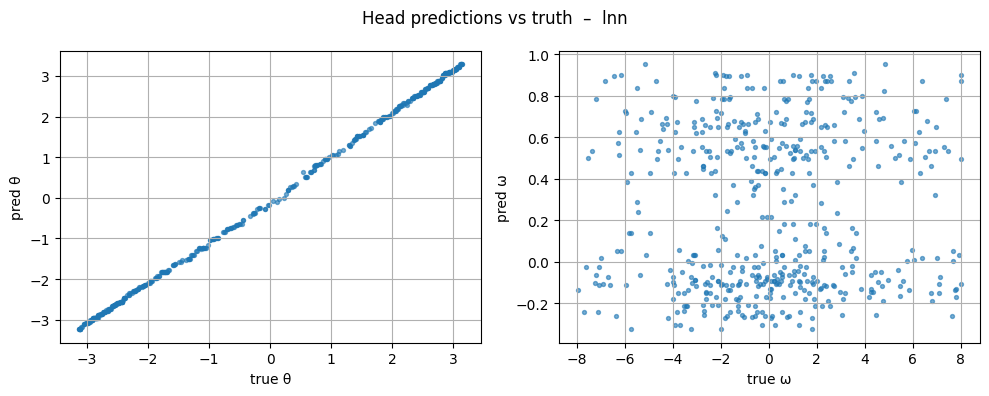


HNN+LNN:  θ R²=0.997  ω R²=0.001


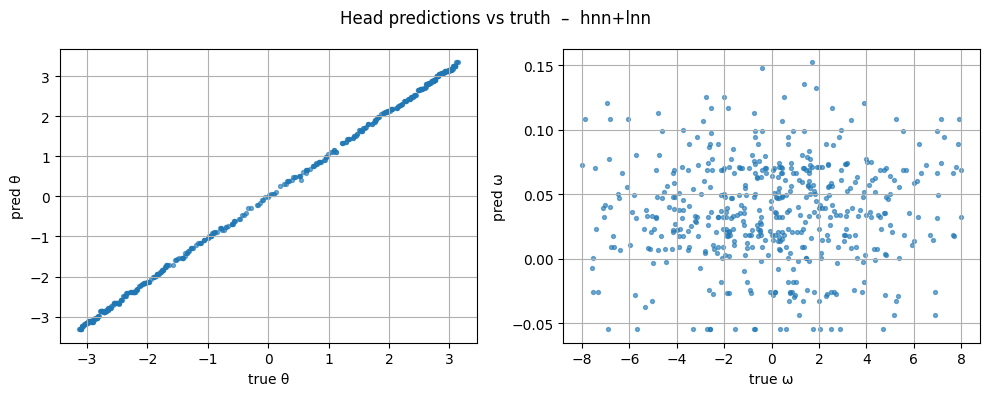


Saved metrics → head_metrics_dense.json


In [48]:
import torch, numpy as np, matplotlib.pyplot as plt, json, os, re
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.metrics import r2_score, mean_squared_error

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ────────────────────────────────────────────────────────────────
# 0 · helper: run head → (θ̂, ω̂) and collect points
# ────────────────────────────────────────────────────────────────
def _scatter_head(model, head, dataset, num_samples=500, batch_size=64):
    model.eval(); head.eval()
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    θ_true, ω_true, θ_pred, ω_pred = [], [], [], []
    collected = 0

    for seq, states in loader:
        imgs = seq[:, 0].to(device)                       # (B,C,H,W)
        with torch.no_grad():
            z = model.patch_embed(imgs) + model.pos_embed
            z = model.context_encoder(z).mean(1)          # (B,D)
            θ̂, ω̂ = head(z).split(1, 1)

        θ_true.extend(states[:, 0, 0].cpu().numpy())
        ω_true.extend(states[:, 0, 1].cpu().numpy())
        θ_pred.extend(θ̂.squeeze().cpu().numpy())
        ω_pred.extend(ω̂.squeeze().cpu().numpy())

        collected += imgs.size(0)
        if collected >= num_samples:
            break

    # trim exactly
    θ_t = np.array(θ_true)[:num_samples]
    ω_t = np.array(ω_true)[:num_samples]
    θ_p = np.array(θ_pred)[:num_samples]
    ω_p = np.array(ω_pred)[:num_samples]

    return θ_t, ω_t, θ_p, ω_p


# ────────────────────────────────────────────────────────────────
# 1 · analyse & plot for all modes
# ────────────────────────────────────────────────────────────────
def analyse_modes(modes,
                  dataset,
                  model_ctor,
                  head_ctor,
                  samples=500,
                  out_json="head_metrics_dense.json"):
    metrics = {}

    for m in modes:
        mdl_file  = f"model_{m}_dense.pt"
        head_file = f"theta_{m}_dense.pt"
        if not (os.path.exists(mdl_file) and os.path.exists(head_file)):
            print(f"[{m}] checkpoints not found → skipping"); continue

        # --- load nets -----------------------------------------------------
        model = model_ctor().to(device)
        model.load_state_dict(torch.load(mdl_file, map_location=device))
        head  = head_ctor().to(device)
        head.load_state_dict(torch.load(head_file, map_location=device))

        # --- collect points ------------------------------------------------
        θ_t, ω_t, θ_p, ω_p = _scatter_head(model, head, dataset,
                                           num_samples=samples)

        # --- metrics -------------------------------------------------------
        r2θ  = r2_score(θ_t, θ_p);   mseθ = mean_squared_error(θ_t, θ_p)
        r2ω  = r2_score(ω_t, ω_p);   mseω = mean_squared_error(ω_t, ω_p)
        metrics[m] = dict(r2_theta=r2θ, mse_theta=mseθ,
                          r2_omega=r2ω, mse_omega=mseω)
        print(f"\n{m.upper()}:  θ R²={r2θ:.3f}  ω R²={r2ω:.3f}")

        # --- scatter plots -------------------------------------------------
        plt.figure(figsize=(10,4))
        plt.subplot(1,2,1); plt.scatter(θ_t, θ_p, s=8, alpha=.6)
        plt.xlabel("true θ"); plt.ylabel("pred θ"); plt.grid()
        plt.subplot(1,2,2); plt.scatter(ω_t, ω_p, s=8, alpha=.6)
        plt.xlabel("true ω"); plt.ylabel("pred ω"); plt.grid()
        plt.suptitle(f"Head predictions vs truth  –  {m}")
        plt.tight_layout(); plt.show()

    with open(out_json, "w") as f: json.dump(metrics, f, indent=2)
    print("\nSaved metrics →", out_json)


# ────────────────────────────────────────────────────────────────
# 2 · example call
# ────────────────────────────────────────────────────────────────
if __name__ == "__main__":
    modes = ["plain", "hnn", "lnn", "hnn+lnn"]

    # dataset identical to training one
    ds = PendulumDataset(num_episodes=40, episode_length=200,
                         img_size=64, seq_len=3)

    analyse_modes(
        modes      = modes,
        dataset    = ds,
        model_ctor = lambda: VJEPA(embed_dim=384, depth=6, num_heads=6),
        head_ctor  = lambda: nn.Linear(384, 2),
        samples    = 500
    )

In [51]:
# --------------------------------------------
# PendulumDataset   (back-compatible + 3 knobs)
# --------------------------------------------
#  Knobs (all optional)
#  --------------------
#   sub_steps      : int ≥1
#       finer temporal resolution.  If =3 the env is stepped 3×
#       internally for every *stored* frame  ⇒  ≈3× denser trajectory.
#
#   init_grid      : list[(theta0, omega0)]
#       explicit initial states.  Each tuple becomes ONE episode and
#       overrides num_episodes.  Lets you build a deterministic phase-
#       space mesh for evaluation.
#
#   random_action  : bool
#       True  – default/old behaviour (random torque)
#       False – action = 0  ⇒ purely conservative swing-up dynamics.
#
#  Leave every knob at its default to reproduce the original dataset.
# --------------------------------------------
import gym, torch, numpy as np
from torch.utils.data import Dataset
from tqdm import tqdm
from PIL import Image, ImageDraw

class PendulumDataset(Dataset):
    def __init__(self,
                 num_episodes: int = 100,
                 episode_length: int = 200,
                 img_size: int = 64,
                 seq_len: int = 3,
                 *,
                 sub_steps: int = 1,                       # knob ①
                 init_grid: list[tuple[float, float]] | None = None,  # knob ②
                 random_action: bool = True,               # knob ③
                 transform=None):
        assert seq_len >= 2, "seq_len must be ≥ 2 for physics loss"
        self.img_size   = img_size
        self.seq_len    = seq_len

        # new-knob attributes
        self.sub_steps     = max(1, sub_steps)
        self.init_grid     = init_grid
        self.random_action = random_action
        self.transform     = transform

        self.frames, self.states, self.indices = [], [], []
        self._generate(num_episodes, episode_length)

    # ------------------------------------------------------------------
    # 1 · helper: draw pendulum image for angle theta
    # ------------------------------------------------------------------
    def _render_pendulum(self, theta: float) -> np.ndarray:
        L, cx, cy = self.img_size*0.4, self.img_size//2, self.img_size//2
        ex, ey = int(cx + L*np.sin(theta)), int(cy + L*np.cos(theta))

        img  = Image.new("RGB", (self.img_size, self.img_size), "white")
        draw = ImageDraw.Draw(img)
        draw.line([(cx, cy), (ex, ey)], fill="black", width=3)
        draw.ellipse([(cx-5, cy-5), (cx+5, cy+5)], fill="red")
        draw.ellipse([(ex-8, ey-8), (ex+8, ey+8)], fill="blue")
        return np.asarray(img)

    # ------------------------------------------------------------------
    # 2 · generate roll-outs
    # ------------------------------------------------------------------
    def _generate(self, n_episodes: int, epi_len: int):
        print("Generating pendulum trajectories …")
        env = gym.make("Pendulum-v1")

        # pick episode seeds
        seeds = self.init_grid if self.init_grid is not None else [None]*n_episodes

        for seed in tqdm(seeds):
            # --- set initial state -------------------------------------
            if seed is None:
                obs, _ = env.reset()
            else:
                theta0, omega0 = seed
                env.reset()
                env.unwrapped.state = np.array([theta0, omega0], dtype=np.float32)
                # newer gymnasium lacks state_to_obs(); build obs manually
                obs = np.array([np.cos(theta0), np.sin(theta0), omega0],
                               dtype=np.float32)
            # ------------------------------------------------------------

            ep_imgs, ep_states = [], []

            for _ in range(epi_len):
                # ----- optional temporal densification -----------------
                for _ in range(self.sub_steps):
                    action = (env.action_space.sample()
                              if self.random_action
                              else np.array([0.0], dtype=np.float32))
                    obs, _, done, trunc, _ = env.step(action)
                    if done or trunc:
                        break
                # --------------------------------------------------------

                theta = np.arctan2(obs[1], obs[0])
                omega = float(obs[2])

                ep_imgs.append(self._render_pendulum(theta))
                ep_states.append((theta, omega))

            # slide a window (unchanged logic)
            for t0 in range(0, len(ep_imgs) - self.seq_len + 1):
                self.indices.append(len(self.frames) + t0)

            self.frames.extend(ep_imgs)
            self.states.extend(ep_states)

        env.close()
        print(f"Created {len(self.indices)} windows (seq_len={self.seq_len})")

    # ------------------------------------------------------------------
    # 3 · PyTorch Dataset protocol
    # ------------------------------------------------------------------
    def __len__(self) -> int:
        return len(self.indices)

    def __getitem__(self, idx: int):
        start, end = self.indices[idx], self.indices[idx] + self.seq_len

        imgs = [torch.from_numpy(self.frames[i]).float()
                           .permute(2,0,1)/255. for i in range(start, end)]
        imgs = torch.stack(imgs)                      # (T,C,H,W)

        states = torch.tensor(self.states[start:end], dtype=torch.float32)

        if self.transform:
            imgs = self.transform(imgs)
        return imgs, states

In [52]:
grid = [(th, om)
        for th in np.linspace(-np.pi, np.pi, 15)
        for om in np.linspace(-5, 5, 9)]
ds = PendulumDataset(episode_length=300,
                     init_grid=grid,
                     random_action=False)

Generating pendulum trajectories …


  0%|          | 0/135 [00:00<?, ?it/s]/Users/panaschristou/miniforge3/envs/sys_dev/lib/python3.12/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|██████████| 135/135 [00:01<00:00, 89.03it/s]

Created 40230 windows (seq_len=3)


Generating pendulum trajectories …


100%|██████████| 135/135 [00:01<00:00, 96.51it/s]


Created 40230 windows (seq_len=3)

=== PLAIN  (suffix='_dense') ===


mean neighbour divergence = 0.1279

=== HNN  (suffix='_dense') ===


mean neighbour divergence = 0.0792

=== LNN  (suffix='_dense') ===


mean neighbour divergence = 0.1201

=== HNN+LNN  (suffix='_dense') ===


mean neighbour divergence = 0.1034


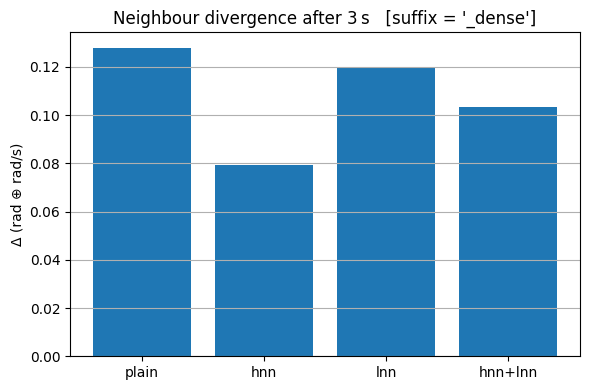

In [ ]:
"""
neighbour_divergence_eval.py
────────────────────────────
Evaluate one of TWO checkpoint sets that you have on disk:

    • “regular”    :  model_<mode>.pt          | theta_<mode>.pt
    • “dense grid” :  model_<mode>_dense.pt    | theta_<mode>_dense.pt

Both files are *flat* state-dicts produced by the training code you
shared (V-JEPA weights contain prefixes vjepa., hnn., lnn.).

Set SUFFIX = ""          → regular checkpoints  
    SUFFIX = "_dense"    → denser-grid checkpoints
"""

# ------------------------------------------------------------------
# 0 · user knob: which checkpoint set to test
# ------------------------------------------------------------------
SUFFIX = "_dense"         # "" | "_dense"

# ------------------------------------------------------------------
# 1 · imports
# ------------------------------------------------------------------
import torch, numpy as np, matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ------------------------------------------------------------------
# 2 · deterministic evaluation grid  (no external torque)
# ------------------------------------------------------------------
grid = [(th, om)
        for th in np.linspace(-np.pi, np.pi, 15)
        for om in np.linspace(-5.0,  5.0,  9)]

eval_ds = PendulumDataset(
    episode_length = 300,
    seq_len        = 3,
    init_grid      = grid,
    random_action  = False,
    sub_steps      = 1)
eval_loader = DataLoader(eval_ds, batch_size=64, shuffle=False)

# ------------------------------------------------------------------
# 3 · LNN acceleration helper
# ------------------------------------------------------------------
def lnn_accel(lnn, q, v, dt=0.05):
    qv = torch.stack([q, v], 1).requires_grad_(True)
    L  = lnn(qv).sum()
    dLd  = torch.autograd.grad(L, qv, create_graph=True)[0]
    dLdq, dLdv = dLd[:,0], dLd[:,1]
    d_dt_dLdv  = (dLdv - dLdv.detach()) / dt
    d2Ldv2     = torch.autograd.grad(dLdv.sum(), v, create_graph=True)[0]
    return (d_dt_dLdv - dLdq) / d2Ldv2

# ------------------------------------------------------------------
# 4 · loader – splits flat dict into vjepa / hnn / lnn parts
# ------------------------------------------------------------------
def load_components(mode:str):
    v_all = torch.load(f"model_{mode}{SUFFIX}.pt", map_location="cpu")
    h_sd  = torch.load(f"theta_{mode}{SUFFIX}.pt", map_location="cpu")

    vjepa_sd = {k: v for k,v in v_all.items()
                if not (k.startswith("hnn.") or k.startswith("lnn."))}

    hnn_sd = {k[len("hnn."):]: v for k,v in v_all.items()
              if k.startswith("hnn.")} or None
    lnn_sd = {k[len("lnn."):]: v for k,v in v_all.items()
              if k.startswith("lnn.")} or None
    return vjepa_sd, h_sd, hnn_sd, lnn_sd

# ------------------------------------------------------------------
# 5 · latent roll-out
# ------------------------------------------------------------------
@torch.no_grad()
def rollout_latent(vjepa, head, *, hnn=None, lnn=None,
                   horizon=60, dt=0.05):
    vjepa.eval(); head.eval()
    if hnn: hnn.eval()
    if lnn: lnn.eval()

    trajs = []
    for seq,_ in tqdm(eval_loader, desc="rollout", leave=False):
        imgs0 = seq[:,0].to(device)
        z0 = vjepa.context_encoder(vjepa.patch_embed(imgs0)+vjepa.pos_embed).mean(1)
        θ0, ω0 = head(z0).split(1,1)

        θs, ωs = [θ0.squeeze()], [ω0.squeeze()]
        for _ in range(horizon-1):
            q, v = θs[-1], ωs[-1]
            if hnn is not None:
                ω_dot = hnn.time_derivative(torch.stack([q,v],1))[:,1]
            elif lnn is not None:
                ω_dot = lnn_accel(lnn, q, v, dt)
            else:
                ω_dot = torch.zeros_like(v)
            θs.append(q + v     * dt)
            ωs.append(v + ω_dot * dt)

        trajs.append(torch.stack([torch.stack(θs,1),
                                  torch.stack(ωs,1)], dim=2))
    return torch.cat(trajs,0).cpu()      # (N,T,2)

# ------------------------------------------------------------------
# 6 · neighbour-divergence metric
# ------------------------------------------------------------------
def neighbour_div(traj, ε=0.1, step=-1):
    x0 = traj[:,0]
    dist = torch.cdist(x0, x0, p=2)
    mask = (dist>0) & (dist<ε)
    i,j  = torch.nonzero(mask, as_tuple=True)
    diff = traj[i,step] - traj[j,step]
    return diff.norm(dim=1).mean().item()

# ------------------------------------------------------------------
# 7 · evaluate the four modes
# ------------------------------------------------------------------
modes   = ["plain","hnn","lnn","hnn+lnn"]
results = {}

for mode in modes:
    print(f"\n=== {mode.upper()}  (suffix='{SUFFIX}') ===")
    v_sd, h_sd, hnn_sd, lnn_sd = load_components(mode)

    vjepa = VJEPA(embed_dim=384, depth=6, num_heads=6).to(device)
    head  = torch.nn.Linear(384,2).to(device)
    vjepa.load_state_dict(v_sd)
    head.load_state_dict(h_sd)

    hnn = lnn = None
    if "hnn" in mode and hnn_sd:
        hnn = HNN(hidden_dim=256).to(device); hnn.load_state_dict(hnn_sd)
    if mode=="lnn" and lnn_sd:
        lnn = LNN(input_dim=2, hidden_dim=256).to(device); lnn.load_state_dict(lnn_sd)

    traj = rollout_latent(vjepa, head, hnn=hnn, lnn=lnn)
    div  = neighbour_div(traj, ε=0.1, step=59)
    results[mode] = div
    print(f"mean neighbour divergence = {div:.4f}")

# ------------------------------------------------------------------
# 8 · bar plot
# ------------------------------------------------------------------
plt.figure(figsize=(6,4))
plt.bar(results.keys(), results.values())
plt.ylabel("Δ (rad ⊕ rad/s)")
plt.title(f"Neighbour divergence after 3 s   [suffix = '{SUFFIX}']")
plt.grid(axis="y"); plt.tight_layout(); plt.show()

In [69]:
"""
metrics_scorecard.py
────────────────────
Build a **physics-improvement score-card** for the four variants

        plain ‖ hnn ‖ lnn ‖ hnn+lnn

Two checkpoint families are supported out-of-the-box:

    model_<mode>.pt           | theta_<mode>.pt
    model_<mode>_dense.pt     | theta_<mode>_dense.pt

Select which one with the SUFFIX knob.
The file may be either

* **flat**   – only V-JEPA weights (your current training output)  
* **prefixed** – combined dict (old experiments, keys start with
  “vjepa.”, “hnn.”, “lnn.”, “theta_head.”)

The script detects both automatically.

It prints a compact table with

    • neighbour divergence  (Δ_div)          – smaller ⇒ trajectories stay close  
    • energy drift          (E_drift)        – absolute mean drift in total energy  
    • acceleration MSE      (α_MSE)          – learned vs analytic ω̇  
    • Euler–Lagrange resid. (EL_res)         – only if an LNN is present  
    • latent-to-θ R²        (R2_lat)         – linear predictability of θ from latent
"""

# ───────────────────────────────────────────────────────────────
# 0 · user knob
# ───────────────────────────────────────────────────────────────
SUFFIX   = "_dense"      # ""  |  "_dense"
HORIZON  = 60            # 60 × 0.05 s  ⇒ 3 s rollout
DT       = 0.05

g, l, m  = 9.81, 1.0, 1.0     # physical constants

# ───────────────────────────────────────────────────────────────
# 1 · imports
# ───────────────────────────────────────────────────────────────
import torch, torch.nn.functional as F
import numpy as np, matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import os, json

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------------------------------------------------
# 2 · deterministic evaluation grid  (no external torque)
# ----------------------------------------------------------------
grid = [(th, om)
        for th in np.linspace(-np.pi, np.pi, 15)
        for om in np.linspace(-5.0,  5.0,  9)]

eval_ds     = PendulumDataset(episode_length=300, seq_len=3,
                              init_grid=grid, random_action=False)
eval_loader = DataLoader(eval_ds, batch_size=64, shuffle=False)

# ----------------------------------------------------------------
# 3 · splitter that works for flat  **and**  prefixed checkpoints
# ----------------------------------------------------------------
def split_ckpt(path):
    """
    Returns  vjepa_sd , theta_sd , hnn_sd , lnn_sd  (some may be None)
    """
    ckpt = torch.load(path, map_location="cpu")

    # prefixed ⇒ strip prefixes ----------------------------------
    if any(k.startswith("vjepa.") for k in ckpt):
        vjepa_sd = {k[6:]  : v for k,v in ckpt.items() if k.startswith("vjepa.")}
        theta_sd = {k[11:]: v for k,v in ckpt.items() if k.startswith("theta_head.")}
        hnn_sd   = {k[4:]  : v for k,v in ckpt.items() if k.startswith("hnn.")} or None
        lnn_sd   = {k[4:]  : v for k,v in ckpt.items() if k.startswith("lnn.")} or None
        return vjepa_sd, theta_sd, hnn_sd, lnn_sd

    # flat ⇒ everything belongs to V-JEPA ------------------------
    return ckpt, None, None, None


def load_components(mode):
    """load V-JEPA, theta-head and (optionally) HNN / LNN states"""
    vjepa_sd, theta_sd, hnn_sd, lnn_sd = split_ckpt(f"model_{mode}{SUFFIX}.pt")

    # theta head saved separately in the current pipeline
    if theta_sd is None:
        theta_sd = torch.load(f"theta_{mode}{SUFFIX}.pt", map_location="cpu")

    return vjepa_sd, theta_sd, hnn_sd, lnn_sd

# -------------------------------------------------------------
# 4.Stable LNN acceleration helper (single grad w.r.t. qv)
# -------------------------------------------------------------
def lnn_accel(lnn, q, v, dt=DT, eps=1e-6, a_clip=25.0):
    """
    Stable acceleration from a learned Lagrangian NN
      a = ( d/dt ∂L/∂v  –  ∂L/∂q )  /  ∂²L/∂v²
    q, v : (B,)   – 1-D tensors of θ and ω
    returns a : (B,)  – predicted ω̇
    """
    # ---------------------------------------------
    # 1) build (q,v) with grad tracking
    # ---------------------------------------------
    qv = torch.stack([q, v], dim=1).requires_grad_(True)   # (B,2)

    # ---------------------------------------------
    # 2) L(q,v)  and first derivatives
    # ---------------------------------------------
    L = lnn(qv).sum()
    dLdqv = torch.autograd.grad(L, qv, create_graph=True)[0]  # (B,2)
    dLdq, dLdv = dLdqv[:, 0], dLdqv[:, 1]                     # (B,)

    # time derivative  d/dt ∂L/∂v  ~  (current − stop-grad) / dt
    dLdv_dt = (dLdv - dLdv.detach()) / dt                    # (B,)

    # ---------------------------------------------
    # 3) second derivative  ∂²L/∂v²   (diagonal entry)
    # ---------------------------------------------
    d2Ldv2 = torch.autograd.grad(dLdv.sum(), qv,
                                 create_graph=True)[0][:, 1] # (B,)

    # clamp denominator to avoid division blow-up
    denom = d2Ldv2.abs().clamp_min(eps) * d2Ldv2.sign()      # preserve sign

    # ---------------------------------------------
    # 4) acceleration  and optional clipping
    # ---------------------------------------------
    a_pred = (dLdv_dt - dLdq) / denom                        # (B,)
    if a_clip is not None:
        a_pred = a_pred.clamp(-a_clip, a_clip)

    return a_pred

# ----------------------------------------------------------------
# 5 · rollout latent phase trajectory
# ----------------------------------------------------------------
@torch.no_grad()                         # ← keep memory-efficient wrapper
def rollout(vjepa, head, *, hnn=None, lnn=None,
            horizon=HORIZON, dt=DT):
    """
    Returns three tensors θ, ω, α  of shape (N,T).

    α = learned angular acceleration (zeros if neither HNN nor LNN is used)
    """
    vjepa.eval(); head.eval()
    if hnn: hnn.eval()
    if lnn: lnn.eval()

    θ_list, ω_list, α_list = [], [], []
    for seq, _ in tqdm(eval_loader, desc="rollout", leave=False):
        imgs0 = seq[:, 0].to(device)

        # -- initial latent → (θ̂₀, ω̂₀) ---------------------------
        z0        = vjepa.context_encoder(
                        vjepa.patch_embed(imgs0) + vjepa.pos_embed).mean(1)
        θ0, ω0    = head(z0).split(1, 1)           # (B,1) each
        θs, ωs    = [θ0.squeeze()], [ω0.squeeze()]
        αs        = []                             # will pad later

        # -- roll out ---------------------------------------------
        for _ in range(horizon - 1):
            q, v = θs[-1].detach(), ωs[-1].detach()

            # enable grads ONLY for the physics net we need
            if hnn is not None:
                with torch.set_grad_enabled(True):
                    qp   = torch.stack([q, v], 1).requires_grad_(True)
                    a    = hnn.time_derivative(qp)[:, 1]          # dp/dt
            elif lnn is not None:
                with torch.set_grad_enabled(True):
                    a    = lnn_accel(lnn, q, v, dt)               # from LNN
            else:
                a = torch.zeros_like(v)                           # plain V-JEPA

            q_next = q + v * dt
            v_next = v + a * dt

            θs.append(q_next); ωs.append(v_next); αs.append(a)

        # pad α with a zero for t = 0
        αs = [torch.zeros_like(αs[0])] + αs

        θ_list.append(torch.stack(θs, 1))
        ω_list.append(torch.stack(ωs, 1))
        α_list.append(torch.stack(αs, 1))

    θ = torch.cat(θ_list, 0).cpu()
    ω = torch.cat(ω_list, 0).cpu()
    α = torch.cat(α_list, 0).cpu()
    return θ, ω, α        # each (N, T)

# ----------------------------------------------------------------
# 6 · metric helpers   (▸ only latent_R2 changed)
# ----------------------------------------------------------------
def neighbour_divergence(θ, ω, ε=0.1, step=-1):
    phase0 = torch.stack([θ[:, 0], ω[:, 0]], 1)
    dist   = torch.cdist(phase0, phase0, p=2)
    mask   = (dist > 0) & (dist < ε)
    i, j   = torch.nonzero(mask, as_tuple=True)
    diff   = torch.stack([θ[i, step] - θ[j, step],
                          ω[i, step] - ω[j, step]], 1)
    return diff.norm(dim=1).mean().item()


def energy_drift(θ, ω):
    E0 = 0.5 * m * (l ** 2) * ω[:, 0] ** 2 + m * g * l * (1 - torch.cos(θ[:, 0]))
    Et = 0.5 * m * (l ** 2) * ω[:, -1] ** 2 + m * g * l * (1 - torch.cos(θ[:, -1]))
    return (Et - E0).abs().mean().item()


def accel_mse(θ, α_pred):
    α_true = -g / l * torch.sin(θ[:, :-1])        # skip last step
    return F.mse_loss(α_pred[:, :-1], α_true).item()


def el_residual_metric(lnn, θ, ω):
    q = θ[:, :3, None]       # (N,3,1)
    v = ω[:, :3, None]
    return lnn.lagrangian_residual(q.to(device),
                                   v.to(device), DT).item()


def latent_R2(vjepa, head,                     # ▸ FIX: detach()
              n_samples=500):
    """
    Linear-regression R² for predicting θ from the *latent* vector.
    """
    vjepa.eval(); head.eval()
    Z, θ = [], []
    collected = 0
    for seq, st in eval_loader:
        imgs0 = seq[:, 0].to(device)
        z = vjepa.context_encoder(
                vjepa.patch_embed(imgs0) + vjepa.pos_embed).mean(1)
        Z.append(z.detach().cpu())                      # ← detach()
        θ.extend(st[:, 0, 0].tolist())
        collected += imgs0.size(0)
        if collected >= n_samples:
            break
    Z = torch.cat(Z, 0).numpy()[:n_samples]
    θ = np.array(θ)[:n_samples]
    return r2_score(θ, LinearRegression().fit(Z, θ).predict(Z))

# ----------------------------------------------------------------
# 7 · run all modes
# ----------------------------------------------------------------
modes  = ["plain", "hnn", "lnn", "hnn+lnn"]
table  = {m: {} for m in modes}

for mode in modes:
    v_sd, t_sd, hnn_sd, lnn_sd = load_components(mode)

    vjepa = VJEPA(embed_dim=384, depth=6, num_heads=6).to(device)
    head  = torch.nn.Linear(384, 2).to(device)

    vjepa.load_state_dict(v_sd, strict=True)
    head.load_state_dict(t_sd, strict=True)

    hnn = lnn = None
    if "hnn" in mode and hnn_sd:
        hnn = HNN(hidden_dim=256).to(device)
        hnn.load_state_dict(hnn_sd, strict=True)
    if "lnn" in mode and lnn_sd:
        lnn = LNN(input_dim=2, hidden_dim=256).to(device)
        lnn.load_state_dict(lnn_sd, strict=True)

    θ, ω, α = rollout(vjepa, head, hnn=hnn, lnn=lnn)

    table[mode]["Δ_div"]   = neighbour_divergence(θ, ω)
    table[mode]["E_drift"] = energy_drift(θ, ω)
    table[mode]["α_MSE"]   = accel_mse(θ, α)
    table[mode]["R2_lat"]  = latent_R2(vjepa, head)

    if lnn is not None:
        table[mode]["EL_res"] = el_residual_metric(lnn, θ, ω)
    else:
        table[mode]["EL_res"] = np.nan

# ----------------------------------------------------------------
# 8 · print score-card
# ----------------------------------------------------------------
print("\n=== Physics score-card  (suffix = '%s') ===" % SUFFIX)
hdr = "mode     Δ_div     E_drift       α_MSE     EL_res     R2_lat"
print(hdr); print("-" * len(hdr))
for m, d in table.items():
    el = f"{d['EL_res']:.2e}" if not np.isnan(d['EL_res']) else "   -   "
    print(f"{m:<8} {d['Δ_div']:.3f}   {d['E_drift']:.3e}   "
          f"{d['α_MSE']:.3f}   {el:>8}   {d['R2_lat']:.3f}")

# ----------------------------------------------------------------
# 9 · optional: save JSON for later plotting
# ----------------------------------------------------------------
with open(f"scorecard{SUFFIX or '_regular'}.json", "w") as f:
    json.dump(table, f, indent=2)
print("\nSaved →", f"scorecard{SUFFIX or '_regular'}.json")

Generating pendulum trajectories …


  0%|          | 0/135 [00:00<?, ?it/s]/Users/panaschristou/miniforge3/envs/sys_dev/lib/python3.12/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|██████████| 135/135 [00:02<00:00, 62.20it/s]


Created 40230 windows (seq_len=3)



=== Physics score-card  (suffix = '_dense') ===
mode     Δ_div     E_drift       α_MSE     EL_res     R2_lat
------------------------------------------------------------
plain    0.130   1.053e+01   51.869       -      1.000
hnn      0.103   1.488e+00   43.563       -      1.000
lnn      1.835   9.947e+00   72.761   7.49e-05   1.000
hnn+lnn  0.090   2.611e+00   42.910   6.88e-06   1.000

Saved → scorecard_dense.json


In [76]:
# metrics_scorecard.py  – compare plain / HNN / LNN / HNN+LNN
# -----------------------------------------------------------
SUFFIX   = "_dense"          # ""  or  "_dense"
HORIZON  = 60                # 3 s  (dt·steps = 0.05·60)
DT       = 0.05
g, l, m  = 9.81, 1.0, 1.0

import torch, torch.nn.functional as F
import numpy as np, matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ──────────────────────────────────────────────────────────────
# 0 · deterministic grid (no external torque)
# ──────────────────────────────────────────────────────────────
grid = [(th, om)
        for th in np.linspace(-np.pi, np.pi, 15)
        for om in np.linspace(-5.0,  5.0,  9)]

eval_ds = PendulumDataset(episode_length=300, seq_len=3,
                          init_grid=grid, random_action=False)
eval_loader = DataLoader(eval_ds, batch_size=64, shuffle=False)

# ──────────────────────────────────────────────────────────────
# 1 · which physics net is *used* at roll-out time?
# ──────────────────────────────────────────────────────────────
PHYS_ACTIVE = {
    "plain"   : False,
    "hnn"     : True,
    "lnn"     : False,
    "hnn+lnn" : True     # key can now contain the '+'
}

# ──────────────────────────────────────────────────────────────
# 2 · helpers
# ──────────────────────────────────────────────────────────────
def split_state_dict(mode):
    """Return four state-dicts:   vjepa , theta_head , hnn , lnn"""
    sd = torch.load(f"model_{mode}{SUFFIX}.pt",  map_location="cpu")   # flat
    hd = torch.load(f"theta_{mode}{SUFFIX}.pt",  map_location="cpu")

    # keep **only** parameters belonging to one sub-module
    vjepa_sd = {k[len("vjepa."):]: v for k, v in sd.items()
                if k.startswith("vjepa.")}
    hnn_sd   = {k[len("hnn."):]  : v for k, v in sd.items()
                if k.startswith("hnn.")} or None
    lnn_sd   = {k[len("lnn."):]  : v for k, v in sd.items()
                if k.startswith("lnn.")} or None

    # theta head file already contains just weight/bias
    return vjepa_sd, hd, hnn_sd, lnn_sd


def lnn_accel(lnn, q, v, dt=DT, eps=1e-6):
    qv = torch.stack([q, v], 1).requires_grad_(True)
    L  = lnn(qv).sum()
    dLdqv = torch.autograd.grad(L, qv, create_graph=True)[0]
    dLdq, dLdv = dLdqv[:, 0], dLdqv[:, 1]

    dLdv_dt = (dLdv - dLdv.detach()) / dt
    d2Ldv2  = torch.autograd.grad(dLdv.sum(), v, create_graph=True)[0]
    denom   = d2Ldv2.clamp(min=eps).detach()
    return (dLdv_dt - dLdq) / denom


@torch.no_grad()
def rollout(vjepa, head, *, hnn=None, lnn=None,
            use_hnn=False, use_lnn=False,
            horizon=HORIZON, dt=DT):
    θ_all, ω_all, α_all = [], [], []

    for seq, _ in eval_loader:
        imgs0 = seq[:, 0].to(device)

        # latent of frame-0
        z0 = vjepa.context_encoder(
                 vjepa.patch_embed(imgs0) + vjepa.pos_embed).mean(1)
        θ0, ω0 = head(z0).split(1, 1)

        θs, ωs, αs = [θ0.squeeze()], [ω0.squeeze()], []

        for _ in range(horizon - 1):
            q, v = θs[-1], ωs[-1]

            if use_hnn and hnn is not None:
                with torch.enable_grad():
                    qp = torch.stack([q, v], 1).requires_grad_(True)
                    a  = hnn.time_derivative(qp)[:, 1]
            elif use_lnn and lnn is not None:
                with torch.enable_grad():
                    a = lnn_accel(lnn, q, v)
            else:
                a = torch.zeros_like(v)

            θs.append(q + v * dt)
            ωs.append(v + a * dt)
            αs.append(a)

        αs = [torch.zeros_like(αs[0])] + αs
        θ_all.append(torch.stack(θs, 1))
        ω_all.append(torch.stack(ωs, 1))
        α_all.append(torch.stack(αs, 1))

    return (torch.cat(t, 0) for t in (θ_all, ω_all, α_all))


def neighbour_div(θ, ω, ε=0.1, step=-1):
    x0   = torch.stack([θ[:, 0], ω[:, 0]], 1)
    d    = torch.cdist(x0, x0, p=2)
    mask = (d > 0) & (d < ε)
    i, j = torch.nonzero(mask, as_tuple=True)
    diff = torch.stack([θ[i, step] - θ[j, step],
                        ω[i, step] - ω[j, step]], 1)
    return diff.norm(dim=1).mean().item()


def energy_drift(θ, ω):
    E0 = 0.5 * m * l**2 * ω[:, 0]**2 + m * g * l * (1 - np.cos(θ[:, 0]))
    Et = 0.5 * m * l**2 * ω[:, -1]**2 + m * g * l * (1 - np.cos(θ[:, -1]))
    return (Et - E0).abs().mean().item()


def accel_mse(θ, α_pred):
    α_true = -g / l * torch.sin(θ[:, :-1])
    return F.mse_loss(α_pred[:, :-1], α_true).item()


def latent_R2(vjepa, head, n_pts=500):
    Z, θ = [], []
    collected = 0
    for seq, st in eval_loader:
        imgs0 = seq[:, 0].to(device)
        z = vjepa.context_encoder(
                vjepa.patch_embed(imgs0) + vjepa.pos_embed).mean(1)
        Z.append(z.cpu())
        θ.extend(st[:, 0, 0].tolist())
        collected += imgs0.size(0)
        if collected >= n_pts:
            break
    Z = torch.cat(Z, 0)[:n_pts].detach().numpy()
    θ = np.array(θ)[:n_pts]
    return r2_score(θ, LinearRegression().fit(Z, θ).predict(Z))

# ──────────────────────────────────────────────────────────────
# 3 · run and pretty-print
# ──────────────────────────────────────────────────────────────
modes = ["plain", "hnn", "lnn", "hnn+lnn"]
table = {}

for mode in modes:
    v_sd, t_sd, hnn_sd, lnn_sd = split_state_dict(mode)

    vjepa = VJEPA(embed_dim=384, depth=6, num_heads=6).to(device)
    head  = torch.nn.Linear(384, 2).to(device)
    vjepa.load_state_dict(v_sd, strict=True)
    head.load_state_dict(t_sd, strict=True)

    hnn = lnn = None
    if hnn_sd:
        hnn = HNN(hidden_dim=256).to(device)
        hnn.load_state_dict(hnn_sd)
    if lnn_sd:
        lnn = LNN(input_dim=2, hidden_dim=256).to(device)
        lnn.load_state_dict(lnn_sd)

    θ, ω, α = rollout(
        vjepa, head,
        hnn=hnn, lnn=lnn,
        use_hnn=PHYS_ACTIVE[mode] and (hnn is not None),
        use_lnn=PHYS_ACTIVE[mode] and (lnn is not None)
    )

    table[mode] = dict(
        Δ_div   = neighbour_div(θ, ω),
        E_drift = energy_drift(θ, ω),
        α_MSE   = accel_mse(θ, α),
        R2_lat  = latent_R2(vjepa, head),
        EL_res  = np.nan if lnn is None else
                  lnn.lagrangian_residual(θ[:, :3, None].to(device),
                                           ω[:, :3, None].to(device), DT).item()
    )

# print score-card
print(f"\n=== Physics score-card  (suffix = '{SUFFIX}') ===")
hdr = f"{'mode':6} {'Δ_div':>7} {'E_drift':>9} {'α_MSE':>8} {'EL_res':>9} {'R2_lat':>7}"
print(hdr); print("-" * len(hdr))
for m, d in table.items():
    el = "  –  " if np.isnan(d['EL_res']) else f"{d['EL_res']:8.2e}"
    print(f"{m:6} {d['Δ_div']:7.3f} {d['E_drift']:9.3e} "
          f"{d['α_MSE']:8.3f} {el} {d['R2_lat']:7.3f}")

Generating pendulum trajectories …


  0%|          | 0/135 [00:00<?, ?it/s]/Users/panaschristou/miniforge3/envs/sys_dev/lib/python3.12/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|██████████| 135/135 [00:01<00:00, 86.05it/s]


Created 40230 windows (seq_len=3)

=== Physics score-card  (suffix = '_dense') ===
mode     Δ_div   E_drift    α_MSE    EL_res  R2_lat
---------------------------------------------------
plain    0.133 6.341e+00   31.196   –     1.000
hnn      0.150 4.712e+00   35.273   –     1.000
lnn      0.135 2.780e+00   19.462 7.37e-05   1.000
hnn+lnn   0.180 3.901e+00   20.550 2.29e-05   1.000


In [82]:
# eval_one_fixed.py  ────────────────────────────────────────────────
# Evaluate **one** checkpoint (plain / hnn / lnn / hnn+lnn) and
# dump the core physics metrics to  metrics_<mode>[_dense].json
#
# – Works with *flat* checkpoints (your current training) and the
#   older *prefixed* combined-dict style.
# – Uses the same metric formulas as the “good” score-card script.
# -------------------------------------------------------------------

import torch, numpy as np, json
from torch.utils.data import DataLoader
from tqdm import tqdm

# ------------ physical & rollout constants --------------------------
DT, HORIZON = 0.05, 60          # 3 s rollout
g, l, m     = 9.81, 1.0, 1.0
device      = "cuda" if torch.cuda.is_available() else "cpu"

# ------------ your dataset & model classes must already exist -------
# from your_code import PendulumDataset, VJEPA, HNN, LNN
# from your_code import lnn_accel   (stable version)
# --------------------------------------------------------------------

# ------------------------------------------------------------------
# Stable LNN acceleration  (no need for `v.requires_grad_()`)
# ------------------------------------------------------------------
def lnn_accel(lnn, q, v, dt=DT, eps=1e-6, a_clip=25.0):
    """
    a = ( d/dt ∂L/∂v  –  ∂L/∂q ) / ∂²L/∂v²
    q, v : (B,) tensors – **need not require_grad**.
    """
    # build concatenated state that *does* track grads
    qv = torch.stack([q, v], 1).requires_grad_(True)    # (B,2)

    # L(q,v) and first derivatives
    L      = lnn(qv).sum()
    dLdqv  = torch.autograd.grad(L, qv, create_graph=True)[0]
    dLdq, dLdv = dLdqv[:, 0], dLdqv[:, 1]

    # time derivative of ∂L/∂v  (Euler forward on tiny dt)
    dLdv_dt = (dLdv - dLdv.detach()) / dt

    # second derivative ∂²L/∂v²  – differentiate w.r.t. *qv*
    d2Ldv2 = torch.autograd.grad(dLdv.sum(), qv,
                                 create_graph=True)[0][:, 1]

    denom  = d2Ldv2.abs().clamp_min(eps) * d2Ldv2.sign()   # keep sign
    a_pred = (dLdv_dt - dLdq) / denom
    if a_clip is not None:
        a_pred = a_pred.clamp(-a_clip, a_clip)
    return a_pred

# ────────────────────────────────────────────────────────────────────
# utilities
# ────────────────────────────────────────────────────────────────────
def split_ckpt(path_model, path_theta):
    """
    Accepts either
        * prefixed dict  (keys start with vjepa./hnn./lnn./theta_head.)
        * flat V-JEPA dict (plus separate theta file)
    Returns un-prefixed state-dicts:  vjepa_sd, theta_sd, hnn_sd, lnn_sd
    """
    sd = torch.load(path_model, map_location="cpu")

    if any(k.startswith("vjepa.") for k in sd):          # ← old/prefixed
        vjepa_sd = {k[6:]:  v for k, v in sd.items() if k.startswith("vjepa.")}
        theta_sd = {k[11:]: v for k, v in sd.items() if k.startswith("theta_head.")}
        hnn_sd   = {k[4:]:  v for k, v in sd.items() if k.startswith("hnn.")} or None
        lnn_sd   = {k[4:]:  v for k, v in sd.items() if k.startswith("lnn.")} or None
    else:                                                 # ← new/flat
        vjepa_sd, theta_sd = sd, torch.load(path_theta, map_location="cpu")
        hnn_sd = lnn_sd = None

    return vjepa_sd, theta_sd, hnn_sd, lnn_sd


def load_net(mode: str, suffix: str = "_dense"):
    """instantiate networks and load weights"""
    v_sd, t_sd, hnn_sd, lnn_sd = split_ckpt(f"model_{mode}{suffix}.pt",
                                           f"theta_{mode}{suffix}.pt")

    vjepa = VJEPA(embed_dim=384, depth=6, num_heads=6).to(device)
    head  = torch.nn.Linear(384, 2).to(device)
    vjepa.load_state_dict(v_sd, strict=True)
    head.load_state_dict(t_sd, strict=True)

    hnn = lnn = None
    if hnn_sd:
        hnn = HNN(hidden_dim=256).to(device)
        hnn.load_state_dict(hnn_sd, strict=True)
    if lnn_sd:
        lnn = LNN(input_dim=2, hidden_dim=256).to(device)
        lnn.load_state_dict(lnn_sd, strict=True)

    return vjepa, head, hnn, lnn


@torch.no_grad()
def rollout(vjepa, head, *, hnn=None, lnn=None, loader, horizon=HORIZON):
    """latent → (θ,ω) trajectory, returns tensors (N,T) each"""
    θ_cat, ω_cat = [], []
    for seq, _ in loader:
        imgs0 = seq[:, 0].to(device)
        z0    = vjepa.context_encoder(vjepa.patch_embed(imgs0)+vjepa.pos_embed).mean(1)
        θ, ω  = head(z0).split(1, 1)
        θ, ω  = θ.squeeze(), ω.squeeze()

        Θ, Ω = [θ], [ω]
        for _ in range(horizon - 1):
            if hnn is not None:
                with torch.set_grad_enabled(True):
                    qp = torch.stack([θ, ω], 1).requires_grad_(True)
                    α  = hnn.time_derivative(qp)[:, 1]
            elif lnn is not None:
                with torch.set_grad_enabled(True):
                    α  = lnn_accel(lnn, θ, ω, dt=DT)
            else:
                α = torch.zeros_like(ω)

            θ = θ + ω * DT
            ω = ω + α * DT
            Θ.append(θ); Ω.append(ω)

        θ_cat.append(torch.stack(Θ, 1))
        ω_cat.append(torch.stack(Ω, 1))

    return torch.cat(θ_cat, 0).cpu(), torch.cat(ω_cat, 0).cpu()


# ───────────────────────────── metrics ──────────────────────────────
def neighbour_divergence(θ, ω, ε=0.1, step=-1):
    start = torch.stack([θ[:, 0], ω[:, 0]], 1)
    d     = torch.cdist(start, start, p=2)
    mask  = (d > 0) & (d < ε)
    i, j  = torch.nonzero(mask, as_tuple=True)
    diff  = torch.stack([θ[i, step] - θ[j, step],
                         ω[i, step] - ω[j, step]], 1)
    return diff.norm(dim=1).mean().item()


def energy_drift(θ, ω):
    E0 = 0.5 * m * l**2 * ω[:, 0]**2 + m * g * l * (1 - torch.cos(θ[:, 0]))
    Et = 0.5 * m * l**2 * ω[:, -1]**2 + m * g * l * (1 - torch.cos(θ[:, -1]))
    return (Et - E0).abs().mean().item()


def el_residual_metric(lnn, θ, ω):
    """mean Euler–Lagrange residual over first 3 frames"""
    q = θ[:, :3, None]
    v = ω[:, :3, None]
    return lnn.lagrangian_residual(q.to(device), v.to(device), DT).item()


# ────────────────────────── main routine ────────────────────────────
def evaluate_mode(mode, suffix="_dense"):
    # 1) dataset (same for all modes)
    eval_loader = DataLoader(
        PendulumDataset(episode_length=300, seq_len=3,
                        init_grid=[(th, om)
                                   for th in np.linspace(-np.pi, np.pi, 15)
                                   for om in np.linspace(-5, 5, 9)],
                        random_action=False),
        batch_size=64, shuffle=False
    )

    # 2) nets & rollout
    vjepa, head, hnn, lnn = load_net(mode, suffix)
    θ, ω = rollout(vjepa, head, hnn=hnn, lnn=lnn, loader=eval_loader)

    # 3) metrics
    out = {
        "Δ_div"  : neighbour_divergence(θ, ω),
        "E_drift": energy_drift(θ, ω),
    }
    if lnn is not None:
        out["EL_res"] = el_residual_metric(lnn, θ, ω)

    # 4) save & display
    with open(f"metrics_{mode}{suffix}.json", "w") as f:
        json.dump(out, f, indent=2)
    print(f"{mode:8} →", out)


# run all four variants
for MODE in ["plain", "hnn", "lnn", "hnn+lnn"]:
    evaluate_mode(MODE, suffix="_dense")   # change suffix if needed

Generating pendulum trajectories …


100%|██████████| 135/135 [00:01<00:00, 84.08it/s]


Created 40230 windows (seq_len=3)
plain    → {'Δ_div': 0.12126506119966507, 'E_drift': 10.725542068481445}
Generating pendulum trajectories …


100%|██████████| 135/135 [00:01<00:00, 92.60it/s]


Created 40230 windows (seq_len=3)
hnn      → {'Δ_div': 0.10255179554224014, 'E_drift': 1.6224884986877441}
Generating pendulum trajectories …


100%|██████████| 135/135 [00:01<00:00, 96.03it/s]


Created 40230 windows (seq_len=3)
lnn      → {'Δ_div': 2.003871202468872, 'E_drift': 9.790180206298828, 'EL_res': 8.031479956116527e-05}
Generating pendulum trajectories …


100%|██████████| 135/135 [00:01<00:00, 94.82it/s]


Created 40230 windows (seq_len=3)
hnn+lnn  → {'Δ_div': 0.09304005652666092, 'E_drift': 2.857311964035034, 'EL_res': 6.954030141059775e-06}
